<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Generative-CDTL_0905.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [5]:
main_figsize=(15,3)

plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


In [6]:
def weights_init_normal(m):
    """Initializes the weight and bias of the model.

    Args:
        m: A torch model to initialize.

    Returns:
        None.
    """

    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.2)
        torch.nn.init.constant_(m.bias.data, 0)


In [7]:
# Define the Generator
# bucket에 대해 x를 전처리
class Generator(nn.Module):

    def __init__(self,input_dim):
        super(Generator, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [8]:
# Define the Discriminator
# 비즈니스에 해당하는 모델
class Discriminator(nn.Module):

    def __init__(self, input_dim=5):
        """Initializes Discriminator with torch components."""
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [9]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
import scipy

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    #test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    '''
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Ent(MI{bk})']= []

        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []
        test_analysis[f'Ent(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    test_analysis['TrainEnt(MI)']= []

    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Ent(MI)']= []

    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []
    test_analysis['Test Ent(DR)']= []
    '''
    if model2_ == None:
        ax = XS_test[:,0:b_dim]
        ref_ax = XS_train[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)
    '''
    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    #test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    #test_analysis['Test Std(MI)'].append(np.std(mi_scores))
    #test_analysis['Test Ent(MI)'].append(scipy.stats.entropy(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    #test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    #test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))
    #test_analysis['Test Ent(DR)'].append(scipy.stats.entropy(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    #test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    #test_analysis['TrainStd(MI)'].append(np.std(mi_scores))
    #test_analysis['TrainEnt(MI)'].append(scipy.stats.entropy(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    '''
    '''
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        #test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        #test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))
        #test_analysis[f'Ent(MI{bk})'].append(scipy.stats.entropy(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        #test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        #test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))
        #test_analysis[f'Ent(DR{bk})'].append(scipy.stats.entropy(ks[:,0]))
    '''
    print("Test f1 score: {}".format(f1))

    #test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1#,test_analysis_df

In [10]:

def test_all_data(discriminator,generator,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if generator == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = generator(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = discriminator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [11]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        mi = torch.cat(h, dim=1)
        return mi

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret

        return loss #, ret.sum().reshape(-1,)

In [41]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    #seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    discriminator = Discriminator(b_dim).to(device)
    discriminator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Generator(b_dim).to(device)
    #adapter.apply(weights_init_normal)

    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)

    mine_loss = customLoss(mine).to(device)
    optimizer_M = torch.optim.Adam(mine_loss.parameters(), lr=0.001)
    #kld_loss = nn.KLDivLoss(reduction='batchmean')
    default_value = torch.tensor([0.5],dtype=torch.float32).to(device)

    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) # + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = discriminator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()
        '''
        if lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------

            xs_test = adapter(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
            #x_sample = Variable(torch.clone(xs_test), requires_grad = True)

            m_loss, lmd = mine_loss(xs_test,
                                    y_test, #generator(xs_test).reshape(-1,1),
                                    default_value)

            m_losses.append(-m_loss.cpu().data.numpy())
            f_losses.append(lmd.cpu().data.numpy())

            m_loss = m_loss.sum() * 0.01
            #m_loss.mean().backward()

            #lambda_f = lmd #.detach()
        else:
            m_loss = torch.tensor(0.0)
        '''

        lambda1 = 0.6

        if lambda_f >= 0.0:
            #loss =  lambda1*g_loss + (1-lambda1)*a_loss + torch.std(torch.tensor((g_loss,a_loss)))   #(1.0-lambda_f) * g_loss + lambda_f * a_loss + m_loss.mean()*0.01
            loss =  g_loss + a_loss #+ torch.std(torch.tensor((g_loss,a_loss)))
        else:
            loss = g_loss

        loss.backward()

        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1 = test_model(discriminator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Generator loss':a_losses,'Predictor loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,discriminator,adapter,df_loss

In [13]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [14]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [15]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    for c_name in df_mis.columns:
        fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
        df_mis[c_name].plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
        ax[0].set_title(f'Mutual Information of {c_name}',fontdict={'fontsize':10})

        df_drf[c_name].plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
        ax[1].set_title(f'Drift (KS-test) of {c_name}',fontdict={'fontsize':10})
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    df_mis.plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
    ax[0].set_title(f'Mutual Information',fontdict={'fontsize':10})

    df_drf.plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
    ax[1].set_title(f'Drift (KS-test)',fontdict={'fontsize':10})
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return X,Y

In [16]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({test_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [17]:

def draw_chart(axis,legends,title, df,color,showfliers=True):
    if legends == None:
        legends = []

    legends.append((title,color))

    axis.set_xticks([])
    flierprops = dict(marker='.', markerfacecolor=color, markeredgecolor='none')
    if showfliers:
        df.T.plot.box(ax=axis, flierprops=flierprops,ylabel='F1 Score',fontsize=10,color=color)
    else:
        df.T.plot.box(ax=axis, showfliers=False,ylabel='F1 Score',fontsize=10,color=color)
    med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':df.T.median().values})],axis=0).reset_index(drop=True)
    med_df.plot(ax = axis,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color=color)
    return legends

def set_legend(axis,legends,title):
    axis.set_title(title,fontdict={'fontsize':10})
    #axis.legend([v for v,c in legends],ncol=len(legends),bbox_to_anchor=(1.05, 1.0), loc='upper left')
    axis.legend([v for v,c in legends],bbox_to_anchor=(1.05, 1.0), loc='upper left')
    leg = axis.get_legend()
    for i,(v,c) in enumerate(legends):
        leg.legendHandles[i].set_color(c)

def prepare_result_data():
    result_data = {} # Original
    train_data = {}
    result_table = {}
    result_table['Trial']=[]
    result_table['Testset F1']=[]
    result_table['Initial F1']=[]
    result_table['Mean F1']=[]
    result_table['Last F1']=[]
    result_table['Elapsed time']=[]
    return result_data,train_data,result_table

def set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,result_data,train_data,result_table):
    result_data[f'T{idx}'] = tad
    result_table['Trial'].append(idx)
    train_data[f'T{idx}'] = (df_loss,df_mis,df_drf)
    result_table['Testset F1'].append(tad[0])
    result_table['Initial F1'].append(tad[1])
    result_table['Mean F1'].append(np.mean(tad))
    result_table['Last F1'].append(tad[-1])
    result_table['Elapsed time'].append(et)

def set_mean_sem(df):
    df.loc[len(df)] = df.median()
    df.loc[len(df)] = df[0:len(df)-1].std()
    df.at[len(df)-2,'Trial'] = 'median'
    df.at[len(df)-1,'Trial'] = 'std'

In [18]:
# importing the modules
from IPython.display import display
import time

def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0,trial_count=20):

    seed_everything()

    print('trial_count:',trial_count)
    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.001, lr_f=0.001, lr_r=0.001)

    lambda_f_set = np.asarray([[-0.1,0.0] for v in range(trial_count)]).reshape(-1,) # np.concatenate([[-0.1 for v in range(trial_count)],[0.0 for v in range(trial_count)]])
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    # Normal model
    nor_result_data,nor_train_data,nor_result_table = prepare_result_data()
    #G-CDTL
    gcd_result_data,gcd_train_data,gcd_result_table = prepare_result_data()


    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:

            idx = len(nor_result_table['Testset F1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
        else:
            idx = len(gcd_result_table['Testset F1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx} for Drift tolerant model ###########################')

        f1,last_discriminator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        start = time.time()
        tad,df_mis,df_drf = test_all_data(last_discriminator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        et = time.time() - start
        if lambda_f < 0.0:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,nor_result_data,nor_train_data,nor_result_table)
            #org_discriminators.append(last_discriminator)
        else:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,gcd_result_data,gcd_train_data,gcd_result_table)
            print('Normal model mean        :',np.mean(nor_result_table['Mean F1']))
            print('G-CDTL model mean:',np.mean(gcd_result_table['Mean F1']))


    Orginal_df = pd.DataFrame(nor_result_data)
    Driftto_df = pd.DataFrame(gcd_result_data)

    original_statistics_df = pd.DataFrame(nor_result_table)
    drift_statistics_df = pd.DataFrame(gcd_result_table)
    set_mean_sem(original_statistics_df)
    set_mean_sem(drift_statistics_df)

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=True)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=True)
    set_legend(ax,lg,'F1 score trend by algorithm to be compared')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=False)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=False)
    set_legend(ax,lg,'F1 score trend without outlier by algorithm to be compared')
    plt.tight_layout()
    plt.show()

    max_mean_trial = int(drift_statistics_df[drift_statistics_df['Mean F1']==np.max(drift_statistics_df['Mean F1'])]['Trial'].values[0])
    print('max_mean_trial=',max_mean_trial)

    fig, ax = plt.subplots(figsize=main_figsize)
    Driftto_df[[f'T{max_mean_trial}']].plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='green',label=f'Drift tolerant model (T{max_mean_trial})')
    Orginal_df.T.median().plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='blue',label='Normal model')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title('Max F1 score of drift tolerant model with normal model median',fontdict={'fontsize':10})
    plt.tight_layout()
    plt.show()


    og_loss,og_mis,og_drf = nor_train_data['T0']
    df_loss,df_mis,df_drf = gcd_train_data[f'T{max_mean_trial}']

    ax = df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket')
    ax.set_title(f'Training loss at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
    og_mis.astype(np.float32).plot(ax = ax[0],linewidth=1,ylabel='MI',xlabel='bucket',legend=None)
    ax[0].set_title(f'MI of original feature',fontdict={'fontsize':10})
    df_mis.astype(np.float32).plot(ax = ax[1],linewidth=1,ylabel='MI',xlabel='bucket')
    ax[1].set_title(f'MI of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    og_drf.astype(np.float32).plot(ax=ax[0],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',legend=None)
    ax[0].set_title(f'Drift of original feature',fontdict={'fontsize':10})
    df_drf.astype(np.float32).plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket')
    ax[1].set_title(f'Drift of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

    display(original_statistics_df)

    display(drift_statistics_df)

    return Orginal_df, Driftto_df, nor_train_data, gcd_train_data, original_statistics_df,drift_statistics_df

## SEA

In [19]:

class Ensemble_SEA():

    def __init__(self, size,retrain_interval=5):
        self.length = size
        self.retrain_interval = retrain_interval
        self.models = []
        self.current_retrain_count = 0
        self.early_stop_at = []

    def train_new_model(self,input_dim,epoch,data,target,f_data,f_target):
        if self.current_retrain_count % self.retrain_interval > 0:
            return None

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bce_loss = nn.BCELoss()
        discriminator = Discriminator(input_dim).to(device)
        discriminator.apply(weights_init_normal)
        optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
        temp_loss = 10000
        for itr in range(epoch):
            predicted_y = discriminator(data).reshape(-1,1)
            #print('predicted_y',predicted_y.shape)
            #print('target',target.shape)

            loss = bce_loss(predicted_y, target.reshape(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Early stop condition...
            if loss > temp_loss:
                self.early_stop_at.append(itr)
                break

            temp_loss = loss

        return discriminator

    def add_model(self,model,data,target):
        self.current_retrain_count = self.current_retrain_count + 1

        if model == None:
            return

        if len(self.models) >= self.length:
            # Full of ensemble
            target = target.cpu().data.numpy()
            predicted_y = (model(data).cpu().data.numpy()> 0.5).astype(float)
            cur_f1 = f1_score(target,predicted_y)
            hist_f1 = [f1_score(target,(m(data).cpu().data.numpy()> 0.5).astype(float)) for m in self.models]
            min_f1 = np.min(hist_f1)
            #print(f'min_f1:{min_f1:.4f} cur_f1:{cur_f1:.4f}')
            if min_f1 < cur_f1:
                # Ensemble 에 있는 모델보다 성능이 좋으므로 않좋은 것은 삭제하고 새것을 넣는다.
                self.models.pop(hist_f1.index(min_f1))
                self.models.append(model)
        else:
            self.models.append(model)

    def predict(self,data):
        # weight 를 적용하지 않고 mean을 반환
        return np.mean(np.asarray([m(data).cpu().data.numpy() for m in self.models]),axis=0)


## AUE2

In [20]:

class Ensemble_AUE2():

    def __init__(self, size,retrain_interval=5):
        self.length = size
        self.retrain_interval = retrain_interval
        self.models = []
        self.weights = []
        self.current_retrain_count = 0
        self.early_stop_at = []

    def train_new_model(self,input_dim,epoch,data,target,f_data,f_target):
        if self.current_retrain_count % self.retrain_interval > 0:
            return None

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bce_loss = nn.BCELoss()
        discriminator = Discriminator(input_dim).to(device)
        discriminator.apply(weights_init_normal)
        optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
        temp_loss = 10000
        for itr in range(epoch):
            predicted_y = discriminator(f_data).reshape(-1,1)
            #print('predicted_y',predicted_y.shape)
            #print('target',target.shape)

            loss = bce_loss(predicted_y, f_target.reshape(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Early stop condition...
            if loss > temp_loss:
                self.early_stop_at.append(itr)
                break

            temp_loss = loss
        return (discriminator,loss.cpu().data.numpy())

    def add_model(self,model,data,target):
        # model = (model,loss)
        # 여기서 m은 실제 model 이고, loss는 weight를 계산하기 위해서...
        # model[0] -> model
        # model[1] -> loss
        self.current_retrain_count = self.current_retrain_count + 1

        if model == None:
            return

        if len(self.models) >= self.length:
            # Full of ensemble
            target = target.cpu().data.numpy()
            predicted_y = (model[0](data).cpu().data.numpy()> 0.5).astype(float)
            cur_f1 = f1_score(target,predicted_y)
            hist_f1 = [f1_score(target,(m(data).cpu().data.numpy()> 0.5).astype(float)) for m in self.models]
            min_f1 = np.min(hist_f1)
            #print(f'min_f1:{min_f1:.4f} cur_f1:{cur_f1:.4f}')
            if min_f1 < cur_f1:
                # Ensemble 에 있는 모델보다 성능이 좋으므로 않좋은 것은 삭제하고 새것을 넣는다.
                pop_index = hist_f1.index(min_f1)
                self.models.pop(pop_index)
                self.weights.pop(pop_index)
                self.models.append(model[0])
                self.weights.append(model[1])
        else:
            self.models.append(model[0])
            self.weights.append(model[1])

    def predict(self,data):

        weights = np.asarray([1/w for w in self.weights])
        normalized_weights = weights / np.linalg.norm(weights)
        return np.sum(np.asarray([normalized_weights[i]*m(data).cpu().data.numpy() for i,m in enumerate(self.models)]),axis=0)


## DTEL

In [21]:

class Ensemble_DTEL():

    def __init__(self, size,retrain_interval=5):
        self.length = size
        self.retrain_interval = retrain_interval
        self.transfered_model = None
        self.current_model = None
        self.current_retrain_count = 0
        self.epoch = 400
        self.data = None
        self.target = None
        self.early_stop_at = []

    def train_new_model(self,input_dim,epoch,data,target,f_data,f_target):
        self.data = data
        self.target = target
        if self.current_retrain_count % self.retrain_interval > 0:
            return None

        self.epoch = epoch
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bce_loss = nn.BCELoss()
        discriminator = Discriminator(input_dim).to(device)
        discriminator.apply(weights_init_normal)
        optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
        temp_loss = 10000
        for itr in range(epoch):
            predicted_y = discriminator(data).reshape(-1,1)
            #print('predicted_y',predicted_y.shape)
            #print('target',target.shape)

            loss = bce_loss(predicted_y, target.reshape(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Early stop condition...
            if loss > temp_loss:
                self.early_stop_at.append(itr)
                break

            temp_loss = loss

        return discriminator

    def add_model(self,model,data,target):
        self.current_retrain_count = self.current_retrain_count + 1

        if model == None:
            return

        if self.transfered_model == None:
            self.transfered_model = model
        else:
            self.current_model = model

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            bce_loss = nn.BCELoss()
            optimizer = torch.optim.Adam(self.transfered_model.parameters(), lr=0.001)
            for itr in range(self.epoch):
                predicted_y = self.transfered_model(self.data).reshape(-1,1)
                loss = bce_loss(predicted_y, self.target.reshape(-1,1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


    def predict(self,data):
        # weight 를 적용하지 않고 mean을 반환
        if self.current_model == None:
            return self.transfered_model(data).cpu().data.numpy()

        return np.mean(np.asarray([self.transfered_model(data).cpu().data.numpy(), self.current_model(data).cpu().data.numpy()]),axis=0)


In [22]:

def compare_algorithm(discriminator,ensemble,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    '''
    for i in range(int(X_live[(train_size-test_size):].shape[0]/test_size)):
        xl = X_live[train_size+i*test_size - test_size:train_size+i*test_size]
        yl = Y_live[train_size+i*test_size - test_size:train_size+i*test_size]
        if len(xl) ==  test_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break
    '''
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = X_live_unit[:,0:b_dim]
        predicted_y = (ensemble.predict(X_live_unit) > 0.5).astype(float)
        #predicted_y = (predicted_y.cpu().data.numpy()

        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = X_live_unit.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

        # 여기서 새로운 liveset으로 새로운 모델 하나를 학습한다.
        Y_live_unit = torch.tensor(np.asarray(Y_live_unit),dtype=torch.float32).to(device)
        new_model = ensemble.train_new_model(b_dim,4000,X_live_unit[-test_size:],Y_live_unit[-test_size:],X_live_unit,Y_live_unit)
        ensemble.add_model(new_model,X_live_unit[-test_size:],Y_live_unit[-test_size:])

    print('Early stop at ',np.mean(ensemble.early_stop_at))

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'Mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [23]:
# importing the modules
from IPython.display import display
import time

def drift_tolerant2(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0,trial_count=20):

    seed_everything()

    print('trial_count:',trial_count)
    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.001, lr_f=0.001, lr_r=0.001)

    lambda_f_set = np.asarray([[-0.1,0.0] for v in range(trial_count)]).reshape(-1,) # np.concatenate([[-0.1 for v in range(trial_count)],[0.0 for v in range(trial_count)]])
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    # Normal model
    nor_result_data,nor_train_data,nor_result_table = prepare_result_data()
    #G-CDTL
    gcd_result_data,gcd_train_data,gcd_result_table = prepare_result_data()
    #SEA
    sea_result_data,sea_train_data,sea_result_table = prepare_result_data()
    #AUE
    aue_result_data,aue_train_data,aue_result_table = prepare_result_data()
    #DTEL
    dte_result_data,dte_train_data,dte_result_table = prepare_result_data()

    org_discriminators = []

    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:
            idx = len(nor_result_table['Testset F1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
        else:
            idx = len(gcd_result_table['Testset F1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx} for Drift tolerant model ###########################')

        f1,last_discriminator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        start = time.time()
        tad,df_mis,df_drf = test_all_data(last_discriminator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        et = time.time() - start
        if lambda_f < 0.0:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,nor_result_data,nor_train_data,nor_result_table)
            org_discriminators.append((last_discriminator,df_loss['Predictor loss'][-1:].values[0]))
        else:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,gcd_result_data,gcd_train_data,gcd_result_table)

            print('Normal model median        :',np.median(nor_result_table['Mean F1']))
            print('Drift tolerant model median:',np.median(gcd_result_table['Mean F1']))

    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:
            idx = len(sea_result_table['Testset F1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
            retrain_interval = int(len(tad)/2) + 1
            # 중간에 1회 retrain 하도록 함.
            print('retrain_interval:',retrain_interval)
            ensemble_sea = Ensemble_SEA(3,retrain_interval)
            ensemble_sea.add_model(org_discriminators[idx][0],None,None)

            ensemble_aue = Ensemble_AUE2(3,retrain_interval)
            ensemble_aue.add_model(org_discriminators[idx],None,None)

            ensemble_dte = Ensemble_DTEL(3,retrain_interval)
            ensemble_dte.add_model(org_discriminators[idx][0],None,None)

        else:

            # f1 은 normal model과 같다.

            idx = len(sea_result_table['Testset F1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx} for SEA ###########################')
            start = time.time()
            tad,df_mis,df_drf = compare_algorithm(last_discriminator,ensemble_sea,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
            et = time.time() - start
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,sea_result_data,sea_train_data,sea_result_table)
            print('SEA median:',np.median(sea_result_table['Mean F1']))

            print(f'######################### Trial {idx} for AUE ###########################')
            start = time.time()
            tad,df_mis,df_drf = compare_algorithm(last_discriminator,ensemble_aue,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
            et = time.time() - start
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,aue_result_data,aue_train_data,aue_result_table)
            print('AUE median:',np.median(aue_result_table['Mean F1']))

            print(f'######################### Trial {idx} for DTEL ###########################')
            start = time.time()
            tad,df_mis,df_drf = compare_algorithm(last_discriminator,ensemble_dte,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
            et = time.time() - start
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,et,dte_result_data,dte_train_data,dte_result_table)
            print('DTEL median:',np.median(dte_result_table['Mean F1']))


    Orginal_df = pd.DataFrame(nor_result_data)
    Driftto_df = pd.DataFrame(gcd_result_data)
    SEA_df = pd.DataFrame(sea_result_data)
    AUE_df = pd.DataFrame(aue_result_data)
    DTEL_df = pd.DataFrame(dte_result_data)

    original_statistics_df = pd.DataFrame(nor_result_table)
    drift_statistics_df = pd.DataFrame(gcd_result_table)
    sea_statistics_df = pd.DataFrame(sea_result_table)
    aue_statistics_df = pd.DataFrame(aue_result_table)
    dte_statistics_df = pd.DataFrame(dte_result_table)

    set_mean_sem(original_statistics_df)
    set_mean_sem(drift_statistics_df)
    set_mean_sem(sea_statistics_df)
    set_mean_sem(aue_statistics_df)
    set_mean_sem(dte_statistics_df)

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=True)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=True)
    set_legend(ax,lg,'Comparison of F1 trends of Normal model and G-CDTL')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=False)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=False)
    set_legend(ax,lg,'Comparison of F1 trends of Normal model and G-CDTL without outlier')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=True)
    lg = draw_chart(ax,lg,'SEA',SEA_df,'orange',showfliers=True)
    lg = draw_chart(ax,lg,'AUE2',AUE_df,'brown',showfliers=True)
    lg = draw_chart(ax,lg,'DTEL',DTEL_df,'purple',showfliers=True)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=True)
    set_legend(ax,lg,'F1 score trend by algorithm to be compared')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=False)
    lg = draw_chart(ax,lg,'SEA',SEA_df,'orange',showfliers=False)
    lg = draw_chart(ax,lg,'AUE2',AUE_df,'brown',showfliers=False)
    lg = draw_chart(ax,lg,'DTEL',DTEL_df,'purple',showfliers=False)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=False)
    set_legend(ax,lg,'F1 score trend without outlier by algorithm to be compared')
    plt.tight_layout()
    plt.show()

    max_mean_trial = int(drift_statistics_df[drift_statistics_df['Mean F1']==np.max(drift_statistics_df['Mean F1'])]['Trial'].values[0])
    print('max_mean_trial=',max_mean_trial)

    fig, ax = plt.subplots(figsize=main_figsize)
    Driftto_df[[f'T{max_mean_trial}']].plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='green',label=f'Drift tolerant model (T{max_mean_trial})')
    Orginal_df.T.median().plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='blue',label='Normal model')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title('Max F1 score of drift tolerant model with normal model median',fontdict={'fontsize':10})
    plt.tight_layout()
    plt.show()


    og_loss,og_mis,og_drf = nor_train_data['T0']
    df_loss,df_mis,df_drf = gcd_train_data[f'T{max_mean_trial}']

    ax = df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket')
    ax.set_title(f'Training loss at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
    og_mis.astype(np.float32).plot(ax = ax[0],linewidth=1,ylabel='MI',xlabel='bucket',legend=None)
    ax[0].set_title(f'MI of original feature',fontdict={'fontsize':10})
    df_mis.astype(np.float32).plot(ax = ax[1],linewidth=1,ylabel='MI',xlabel='bucket')
    ax[1].set_title(f'MI of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    og_drf.astype(np.float32).plot(ax=ax[0],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',legend=None)
    ax[0].set_title(f'Drift of original feature',fontdict={'fontsize':10})
    df_drf.astype(np.float32).plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket')
    ax[1].set_title(f'Drift of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

    print('@ Normal model')
    display(original_statistics_df)
    print('@ SEA')
    display(sea_statistics_df)
    print('@ AUE2')
    display(aue_statistics_df)
    print('@ DTEL')
    display(dte_statistics_df)
    print('@ G-CDTL')
    display(drift_statistics_df)

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    # mean f1
    box = ax[0].boxplot([original_statistics_df['Mean F1'][0:trial_count].values,
                 sea_statistics_df['Mean F1'][0:trial_count].values,
                 aue_statistics_df['Mean F1'][0:trial_count].values,
                 dte_statistics_df['Mean F1'][0:trial_count].values,
                 drift_statistics_df['Mean F1'][0:trial_count].values] ,
                 showmeans=True,
                 labels= [t for t,c in lg], patch_artist=True)

    #for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    for patch, color in zip(box['boxes'], [c for t,c in lg]):
        patch.set_color(color)

    # specifying horizontal line type
    ax[0].axhline(y = np.median(drift_statistics_df['Mean F1'][0:trial_count].values), color = lg[4][1], linewidth=1, linestyle = ':')
    ax[0].set_title('Boxplot of f1 for each algorithm')

    # mean f1
    box = ax[1].boxplot([original_statistics_df['Elapsed time'][0:trial_count].values,
                 sea_statistics_df['Elapsed time'][0:trial_count].values,
                 aue_statistics_df['Elapsed time'][0:trial_count].values,
                 dte_statistics_df['Elapsed time'][0:trial_count].values,
                 drift_statistics_df['Elapsed time'][0:trial_count].values] ,
                 showmeans=True,
                 labels= [t for t,c in lg], patch_artist=True)

    #for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    for patch, color in zip(box['boxes'], [c for t,c in lg]):
        patch.set_color(color)

    # specifying horizontal line type
    ax[1].axhline(y = np.median(drift_statistics_df['Elapsed time'][0:trial_count].values), color = lg[4][1], linewidth=1, linestyle = ':')
    ax[1].set_title('Boxplot of elapsed time for each algorithm')

    plt.show()

    return Orginal_df, Driftto_df, nor_train_data, gcd_train_data, original_statistics_df,drift_statistics_df

# 이론

## A Streaming Ensemble Algorithm (SEA)
+ https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=3d9f3f1f85c1f854060285fd95fd476dfed2c808

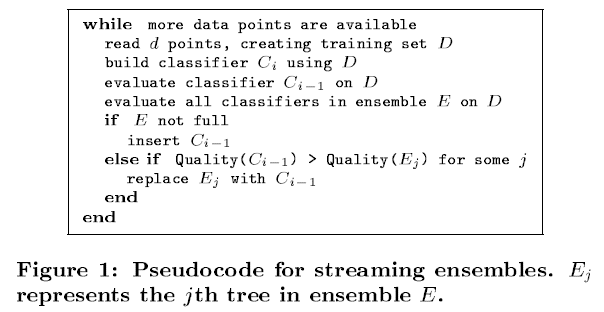

## Reacting to Different Types of Concept Drift:The Accuracy Updated Ensemble Algorithm (AUE2)

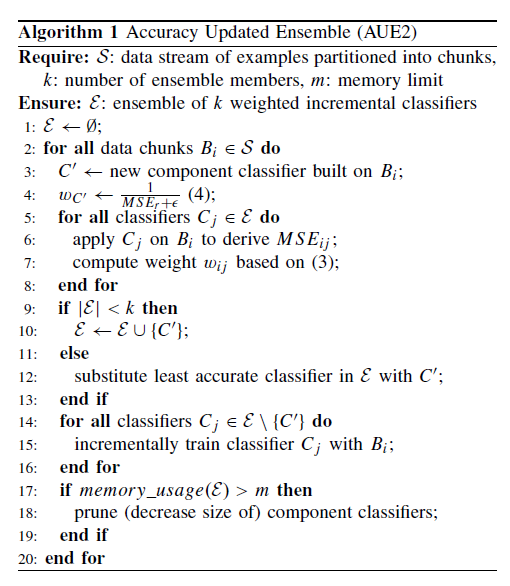

## Concept Drift Adaptation by Exploiting HistoricalKnowledge (DTEL)

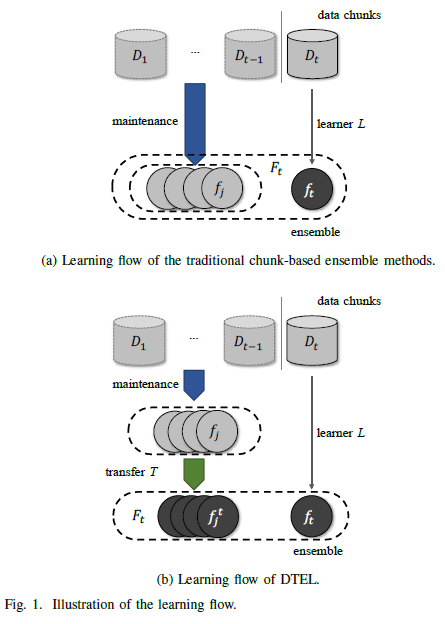

## Generative-CDTL

+ 사실 입력 $x_i$ 에서 어떤 feature가 시간에 따라 importance가 변하는지 알기 어렵다. trainset의 경우, bucket size가 크지 않을 수 있으며, 또한 I(z,b)가 분명하게 나타나지 않을 수도 있기 때문이다.
+ 따라서 아래와 같은 구조를 제안한다.
+ 실험3~4는 sensitive featrue z에 대해, G(z,b)으로 전처리 하였으나, 이번 구조는 모든 feature에 대하여 $G(x_i,b)$으로 전처리한다.
+ $I(x_i,b) > 0$ 인 feature는 G에 의해 전처리 될 것이고,$I(x_j,b) = 0$ 인 feature는 G에 의해 by-pass 되도록 학습될 것이다.

<pre>
x0 ------>|                     |- x'0 --> |                        |
x1 ------>|  Generator G(xi,b)  |- x'1 --> |                        |
x2 ------>|  (Adaptive model)   |- x'2 --> | Discriminator (D(x,g)) | -> y^
x3 ------>|                     |- x'3 --> | predictive model       |
z0 ------>|                     |- z'0 --> |                        |
                     ^
                     |
                     b
</pre>

$$
b = \{1,2,3,...N\} \in B
$$
$$
N << M
$$
$$
b_{norm} = b/M
\tag{17}
$$
$$
L_D = H(y,\hat{y}) = H(y,D(G(x_i,b_{norm})))=\mathbb{E}_{y}[-log(D(G(x_i,b_{norm})))]
\tag{21}
$$

$$
L_G = \sum_{i}MSE(G(x_i,b_{norm}),x_i)
\tag{22}
$$

$$
\min_{G(.)} L_D + L_G
\tag{23}
$$

$$
\min_{G(.)} L_D + L_G+ std(L_1,L_2)
\tag{24}
$$

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )

+ $P_t(y,X) \ne P_{t+w}(y,X) $ 이고 $P_t(y|X) \ne P_{t+w}(y|X) $
+ Real concept drift
+ 즉, P(y|X)와 P(X)의 변화가 연관되어 나타남.
+ 이때 대상 feature z에 대해서 MI 감소, ks-test 통계량 증가



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [24]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [25]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [26]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.48it/s]


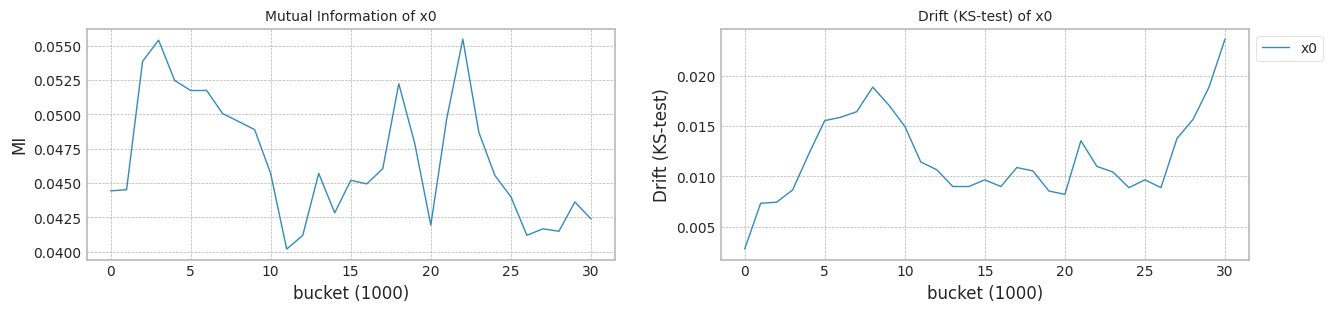

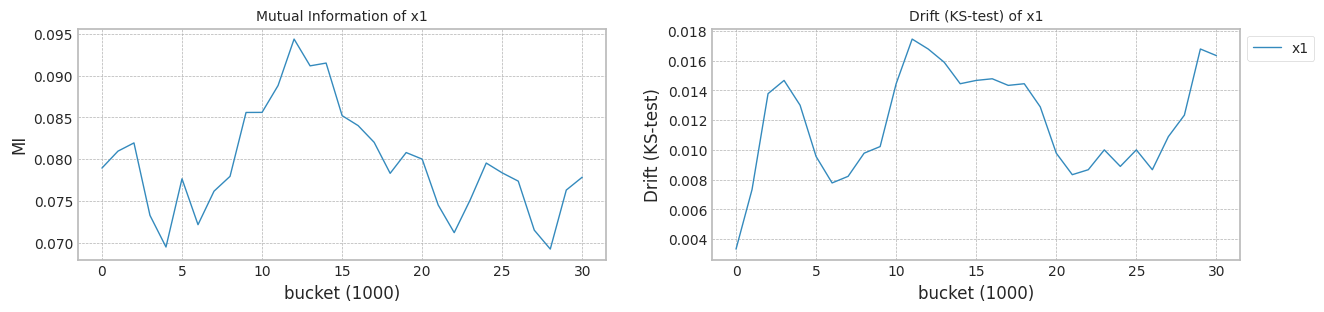

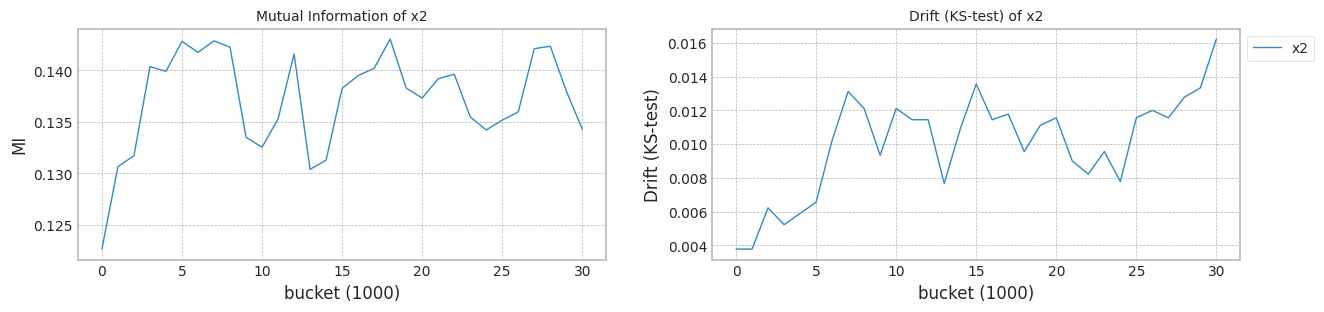

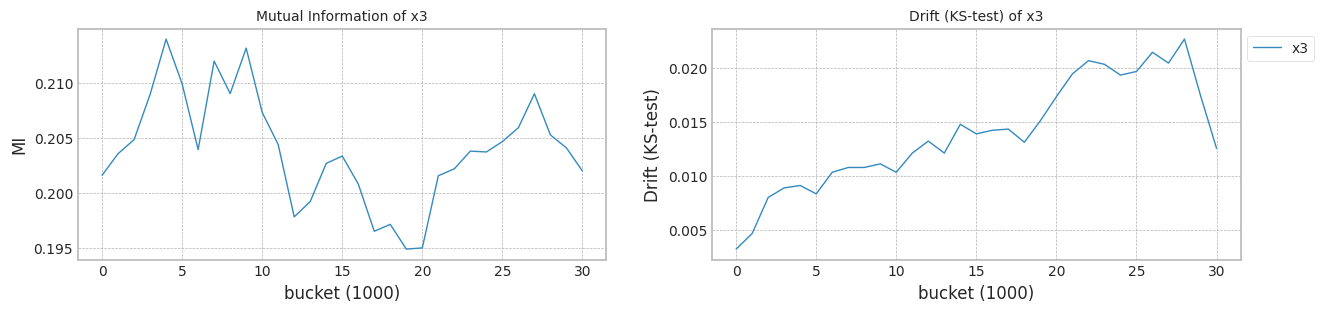

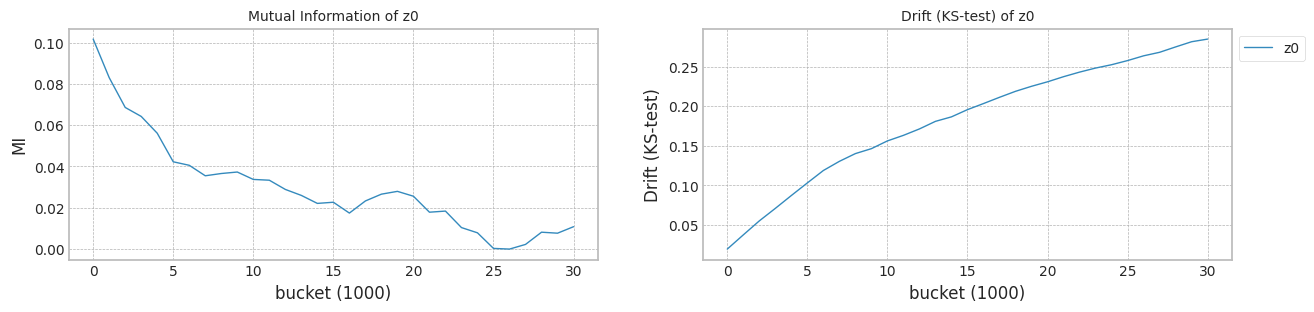

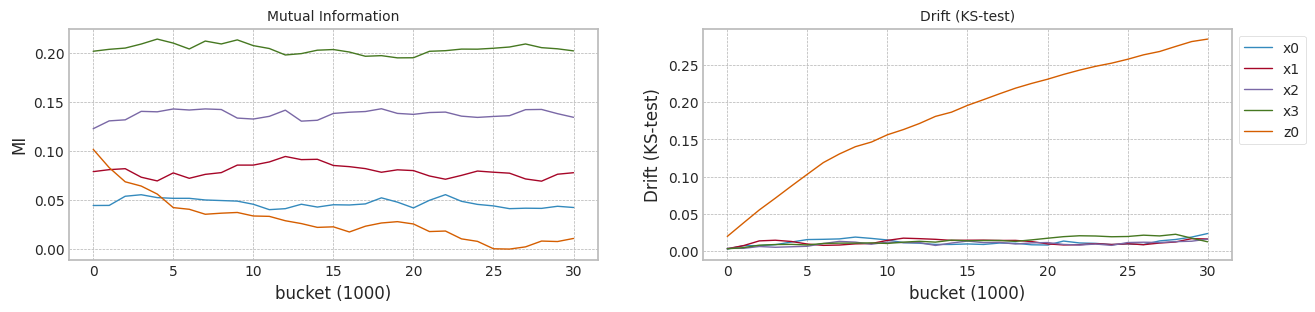

In [27]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [42]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.366139   0
1      0.610533  0.420412  0.508390  0.580336  0.662926   0
2      0.556874  0.464734  0.669603  0.724770  0.486574   0
3      0.344341  0.646524  0.340976  0.528780  0.611850   0
4      0.503142  0.550860  0.598773  0.465698  0.487044   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.709407  39
39996  0.358451  0.483875  0.341855  0.574439  0.695384  39
39997  0.559469  0.343824  0.542547  0.575250  0.504288  39
39998  0.433692  0.530132  0.301231  0.282353  0.762158  39
39999  0.538629  0.637825  0.358726  0.768301  0.522435  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 634.43it/s]


Test f1 score: 0.9909926993457855
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989694761955246
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 245.73it/s]


Test f1 score: 0.9954215948111408
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.16it/s]


mean of drift:
x0    0.054143
x1    0.036125
x2    0.029222
x3    0.106047
z0    0.112090
dtype: float64
Mean F1 for all data: 0.930530639925817
Normal model median        : 0.8989694761955246
Drift tolerant model median: 0.930530639925817
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 622.92it/s]


Test f1 score: 0.9909875723365904
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989576249229013
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.10it/s]


Test f1 score: 0.9979087452471483
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.09it/s]


mean of drift:
x0    0.071760
x1    0.071792
x2    0.075953
x3    0.052394
z0    0.094756
dtype: float64
Mean F1 for all data: 0.9457022958842308
Normal model median        : 0.898963550559213
Drift tolerant model median: 0.9381164679050239
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 627.42it/s]


Test f1 score: 0.9908013276434329
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.08it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8983627661702751
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 245.06it/s]


Test f1 score: 0.9970563099420758
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


mean of drift:
x0    0.138265
x1    0.037082
x2    0.018495
x3    0.058903
z0    0.073079
dtype: float64
Mean F1 for all data: 0.9196330961202115
Normal model median        : 0.8989576249229013
Drift tolerant model median: 0.930530639925817
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 630.86it/s]


Test f1 score: 0.9909944070528012
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988337822823614
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.79it/s]


Test f1 score: 0.9971477467199088
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.082111
x1    0.031552
x2    0.023423
x3    0.070491
z0    0.176903
dtype: float64
Mean F1 for all data: 0.916060767492406
Normal model median        : 0.8988957036026314
Drift tolerant model median: 0.9250818680230142
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 635.63it/s]


Test f1 score: 0.9909021986353299
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8991451389878478
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.21it/s]


Test f1 score: 0.997047900199981
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.074652
x1    0.021498
x2    0.026355
x3    0.350115
z0    0.080663
dtype: float64
Mean F1 for all data: 0.949159770356253
Normal model median        : 0.8989576249229013
Drift tolerant model median: 0.930530639925817
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 616.76it/s]


Test f1 score: 0.9911823267279796
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8991650213207394
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 245.33it/s]


Test f1 score: 0.9980039920159681
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.059753
x1    0.016677
x2    0.145004
x3    0.066176
z0    0.116846
dtype: float64
Mean F1 for all data: 0.916672743643268
Normal model median        : 0.898963550559213
Drift tolerant model median: 0.9250818680230142
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 619.20it/s]


Test f1 score: 0.990990990990991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8985478463360144
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.13it/s]


Test f1 score: 0.9980024731285075
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.081441
x1    0.024373
x2    0.027215
x3    0.068265
z0    0.188258
dtype: float64
Mean F1 for all data: 0.9310425856719159
Normal model median        : 0.8989576249229013
Drift tolerant model median: 0.930530639925817
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 640.92it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988895462608276
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.96it/s]


Test f1 score: 0.9979107312440645
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.12it/s]


mean of drift:
x0    0.073079
x1    0.016265
x2    0.012409
x3    0.357746
z0    0.068373
dtype: float64
Mean F1 for all data: 0.9393211935492665
Normal model median        : 0.8989235855918645
Drift tolerant model median: 0.9307866127988664
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 616.83it/s]


Test f1 score: 0.990990990990991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8986867650821286
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.62it/s]


Test f1 score: 0.997148288973384
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.14it/s]


mean of drift:
x0    0.072444
x1    0.013477
x2    0.070427
x3    0.361387
z0    0.081581
dtype: float64
Mean F1 for all data: 0.9485885825879513
Normal model median        : 0.8988895462608276
Drift tolerant model median: 0.9310425856719159
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 637.70it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.898833701553643
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.29it/s]


Test f1 score: 0.9980977743960433
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.091577
x1    0.026495
x2    0.014885
x3    0.056290
z0    0.089122
dtype: float64
Mean F1 for all data: 0.9391300705641823
Normal model median        : 0.8988616642715945
Drift tolerant model median: 0.935086328118049
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 625.33it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.01it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988908726445222
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.13it/s]


Test f1 score: 0.9964832240281342
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.092427
x1    0.032111
x2    0.022599
x3    0.017054
z0    0.115333
dtype: float64
Mean F1 for all data: 0.9286757297764378
Normal model median        : 0.8988895462608276
Drift tolerant model median: 0.9310425856719159
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 626.13it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989276516057924
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.44it/s]


Test f1 score: 0.9977164605137964
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.087677
x1    0.050194
x2    0.022165
x3    0.065455
z0    0.154301
dtype: float64
Mean F1 for all data: 0.9014969968369391
Normal model median        : 0.898890209452675
Drift tolerant model median: 0.9307866127988664
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 593.65it/s]


Test f1 score: 0.9912796208530807
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8984573478541628
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.70it/s]


Test f1 score: 0.9971493728620296
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.114057
x1    0.230907
x2    0.091272
x3    0.399470
z0    0.042247
dtype: float64
Mean F1 for all data: 0.9469718018817121
Normal model median        : 0.8988895462608276
Drift tolerant model median: 0.9310425856719159
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 627.65it/s]


Test f1 score: 0.990990990990991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.12it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.898718747043126
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.40it/s]


Test f1 score: 0.9973384030418251
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.14it/s]


mean of drift:
x0    0.065219
x1    0.040513
x2    0.064430
x3    0.070297
z0    0.127728
dtype: float64
Mean F1 for all data: 0.9245413049152086
Normal model median        : 0.8988616642715945
Drift tolerant model median: 0.9307866127988664
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 602.14it/s]


Test f1 score: 0.9907978370173609
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.96it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8987939636379492
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.41it/s]


Test f1 score: 0.9970495859902921
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.085118
x1    0.084412
x2    0.059552
x3    0.086419
z0    0.052201
dtype: float64
Mean F1 for all data: 0.9396517227023009
Normal model median        : 0.8988337822823614
Drift tolerant model median: 0.9310425856719159
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 625.92it/s]


Test f1 score: 0.991088357982556
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988315606449967
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.84it/s]


Test f1 score: 0.9977173292752521
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


mean of drift:
x0    0.086111
x1    0.076846
x2    0.022710
x3    0.025082
z0    0.097513
dtype: float64
Mean F1 for all data: 0.9376049732900023
Normal model median        : 0.8988337419180021
Drift tolerant model median: 0.9343237794809591
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 603.63it/s]


Test f1 score: 0.991088357982556
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.02it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988738455974927
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.39it/s]


Test f1 score: 0.9982886480319452
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.92it/s]


mean of drift:
x0    0.112452
x1    0.180072
x2    0.018208
x3    0.125652
z0    0.033480
dtype: float64
Mean F1 for all data: 0.9285038531522269
Normal model median        : 0.8988337822823614
Drift tolerant model median: 0.9310425856719159
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 617.72it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989276516057924
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.56it/s]


Test f1 score: 0.9980970504281638
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.072022
x1    0.019792
x2    0.021925
x3    0.045545
z0    0.113172
dtype: float64
Mean F1 for all data: 0.9389830244463548
Normal model median        : 0.8988538139399271
Drift tolerant model median: 0.9343237794809591
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 601.93it/s]


Test f1 score: 0.9909926993457855
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989858533673062
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.31it/s]


Test f1 score: 0.9972477934896079
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.05it/s]


mean of drift:
x0    0.069011
x1    0.034247
x2    0.014986
x3    0.029068
z0    0.216090
dtype: float64
Mean F1 for all data: 0.8862352369747032
Normal model median        : 0.8988738455974927
Drift tolerant model median: 0.9310425856719159
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 634.19it/s]


Test f1 score: 0.9912779673871825
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8986012371576424
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 246.33it/s]


Test f1 score: 0.9971515381693885
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


mean of drift:
x0    0.087978
x1    0.069111
x2    0.033624
x3    0.140885
z0    0.070086
dtype: float64
Mean F1 for all data: 0.9207472632294788
Normal model median        : 0.8988538139399271
Drift tolerant model median: 0.9307866127988664
######################### Trial 0 for Normal model ###########################
retrain_interval: 16
######################### Trial 0 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Early stop at  3573.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9309463667023609
SEA median: 0.9309463667023609
######################### Trial 0 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


Early stop at  2322.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9097208364392462
AUE median: 0.9097208364392462
######################### Trial 0 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


Early stop at  3115.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514902196024267
DTEL median: 0.9514902196024267
######################### Trial 1 for Normal model ###########################
retrain_interval: 16
######################### Trial 1 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9257962299056034
SEA median: 0.9283712983039821
######################### Trial 1 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Early stop at  3968.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9106046587123494
AUE median: 0.9101627475757978
######################### Trial 1 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515241973481674
DTEL median: 0.9515072084752971
######################### Trial 2 for Normal model ###########################
retrain_interval: 16
######################### Trial 2 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9381108598117645
SEA median: 0.9309463667023609
######################### Trial 2 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


Early stop at  3464.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9140436936936527
AUE median: 0.9106046587123494
######################### Trial 2 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512303680791537
DTEL median: 0.9514902196024267
######################### Trial 3 for Normal model ###########################
retrain_interval: 16
######################### Trial 3 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9277274277114619
SEA median: 0.9293368972069114
######################### Trial 3 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.24it/s]


Early stop at  2990.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9085666258101525
AUE median: 0.9101627475757978
######################### Trial 3 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]


Early stop at  3467.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512249698255482
DTEL median: 0.9513602938407902
######################### Trial 4 for Normal model ###########################
retrain_interval: 16
######################### Trial 4 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9283827888250555
SEA median: 0.9283827888250555
######################### Trial 4 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Early stop at  3740.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9092933544872154
AUE median: 0.9097208364392462
######################### Trial 4 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515105157978611
DTEL median: 0.9514902196024267
######################### Trial 5 for Normal model ###########################
retrain_interval: 16
######################### Trial 5 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Early stop at  3891.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9318035282781786
SEA median: 0.9296645777637083
######################### Trial 5 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.11it/s]


Early stop at  3067.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9104369022707499
AUE median: 0.910078869354998
######################### Trial 5 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9513181594246249
DTEL median: 0.9514041895135259
######################### Trial 6 for Normal model ###########################
retrain_interval: 16
######################### Trial 6 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.16it/s]


Early stop at  3276.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9371146464350808
SEA median: 0.9309463667023609
######################### Trial 6 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.28it/s]


Early stop at  2737.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9144337716984197
AUE median: 0.9104369022707499
######################### Trial 6 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.27it/s]


Early stop at  2366.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512486630616498
DTEL median: 0.9513181594246249
######################### Trial 7 for Normal model ###########################
retrain_interval: 16
######################### Trial 7 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9329922604319935
SEA median: 0.9313749474902697
######################### Trial 7 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Early stop at  3446.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9107278298502366
AUE median: 0.9105207804915496
######################### Trial 7 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515037187734162
DTEL median: 0.9514041895135259
######################### Trial 8 for Normal model ###########################
retrain_interval: 16
######################### Trial 8 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.98it/s]


Early stop at  3692.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9277324886315863
SEA median: 0.9309463667023609
######################### Trial 8 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.38it/s]


Early stop at  2752.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9084256574023943
AUE median: 0.9104369022707499
######################### Trial 8 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512894745629367
DTEL median: 0.9513181594246249
######################### Trial 9 for Normal model ###########################
retrain_interval: 16
######################### Trial 9 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.88it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9343642786988927
SEA median: 0.9313749474902697
######################### Trial 9 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.29it/s]


Early stop at  2683.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9094405310969753
AUE median: 0.910078869354998
######################### Trial 9 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.95it/s]


Early stop at  3579.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514928668300657
DTEL median: 0.9514041895135259
######################### Trial 10 for Normal model ###########################
retrain_interval: 16
######################### Trial 10 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.927036564860547
SEA median: 0.9309463667023609
######################### Trial 10 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.11it/s]


Early stop at  3231.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9091981533621097
AUE median: 0.9097208364392462
######################### Trial 10 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.18it/s]


Early stop at  2964.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.951437925567367
DTEL median: 0.951437925567367
######################### Trial 11 for Normal model ###########################
retrain_interval: 16
######################### Trial 11 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.93022820898907
SEA median: 0.9305872878457154
######################### Trial 11 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.08it/s]


Early stop at  3248.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9021566187239004
AUE median: 0.9095806837681107
######################### Trial 11 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.18it/s]


Early stop at  2913.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515231083015899
DTEL median: 0.9514640725848968
######################### Trial 12 for Normal model ###########################
retrain_interval: 16
######################### Trial 12 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9343315037082549
SEA median: 0.9309463667023609
######################### Trial 12 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9120804932149065
AUE median: 0.9097208364392462
######################### Trial 12 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.94it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9510417722044734
DTEL median: 0.951437925567367
######################### Trial 13 for Normal model ###########################
retrain_interval: 16
######################### Trial 13 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9314260400809835
SEA median: 0.9311862033916722
######################### Trial 13 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.14it/s]


Early stop at  3307.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9086475238894708
AUE median: 0.9095806837681107
######################### Trial 13 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


Early stop at  3181.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9513833847077383
DTEL median: 0.9514106551375526
######################### Trial 14 for Normal model ###########################
retrain_interval: 16
######################### Trial 14 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9227201409616949
SEA median: 0.9309463667023609
######################### Trial 14 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.16it/s]


Early stop at  3077.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9090579567070066
AUE median: 0.9094405310969753
######################### Trial 14 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.97it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514861017157081
DTEL median: 0.951437925567367
######################### Trial 15 for Normal model ###########################
retrain_interval: 16
######################### Trial 15 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Early stop at  3954.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9252823880518956
SEA median: 0.9305872878457154
######################### Trial 15 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.42it/s]


Early stop at  2625.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9071654388335244
AUE median: 0.9093669427920954
######################### Trial 15 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515943406091751
DTEL median: 0.9514620136415375
######################### Trial 16 for Normal model ###########################
retrain_interval: 16
######################### Trial 16 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9260325324887183
SEA median: 0.93022820898907
######################### Trial 16 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9096878276403941
AUE median: 0.9094405310969753
######################### Trial 16 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514856768813698
DTEL median: 0.9514856768813698
######################### Trial 17 for Normal model ###########################
retrain_interval: 16
######################### Trial 17 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9312215566901662
SEA median: 0.9305872878457154
######################### Trial 17 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.36it/s]


Early stop at  2679.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9095177485508077
AUE median: 0.9094791398238915
######################### Trial 17 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.97it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514484837173798
DTEL median: 0.9514670802993748
######################### Trial 18 for Normal model ###########################
retrain_interval: 16
######################### Trial 18 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.10it/s]


Early stop at  3391.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.928938803522992
SEA median: 0.93022820898907
######################### Trial 18 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.13it/s]


Early stop at  3317.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9098043370757661
AUE median: 0.9095177485508077
######################### Trial 18 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.951620174973492
DTEL median: 0.9514856768813698
######################### Trial 19 for Normal model ###########################
retrain_interval: 16
######################### Trial 19 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9280237736208783
SEA median: 0.9295835062560309
######################### Trial 19 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.11it/s]


Early stop at  3473.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.908201814198592
AUE median: 0.9094791398238915
######################### Trial 19 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


Early stop at  3387.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9510162046058817
DTEL median: 0.9514670802993748


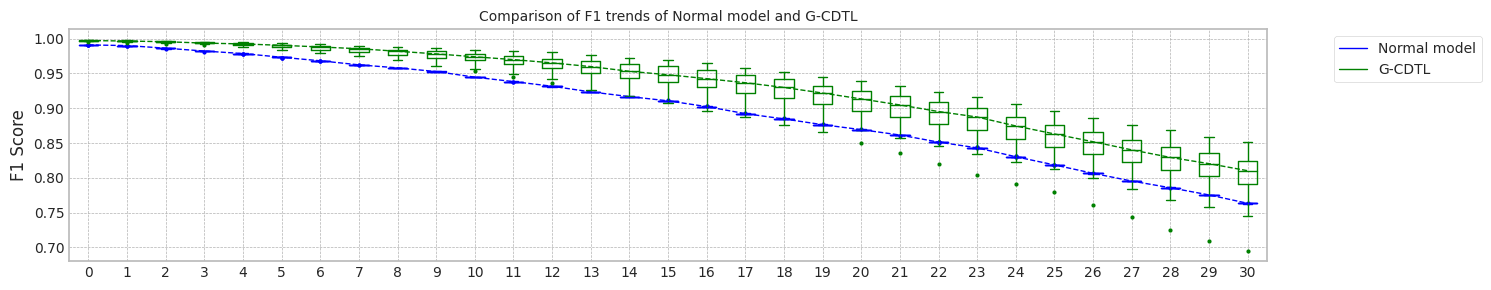

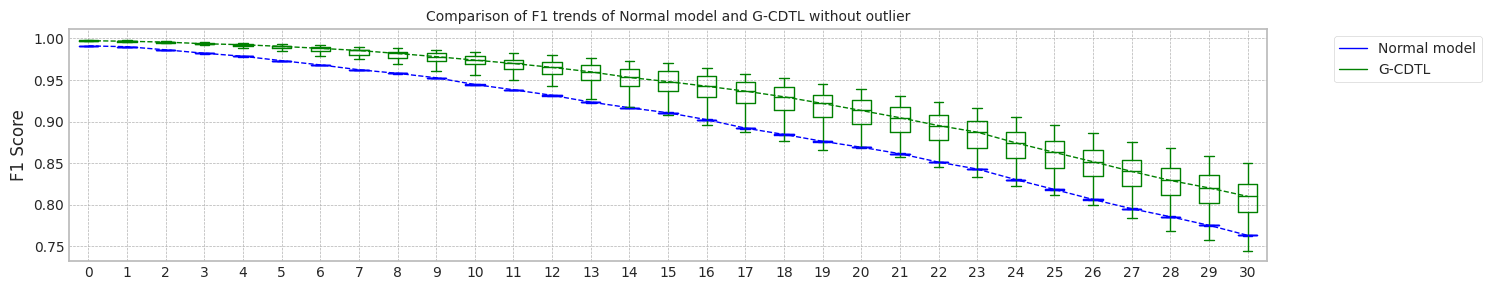

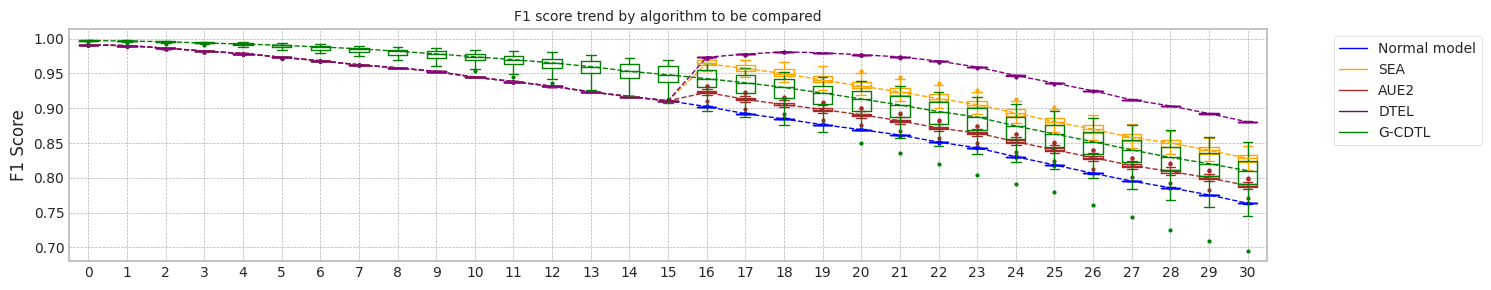

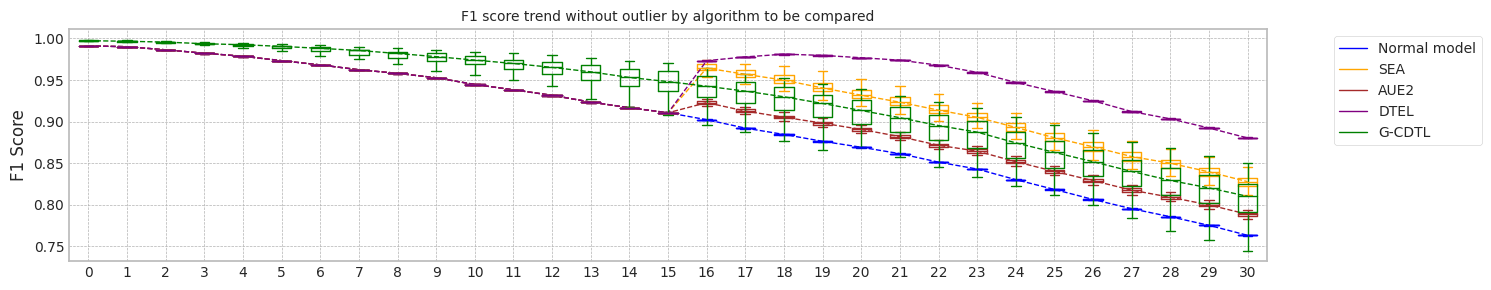

max_mean_trial= 4


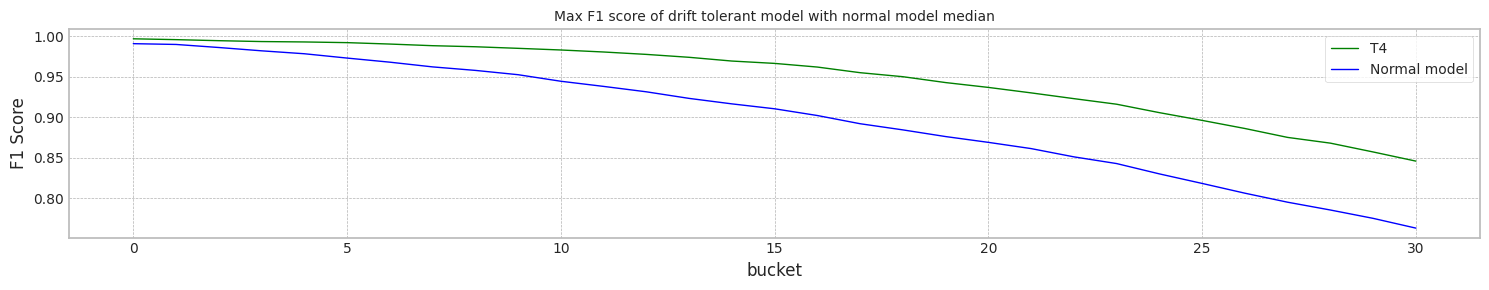

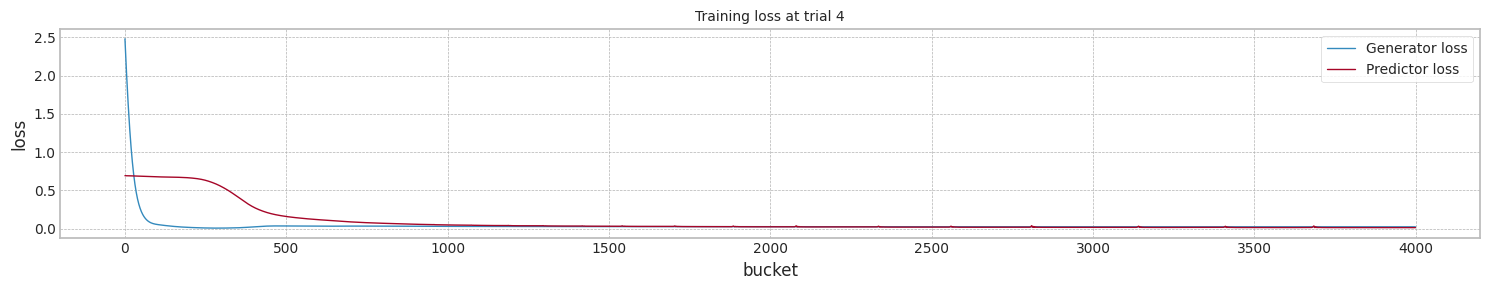

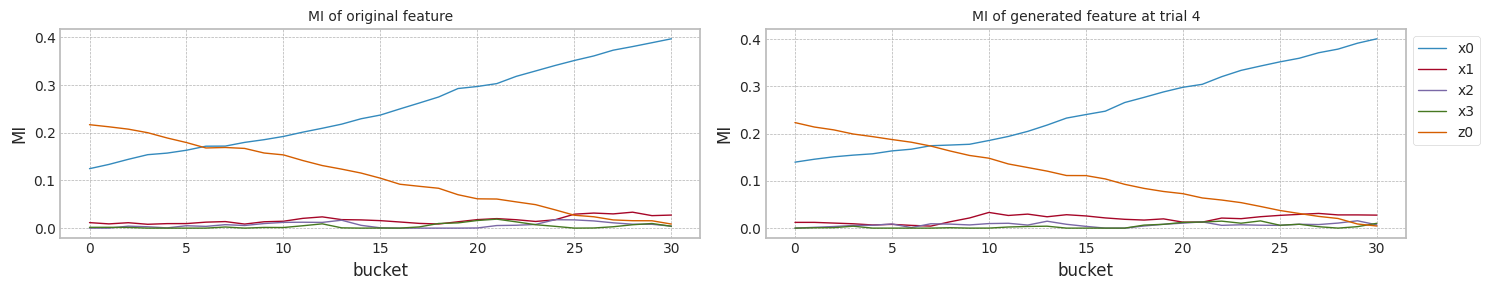

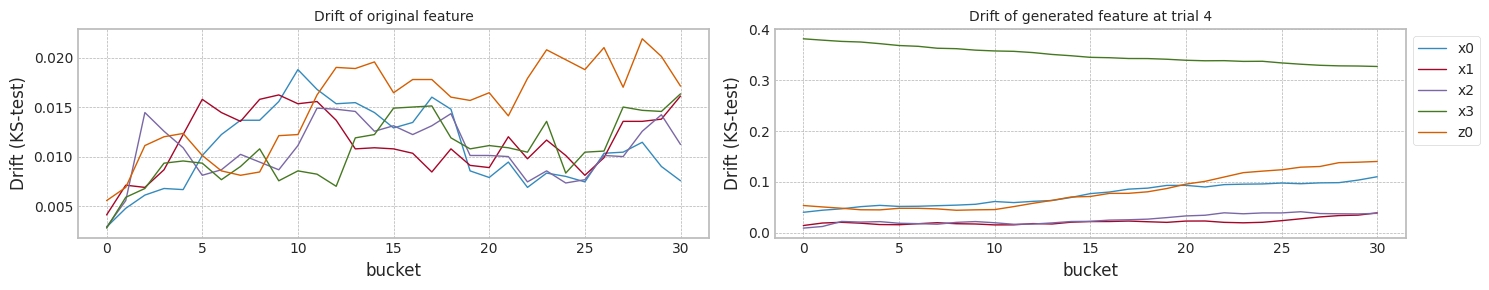

@ Normal model


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.898969  0.763477      6.123658
1      1.0    0.990988    0.990165  0.898958  0.763328      5.802918
2      2.0    0.990801    0.989597  0.898363  0.763009      6.143252
3      3.0    0.990994    0.989981  0.898834  0.763397      5.908319
4      4.0    0.990902    0.989794  0.899145  0.763754      6.088114
5      5.0    0.991182    0.989504  0.899165  0.763975      5.965379
6      6.0    0.990991    0.989880  0.898548  0.763139      6.263865
7      7.0    0.991087    0.990073  0.898890  0.763427      5.904452
8      8.0    0.990991    0.990073  0.898687  0.763158      6.121047
9      9.0    0.991087    0.990073  0.898834  0.763427      5.993229
10    10.0    0.991087    0.990073  0.898891  0.763348      6.235361
11    11.0    0.991087    0.990073  0.898928  0.763427      5.849399
12    12.0    0.991280    0.989693  0.898457  0.763108      6.282089
13    13.0    0.990991    0.990073  0.898719  0.763238      6.107224
14    14.0    0.990798    0.989974  0.898794  0.763119      6.306079
15    15.0    0.991088    0.990168  0.898832  0.763477      6.017961
16    16.0    0.991088    0.990168  0.898874  0.763636      6.220955
17    17.0    0.991087    0.990073  0.898928  0.763427      6.022819
18    18.0    0.990993    0.989979  0.898986  0.763348      6.203013
19    19.0    0.991278    0.990075  0.898601  0.763260      5.961309
20  median    0.991041    0.990073  0.898854  0.763372      6.097669
21     std    0.000126    0.000188  0.000208  0.000231      0.149577

@ SEA


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.930946  0.829274     10.935716
1      1.0    0.990988    0.990165  0.925796  0.819517     10.996749
2      2.0    0.990801    0.989597  0.938111  0.846009     11.238308
3      3.0    0.990994    0.989981  0.927727  0.824061     10.838162
4      4.0    0.990902    0.989794  0.928383  0.825621     11.123747
5      5.0    0.991182    0.989504  0.931804  0.831655     10.840294
6      6.0    0.990991    0.989880  0.937115  0.843567      9.874607
7      7.0    0.991087    0.990073  0.932992  0.833749     10.901217
8      8.0    0.990991    0.990073  0.927732  0.822664     10.439991
9      9.0    0.991087    0.990073  0.934364  0.836856     10.823740
10    10.0    0.991087    0.990073  0.927037  0.820018     10.846225
11    11.0    0.991087    0.990073  0.930228  0.829048     10.917472
12    12.0    0.991280    0.989693  0.934332  0.837810     10.982867
13    13.0    0.990991    0.990073  0.931426  0.830287     10.712327
14    14.0    0.990798    0.989974  0.922720  0.811944     10.605738
15    15.0    0.991088    0.990168  0.925282  0.819431     10.662830
16    16.0    0.991088    0.990168  0.926033  0.820535     10.713130
17    17.0    0.991087    0.990073  0.931222  0.830034     10.754344
18    18.0    0.990993    0.989979  0.928939  0.826738     10.037336
19    19.0    0.991278    0.990075  0.928024  0.824164     10.771734
20  median    0.991041    0.990073  0.929584  0.827893     10.830951
21     std    0.000126    0.000188  0.004015  0.008547      0.325354

@ AUE2


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.909721  0.788955      8.904566
1      1.0    0.990988    0.990165  0.910605  0.791137     10.978212
2      2.0    0.990801    0.989597  0.914044  0.798237     10.536728
3      3.0    0.990994    0.989981  0.908567  0.786969      9.620100
4      4.0    0.990902    0.989794  0.909293  0.788594     10.605960
5      5.0    0.991182    0.989504  0.910437  0.790607     10.009907
6      6.0    0.990991    0.989880  0.914434  0.799057      9.490129
7      7.0    0.991087    0.990073  0.910728  0.791060     10.288858
8      8.0    0.990991    0.990073  0.908426  0.786720      9.222878
9      9.0    0.991087    0.990073  0.909441  0.788582      9.451833
10    10.0    0.991087    0.990073  0.909198  0.788414      9.999912
11    11.0    0.991087    0.990073  0.902157  0.770831     10.106324
12    12.0    0.991280    0.989693  0.912080  0.793618     10.783351
13    13.0    0.990991    0.990073  0.908648  0.787219      9.922440
14    14.0    0.990798    0.989974  0.909058  0.788084      9.872915
15    15.0    0.991088    0.990168  0.907165  0.783478      9.098303
16    16.0    0.991088    0.990168  0.909688  0.789366     10.746070
17    17.0    0.991087    0.990073  0.909518  0.788706      9.262727
18    18.0    0.990993    0.989979  0.909804  0.789614      9.963534
19    19.0    0.991278    0.990075  0.908202  0.785847     10.017726
20  median    0.991041    0.990073  0.909479  0.788650      9.981723
21     std    0.000126    0.000188  0.002508  0.005634      0.594002

@ DTEL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.951490  0.880177     14.612848
1      1.0    0.990988    0.990165  0.951524  0.880274     16.228882
2      2.0    0.990801    0.989597  0.951230  0.880813     15.689188
3      3.0    0.990994    0.989981  0.951225  0.880371     15.256934
4      4.0    0.990902    0.989794  0.951511  0.880274     15.586980
5      5.0    0.991182    0.989504  0.951318  0.880239     16.122688
6      6.0    0.990991    0.989880  0.951249  0.880327     13.717827
7      7.0    0.991087    0.990073  0.951504  0.880513     16.130363
8      8.0    0.990991    0.990073  0.951289  0.880000     15.722204
9      9.0    0.991087    0.990073  0.951493  0.880671     15.914714
10    10.0    0.991087    0.990073  0.951438  0.880177     14.295167
11    11.0    0.991087    0.990073  0.951523  0.881210     14.275052
12    12.0    0.991280    0.989693  0.951042  0.880779     16.045073
13    13.0    0.990991    0.990073  0.951383  0.881255     14.598982
14    14.0    0.990798    0.989974  0.951486  0.880398     15.810424
15    15.0    0.991088    0.990168  0.951594  0.880468     15.360464
16    16.0    0.991088    0.990168  0.951486  0.880371     15.518689
17    17.0    0.991087    0.990073  0.951448  0.880124     15.803137
18    18.0    0.990993    0.989979  0.951620  0.881247     15.407010
19    19.0    0.991278    0.990075  0.951016  0.879894     15.177337
20  median    0.991041    0.990073  0.951467  0.880371     15.552835
21     std    0.000126    0.000188  0.000170  0.000400      0.711325

@ G-CDTL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.995422    0.994374  0.930531  0.809339      6.048965
1      1.0    0.997909    0.997340  0.945702  0.833841      6.136827
2      2.0    0.997056    0.996299  0.919633  0.778381      6.025135
3      3.0    0.997148    0.996293  0.916061  0.777992      5.882075
4      4.0    0.997048    0.996003  0.949160  0.846075      6.020188
5      5.0    0.998004    0.997439  0.916673  0.782943      5.958648
6      6.0    0.998002    0.996957  0.931043  0.811108      5.906587
7      7.0    0.997911    0.997153  0.939321  0.823449      6.100765
8      8.0    0.997148    0.996294  0.948589  0.850879      6.076001
9      9.0    0.998098    0.997243  0.939130  0.820595      5.942023
10    10.0    0.996483    0.995534  0.928676  0.802490      5.869037
11    11.0    0.997716    0.996384  0.901497  0.745024      6.094152
12    12.0    0.997149    0.996771  0.946972  0.836012      6.021580
13    13.0    0.997338    0.996580  0.924541  0.797373      6.081460
14    14.0    0.997050    0.996673  0.939652  0.814244      6.019594
15    15.0    0.997717    0.997149  0.937605  0.818781      6.009413
16    16.0    0.998289    0.997625  0.928504  0.797541      6.352315
17    17.0    0.998097    0.997147  0.938983  0.828431      6.091932
18    18.0    0.997248    0.996394  0.886235  0.695376      6.177918
19    19.0    0.997152    0.996492  0.920747  0.793661      6.028617
20  median    0.997293    0.996626  0.930787  0.810224      6.026876
21     std    0.000673    0.000747  0.016176  0.036107      0.109756

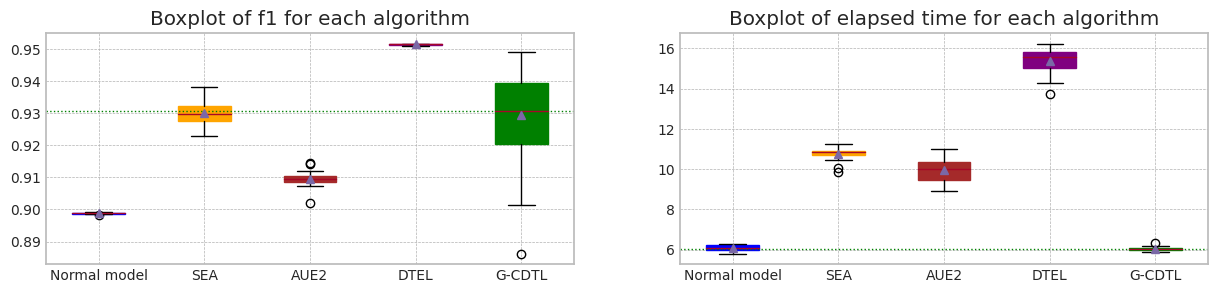

In [43]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ $P_t(y|X) \ne P_{t+w}(y|X)$ and $P_t(X) = P_{t+w}(X)$
+ Actual Drift
+ 즉, P(X)의 변화없이, Concept (본 Dataset에서 MI의 변화)만 변경


+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [30]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [31]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [32]:
x1.shape

(40000, 5)

In [33]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [34]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.59it/s]


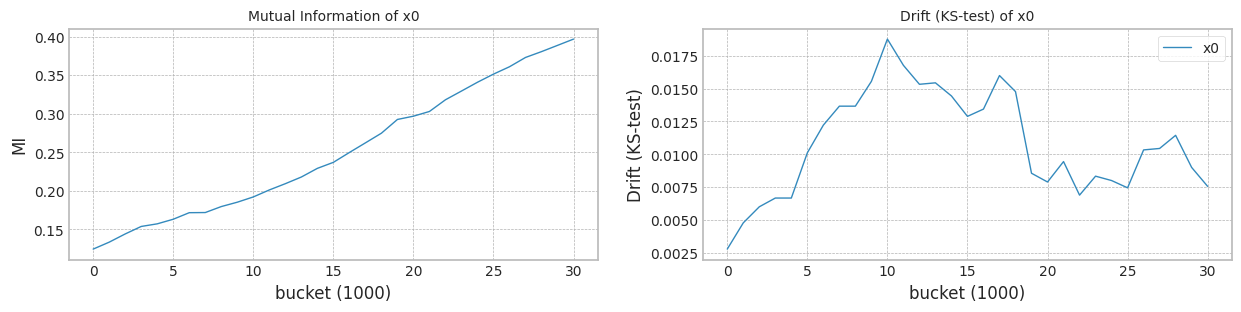

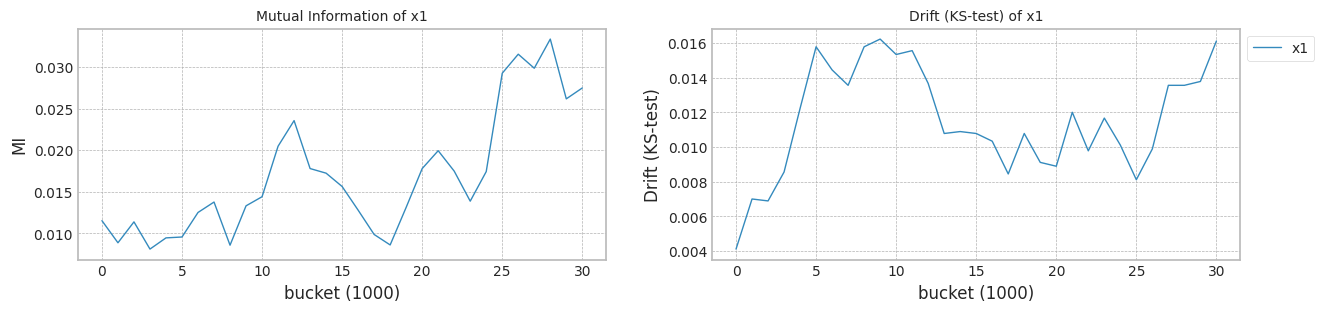

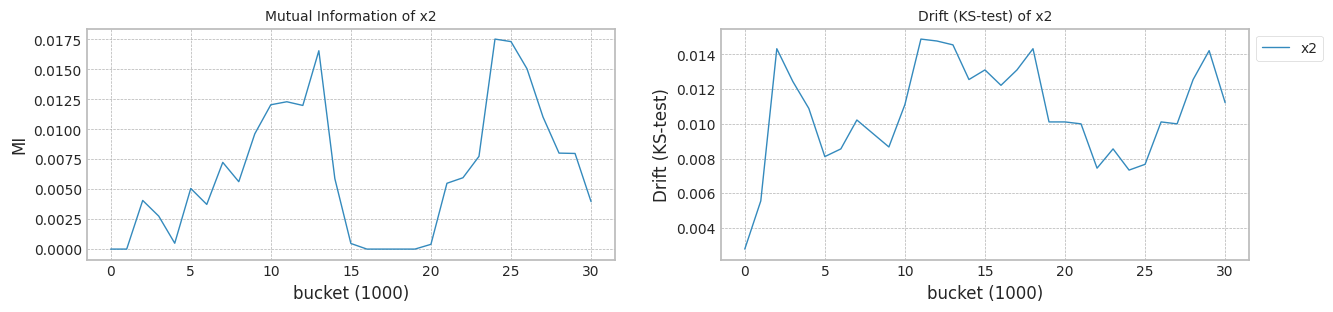

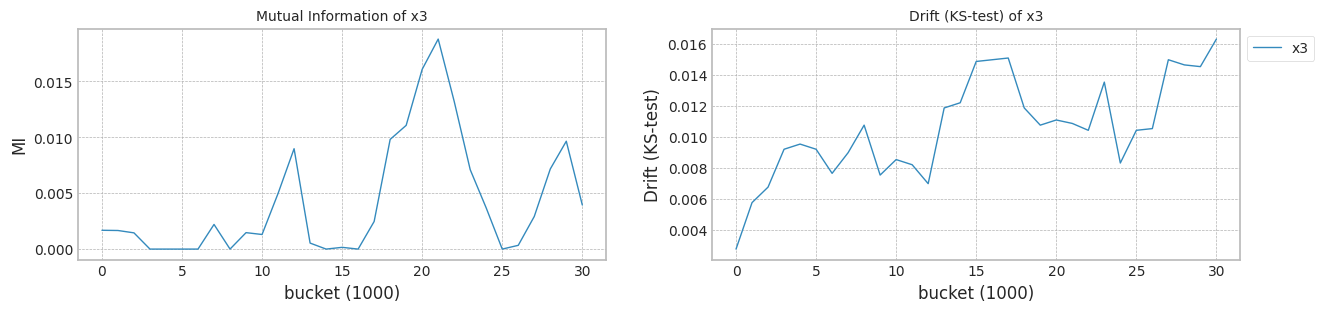

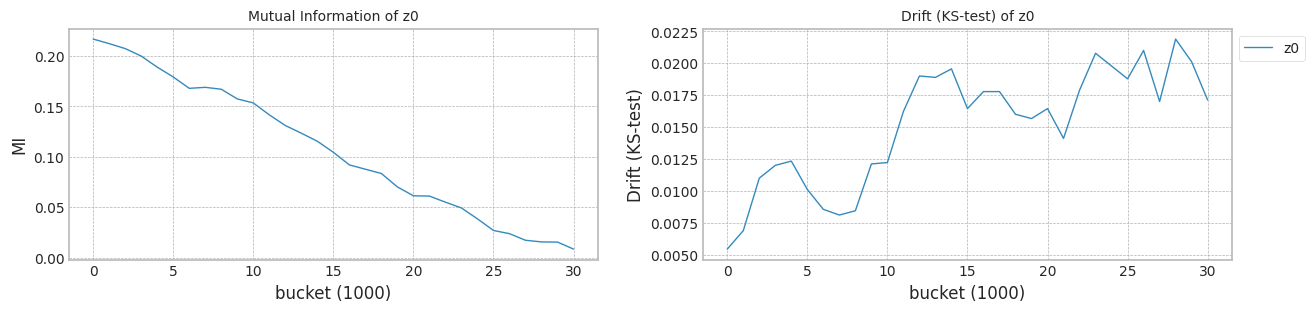

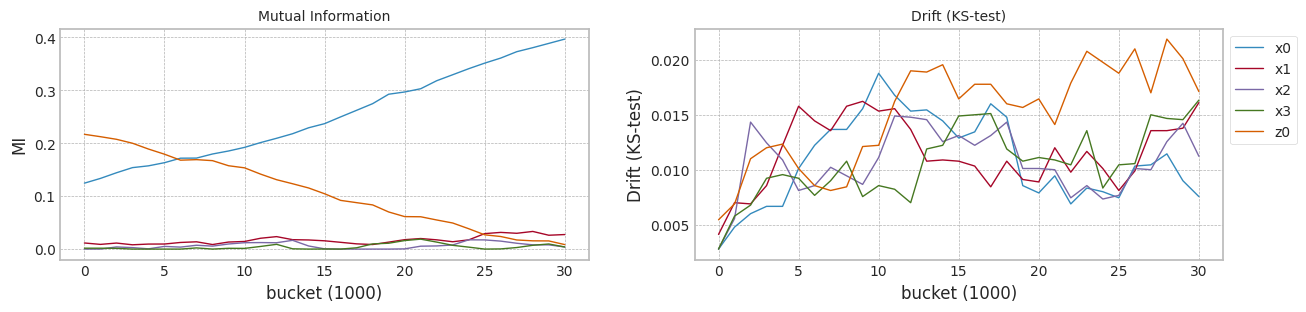

In [35]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [36]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.366139   0
1      0.610533  0.420412  0.508390  0.580336  0.662926   0
2      0.556874  0.464734  0.669603  0.724770  0.486574   0
3      0.344341  0.646524  0.340976  0.528780  0.611850   0
4      0.503142  0.550860  0.598773  0.465698  0.487044   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.709407  39
39996  0.358451  0.483875  0.341855  0.574439  0.695384  39
39997  0.559469  0.343824  0.542547  0.575250  0.504288  39
39998  0.433692  0.530132  0.301231  0.282353  0.762158  39
39999  0.538629  0.637825  0.358726  0.768301  0.522435  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 563.95it/s]


Test f1 score: 0.9909926993457855
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.75it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989694761955246
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.11it/s]


Test f1 score: 0.9954215948111408
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.054143
x1    0.036125
x2    0.029222
x3    0.106047
z0    0.112090
dtype: float64
Mean F1 for all data: 0.930530639925817
Normal model median        : 0.8989694761955246
Drift tolerant model median: 0.930530639925817
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 639.95it/s]


Test f1 score: 0.9909875723365904
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989576249229013
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.80it/s]


Test f1 score: 0.9979087452471483
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.071760
x1    0.071792
x2    0.075953
x3    0.052394
z0    0.094756
dtype: float64
Mean F1 for all data: 0.9457022958842308
Normal model median        : 0.898963550559213
Drift tolerant model median: 0.9381164679050239
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 640.53it/s]


Test f1 score: 0.9908013276434329
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8983627661702751
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 245.97it/s]


Test f1 score: 0.9970563099420758
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.138265
x1    0.037082
x2    0.018495
x3    0.058903
z0    0.073079
dtype: float64
Mean F1 for all data: 0.9196330961202115
Normal model median        : 0.8989576249229013
Drift tolerant model median: 0.930530639925817
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 637.06it/s]


Test f1 score: 0.9909944070528012
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988337822823614
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 245.90it/s]


Test f1 score: 0.9971477467199088
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.082111
x1    0.031552
x2    0.023423
x3    0.070491
z0    0.176903
dtype: float64
Mean F1 for all data: 0.916060767492406
Normal model median        : 0.8988957036026314
Drift tolerant model median: 0.9250818680230142
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 599.62it/s]


Test f1 score: 0.9909021986353299
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8991451389878478
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.79it/s]


Test f1 score: 0.997047900199981
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.074652
x1    0.021498
x2    0.026355
x3    0.350115
z0    0.080663
dtype: float64
Mean F1 for all data: 0.949159770356253
Normal model median        : 0.8989576249229013
Drift tolerant model median: 0.930530639925817
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 660.44it/s]


Test f1 score: 0.9911823267279796
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8991650213207394
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 253.15it/s]


Test f1 score: 0.9980039920159681
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.059753
x1    0.016677
x2    0.145004
x3    0.066176
z0    0.116846
dtype: float64
Mean F1 for all data: 0.916672743643268
Normal model median        : 0.898963550559213
Drift tolerant model median: 0.9250818680230142
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 634.07it/s]


Test f1 score: 0.990990990990991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8985478463360144
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.29it/s]


Test f1 score: 0.9980024731285075
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.081441
x1    0.024373
x2    0.027215
x3    0.068265
z0    0.188258
dtype: float64
Mean F1 for all data: 0.9310425856719159
Normal model median        : 0.8989576249229013
Drift tolerant model median: 0.930530639925817
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 653.35it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988895462608276
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 253.43it/s]


Test f1 score: 0.9979107312440645
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.073079
x1    0.016265
x2    0.012409
x3    0.357746
z0    0.068373
dtype: float64
Mean F1 for all data: 0.9393211935492665
Normal model median        : 0.8989235855918645
Drift tolerant model median: 0.9307866127988664
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 645.47it/s]


Test f1 score: 0.990990990990991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8986867650821286
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 253.30it/s]


Test f1 score: 0.997148288973384
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.072444
x1    0.013477
x2    0.070427
x3    0.361387
z0    0.081581
dtype: float64
Mean F1 for all data: 0.9485885825879513
Normal model median        : 0.8988895462608276
Drift tolerant model median: 0.9310425856719159
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 657.12it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.898833701553643
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.42it/s]


Test f1 score: 0.9980977743960433
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.091577
x1    0.026495
x2    0.014885
x3    0.056290
z0    0.089122
dtype: float64
Mean F1 for all data: 0.9391300705641823
Normal model median        : 0.8988616642715945
Drift tolerant model median: 0.935086328118049
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 661.47it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988908726445222
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.73it/s]


Test f1 score: 0.9964832240281342
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.092427
x1    0.032111
x2    0.022599
x3    0.017054
z0    0.115333
dtype: float64
Mean F1 for all data: 0.9286757297764378
Normal model median        : 0.8988895462608276
Drift tolerant model median: 0.9310425856719159
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 661.02it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989276516057924
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 250.82it/s]


Test f1 score: 0.9977164605137964
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.087677
x1    0.050194
x2    0.022165
x3    0.065455
z0    0.154301
dtype: float64
Mean F1 for all data: 0.9014969968369391
Normal model median        : 0.898890209452675
Drift tolerant model median: 0.9307866127988664
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 655.21it/s]


Test f1 score: 0.9912796208530807
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8984573478541628
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.21it/s]


Test f1 score: 0.9971493728620296
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.114057
x1    0.230907
x2    0.091272
x3    0.399470
z0    0.042247
dtype: float64
Mean F1 for all data: 0.9469718018817121
Normal model median        : 0.8988895462608276
Drift tolerant model median: 0.9310425856719159
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 651.86it/s]


Test f1 score: 0.990990990990991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.16it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.898718747043126
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 252.94it/s]


Test f1 score: 0.9973384030418251
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.45it/s]


mean of drift:
x0    0.065219
x1    0.040513
x2    0.064430
x3    0.070297
z0    0.127728
dtype: float64
Mean F1 for all data: 0.9245413049152086
Normal model median        : 0.8988616642715945
Drift tolerant model median: 0.9307866127988664
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 641.66it/s]


Test f1 score: 0.9907978370173609
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8987939636379492
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 254.23it/s]


Test f1 score: 0.9970495859902921
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.085118
x1    0.084412
x2    0.059552
x3    0.086419
z0    0.052201
dtype: float64
Mean F1 for all data: 0.9396517227023009
Normal model median        : 0.8988337822823614
Drift tolerant model median: 0.9310425856719159
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 629.47it/s]


Test f1 score: 0.991088357982556
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988315606449967
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.27it/s]


Test f1 score: 0.9977173292752521
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.086111
x1    0.076846
x2    0.022710
x3    0.025082
z0    0.097513
dtype: float64
Mean F1 for all data: 0.9376049732900023
Normal model median        : 0.8988337419180021
Drift tolerant model median: 0.9343237794809591
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 615.95it/s]


Test f1 score: 0.991088357982556
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8988738455974927
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.69it/s]


Test f1 score: 0.9982886480319452
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.09it/s]


mean of drift:
x0    0.112452
x1    0.180072
x2    0.018208
x3    0.125652
z0    0.033480
dtype: float64
Mean F1 for all data: 0.9285038531522269
Normal model median        : 0.8988337822823614
Drift tolerant model median: 0.9310425856719159
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 656.91it/s]


Test f1 score: 0.9910866679309691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989276516057924
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 252.21it/s]


Test f1 score: 0.9980970504281638
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.072022
x1    0.019792
x2    0.021925
x3    0.045545
z0    0.113172
dtype: float64
Mean F1 for all data: 0.9389830244463548
Normal model median        : 0.8988538139399271
Drift tolerant model median: 0.9343237794809591
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 640.63it/s]


Test f1 score: 0.9909926993457855
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8989858533673062
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.22it/s]


Test f1 score: 0.9972477934896079
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.069011
x1    0.034247
x2    0.014986
x3    0.029068
z0    0.216090
dtype: float64
Mean F1 for all data: 0.8862352369747032
Normal model median        : 0.8988738455974927
Drift tolerant model median: 0.9310425856719159
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.65it/s]


Test f1 score: 0.9912779673871825
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8986012371576424
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.25it/s]


Test f1 score: 0.9971515381693885
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.087978
x1    0.069111
x2    0.033624
x3    0.140885
z0    0.070086
dtype: float64
Mean F1 for all data: 0.9207472632294788
Normal model median        : 0.8988538139399271
Drift tolerant model median: 0.9307866127988664
######################### Trial 0 for Normal model ###########################
retrain_interval: 16
######################### Trial 0 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Early stop at  3573.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9309463667023609
SEA median: 0.9309463667023609
######################### Trial 0 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.57it/s]


Early stop at  2322.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9097208364392462
AUE median: 0.9097208364392462
######################### Trial 0 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


Early stop at  3115.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514902196024267
DTEL median: 0.9514902196024267
######################### Trial 1 for Normal model ###########################
retrain_interval: 16
######################### Trial 1 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9257962299056034
SEA median: 0.9283712983039821
######################### Trial 1 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.88it/s]


Early stop at  3968.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9106046587123494
AUE median: 0.9101627475757978
######################### Trial 1 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515241973481674
DTEL median: 0.9515072084752971
######################### Trial 2 for Normal model ###########################
retrain_interval: 16
######################### Trial 2 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9381108598117645
SEA median: 0.9309463667023609
######################### Trial 2 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.06it/s]


Early stop at  3464.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9140436936936527
AUE median: 0.9106046587123494
######################### Trial 2 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512303680791537
DTEL median: 0.9514902196024267
######################### Trial 3 for Normal model ###########################
retrain_interval: 16
######################### Trial 3 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9277274277114619
SEA median: 0.9293368972069114
######################### Trial 3 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.29it/s]


Early stop at  2990.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9085666258101525
AUE median: 0.9101627475757978
######################### Trial 3 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


Early stop at  3467.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512249698255482
DTEL median: 0.9513602938407902
######################### Trial 4 for Normal model ###########################
retrain_interval: 16
######################### Trial 4 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9283827888250555
SEA median: 0.9283827888250555
######################### Trial 4 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


Early stop at  3740.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9092933544872154
AUE median: 0.9097208364392462
######################### Trial 4 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515105157978611
DTEL median: 0.9514902196024267
######################### Trial 5 for Normal model ###########################
retrain_interval: 16
######################### Trial 5 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Early stop at  3891.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9318035282781786
SEA median: 0.9296645777637083
######################### Trial 5 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.20it/s]


Early stop at  3067.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9104369022707499
AUE median: 0.910078869354998
######################### Trial 5 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9513181594246249
DTEL median: 0.9514041895135259
######################### Trial 6 for Normal model ###########################
retrain_interval: 16
######################### Trial 6 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.19it/s]


Early stop at  3276.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9371146464350808
SEA median: 0.9309463667023609
######################### Trial 6 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.36it/s]


Early stop at  2737.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9144337716984197
AUE median: 0.9104369022707499
######################### Trial 6 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.29it/s]


Early stop at  2366.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512486630616498
DTEL median: 0.9513181594246249
######################### Trial 7 for Normal model ###########################
retrain_interval: 16
######################### Trial 7 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9329922604319935
SEA median: 0.9313749474902697
######################### Trial 7 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.07it/s]


Early stop at  3446.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9107278298502366
AUE median: 0.9105207804915496
######################### Trial 7 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515037187734162
DTEL median: 0.9514041895135259
######################### Trial 8 for Normal model ###########################
retrain_interval: 16
######################### Trial 8 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.00it/s]


Early stop at  3692.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9277324886315863
SEA median: 0.9309463667023609
######################### Trial 8 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.37it/s]


Early stop at  2752.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9084256574023943
AUE median: 0.9104369022707499
######################### Trial 8 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9512894745629367
DTEL median: 0.9513181594246249
######################### Trial 9 for Normal model ###########################
retrain_interval: 16
######################### Trial 9 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9343642786988927
SEA median: 0.9313749474902697
######################### Trial 9 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.35it/s]


Early stop at  2683.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9094405310969753
AUE median: 0.910078869354998
######################### Trial 9 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Early stop at  3579.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514928668300657
DTEL median: 0.9514041895135259
######################### Trial 10 for Normal model ###########################
retrain_interval: 16
######################### Trial 10 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.927036564860547
SEA median: 0.9309463667023609
######################### Trial 10 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.10it/s]


Early stop at  3231.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9091981533621097
AUE median: 0.9097208364392462
######################### Trial 10 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


Early stop at  2964.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.951437925567367
DTEL median: 0.951437925567367
######################### Trial 11 for Normal model ###########################
retrain_interval: 16
######################### Trial 11 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.93022820898907
SEA median: 0.9305872878457154
######################### Trial 11 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.19it/s]


Early stop at  3248.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9021566187239004
AUE median: 0.9095806837681107
######################### Trial 11 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.19it/s]


Early stop at  2913.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515231083015899
DTEL median: 0.9514640725848968
######################### Trial 12 for Normal model ###########################
retrain_interval: 16
######################### Trial 12 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9343315037082549
SEA median: 0.9309463667023609
######################### Trial 12 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9120804932149065
AUE median: 0.9097208364392462
######################### Trial 12 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9510417722044734
DTEL median: 0.951437925567367
######################### Trial 13 for Normal model ###########################
retrain_interval: 16
######################### Trial 13 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9314260400809835
SEA median: 0.9311862033916722
######################### Trial 13 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.09it/s]


Early stop at  3307.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9086475238894708
AUE median: 0.9095806837681107
######################### Trial 13 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


Early stop at  3181.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9513833847077383
DTEL median: 0.9514106551375526
######################### Trial 14 for Normal model ###########################
retrain_interval: 16
######################### Trial 14 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9227201409616949
SEA median: 0.9309463667023609
######################### Trial 14 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.23it/s]


Early stop at  3077.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9090579567070066
AUE median: 0.9094405310969753
######################### Trial 14 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514861017157081
DTEL median: 0.951437925567367
######################### Trial 15 for Normal model ###########################
retrain_interval: 16
######################### Trial 15 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Early stop at  3954.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9252823880518956
SEA median: 0.9305872878457154
######################### Trial 15 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.48it/s]


Early stop at  2625.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9071654388335244
AUE median: 0.9093669427920954
######################### Trial 15 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9515943406091751
DTEL median: 0.9514620136415375
######################### Trial 16 for Normal model ###########################
retrain_interval: 16
######################### Trial 16 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9260325324887183
SEA median: 0.93022820898907
######################### Trial 16 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9096878276403941
AUE median: 0.9094405310969753
######################### Trial 16 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514856768813698
DTEL median: 0.9514856768813698
######################### Trial 17 for Normal model ###########################
retrain_interval: 16
######################### Trial 17 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.95it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9312215566901662
SEA median: 0.9305872878457154
######################### Trial 17 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.43it/s]


Early stop at  2679.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9095177485508077
AUE median: 0.9094791398238915
######################### Trial 17 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9514484837173798
DTEL median: 0.9514670802993748
######################### Trial 18 for Normal model ###########################
retrain_interval: 16
######################### Trial 18 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.10it/s]


Early stop at  3391.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.928938803522992
SEA median: 0.93022820898907
######################### Trial 18 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.08it/s]


Early stop at  3317.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9098043370757661
AUE median: 0.9095177485508077
######################### Trial 18 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.951620174973492
DTEL median: 0.9514856768813698
######################### Trial 19 for Normal model ###########################
retrain_interval: 16
######################### Trial 19 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9280237736208783
SEA median: 0.9295835062560309
######################### Trial 19 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.02it/s]


Early stop at  3473.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.908201814198592
AUE median: 0.9094791398238915
######################### Trial 19 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


Early stop at  3387.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9510162046058817
DTEL median: 0.9514670802993748


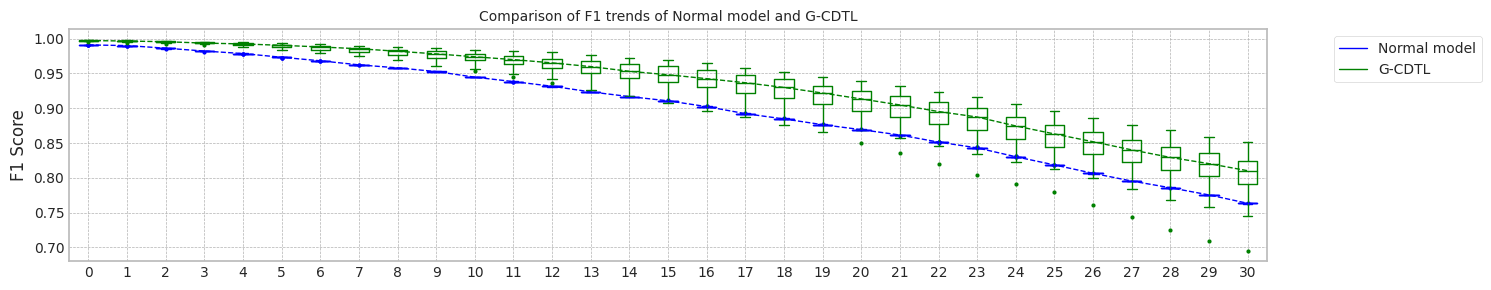

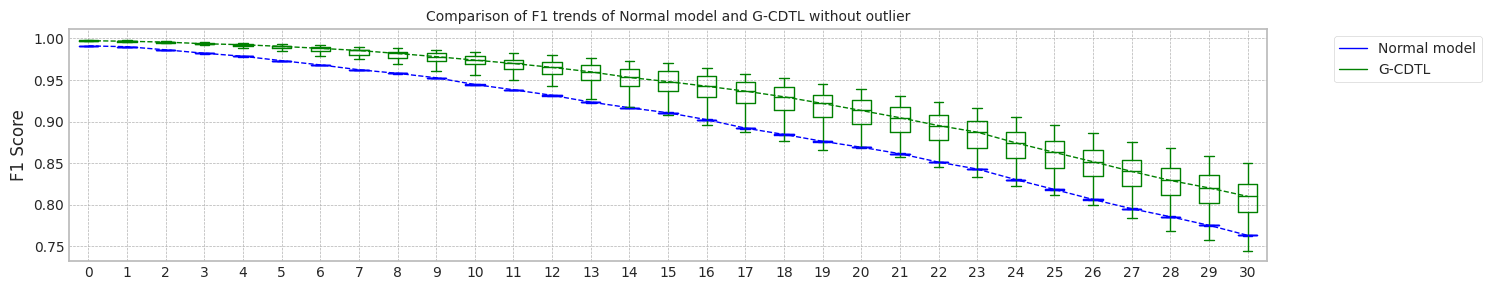

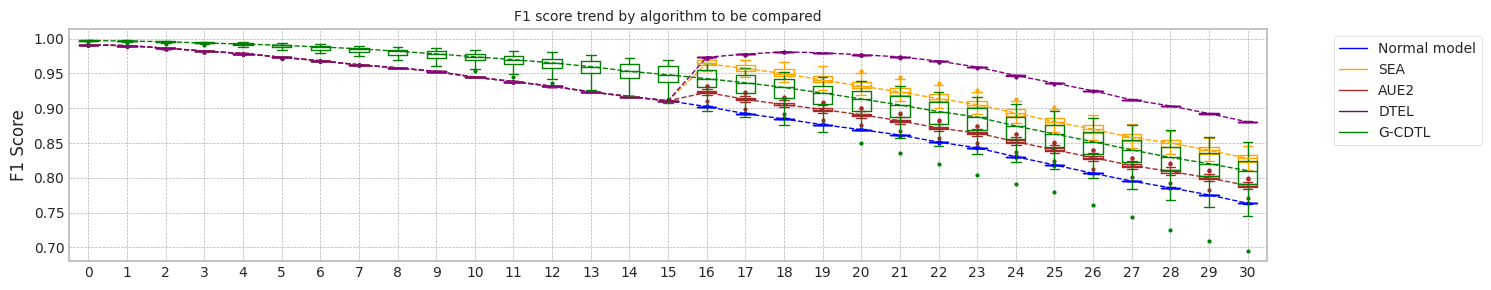

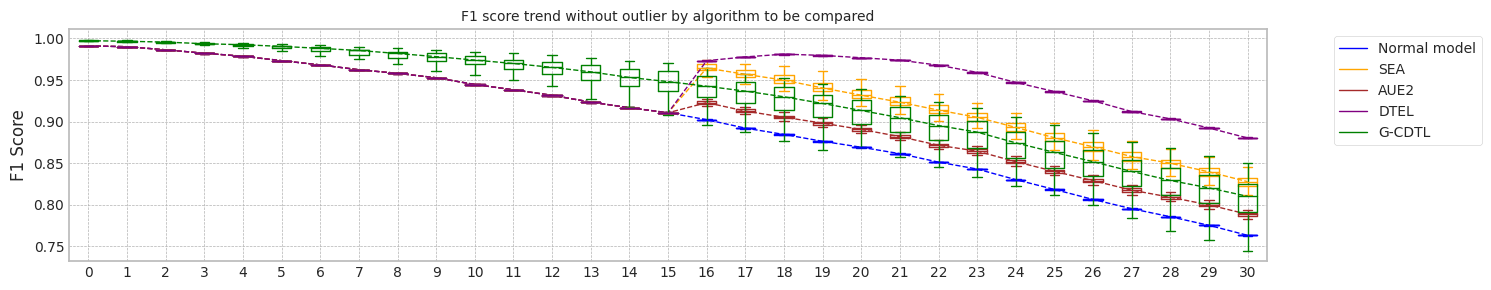

max_mean_trial= 4


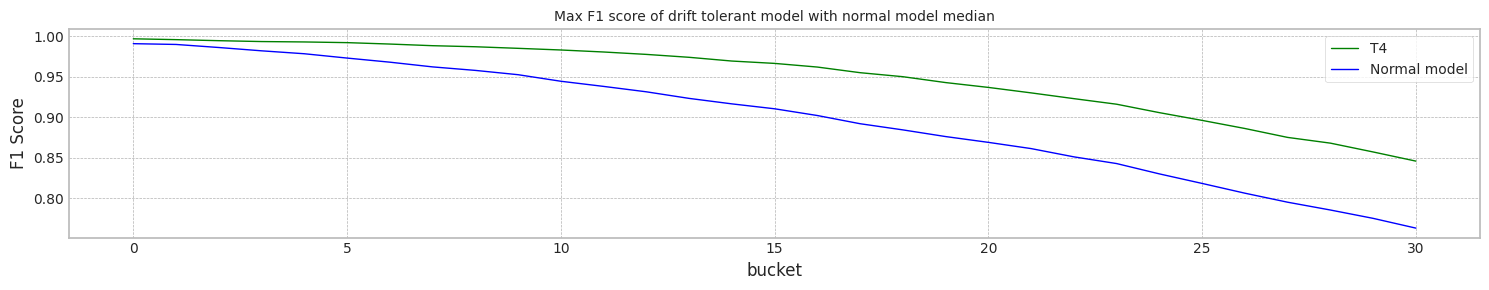

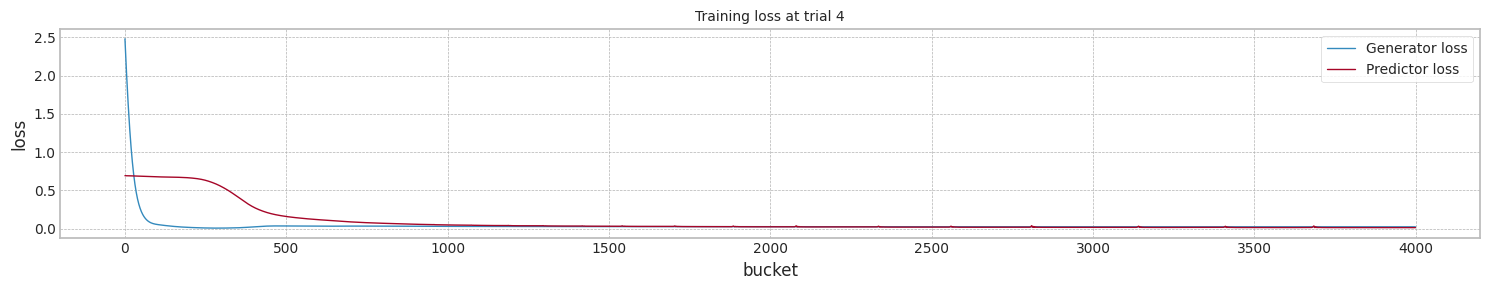

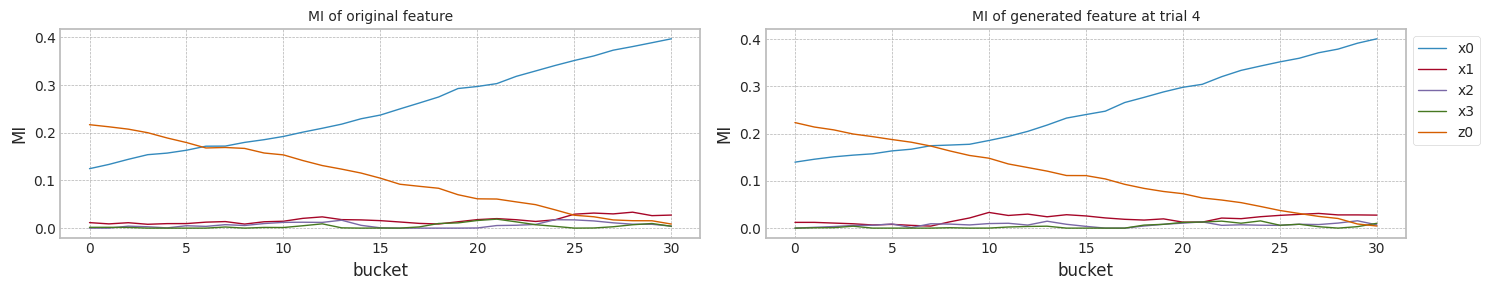

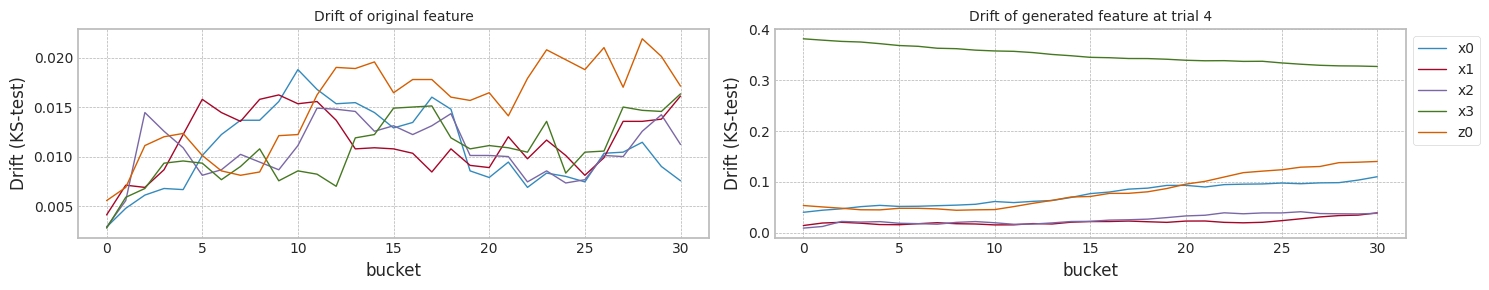

@ Normal model


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.898969  0.763477      6.573668
1      1.0    0.990988    0.990165  0.898958  0.763328      5.912051
2      2.0    0.990801    0.989597  0.898363  0.763009      5.872749
3      3.0    0.990994    0.989981  0.898834  0.763397      5.835211
4      4.0    0.990902    0.989794  0.899145  0.763754      5.837460
5      5.0    0.991182    0.989504  0.899165  0.763975      5.932287
6      6.0    0.990991    0.989880  0.898548  0.763139      5.948176
7      7.0    0.991087    0.990073  0.898890  0.763427      5.851864
8      8.0    0.990991    0.990073  0.898687  0.763158      5.856018
9      9.0    0.991087    0.990073  0.898834  0.763427      5.745174
10    10.0    0.991087    0.990073  0.898891  0.763348      5.760269
11    11.0    0.991087    0.990073  0.898928  0.763427      5.830832
12    12.0    0.991280    0.989693  0.898457  0.763108      5.903746
13    13.0    0.990991    0.990073  0.898719  0.763238      6.059913
14    14.0    0.990798    0.989974  0.898794  0.763119      5.940745
15    15.0    0.991088    0.990168  0.898832  0.763477      5.749536
16    16.0    0.991088    0.990168  0.898874  0.763636      5.750934
17    17.0    0.991087    0.990073  0.898928  0.763427      5.759726
18    18.0    0.990993    0.989979  0.898986  0.763348      5.918439
19    19.0    0.991278    0.990075  0.898601  0.763260      5.879306
20  median    0.991041    0.990073  0.898854  0.763372      5.864384
21     std    0.000126    0.000188  0.000208  0.000231      0.179317

@ SEA


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.930946  0.829274     10.272577
1      1.0    0.990988    0.990165  0.925796  0.819517     10.754245
2      2.0    0.990801    0.989597  0.938111  0.846009     10.725118
3      3.0    0.990994    0.989981  0.927727  0.824061     11.023420
4      4.0    0.990902    0.989794  0.928383  0.825621     10.687608
5      5.0    0.991182    0.989504  0.931804  0.831655     10.736576
6      6.0    0.990991    0.989880  0.937115  0.843567      9.765623
7      7.0    0.991087    0.990073  0.932992  0.833749     10.768924
8      8.0    0.990991    0.990073  0.927732  0.822664     10.390390
9      9.0    0.991087    0.990073  0.934364  0.836856     10.865364
10    10.0    0.991087    0.990073  0.927037  0.820018     10.677396
11    11.0    0.991087    0.990073  0.930228  0.829048     10.846381
12    12.0    0.991280    0.989693  0.934332  0.837810     10.763213
13    13.0    0.990991    0.990073  0.931426  0.830287     10.617962
14    14.0    0.990798    0.989974  0.922720  0.811944     10.600924
15    15.0    0.991088    0.990168  0.925282  0.819431     10.670707
16    16.0    0.991088    0.990168  0.926033  0.820535     10.755496
17    17.0    0.991087    0.990073  0.931222  0.830034     10.567719
18    18.0    0.990993    0.989979  0.928939  0.826738     10.053710
19    19.0    0.991278    0.990075  0.928024  0.824164     10.720756
20  median    0.991041    0.990073  0.929584  0.827893     10.704182
21     std    0.000126    0.000188  0.004015  0.008547      0.292426

@ AUE2


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.909721  0.788955      8.727665
1      1.0    0.990988    0.990165  0.910605  0.791137     10.812537
2      2.0    0.990801    0.989597  0.914044  0.798237     10.167252
3      3.0    0.990994    0.989981  0.908567  0.786969      9.472490
4      4.0    0.990902    0.989794  0.909293  0.788594     10.517575
5      5.0    0.991182    0.989504  0.910437  0.790607      9.740413
6      6.0    0.990991    0.989880  0.914434  0.799057      9.268330
7      7.0    0.991087    0.990073  0.910728  0.791060     10.138470
8      8.0    0.990991    0.990073  0.908426  0.786720      9.253307
9      9.0    0.991087    0.990073  0.909441  0.788582      9.306215
10    10.0    0.991087    0.990073  0.909198  0.788414     10.049107
11    11.0    0.991087    0.990073  0.902157  0.770831      9.764919
12    12.0    0.991280    0.989693  0.912080  0.793618     10.952726
13    13.0    0.990991    0.990073  0.908648  0.787219     10.089516
14    14.0    0.990798    0.989974  0.909058  0.788084      9.652541
15    15.0    0.991088    0.990168  0.907165  0.783478      8.948265
16    16.0    0.991088    0.990168  0.909688  0.789366     10.733958
17    17.0    0.991087    0.990073  0.909518  0.788706      9.074654
18    18.0    0.990993    0.989979  0.909804  0.789614     10.117063
19    19.0    0.991278    0.990075  0.908202  0.785847     10.316541
20  median    0.991041    0.990073  0.909479  0.788650      9.907013
21     std    0.000126    0.000188  0.002508  0.005634      0.640871

@ DTEL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.990993    0.989979  0.951490  0.880177     14.601882
1      1.0    0.990988    0.990165  0.951524  0.880274     15.728390
2      2.0    0.990801    0.989597  0.951230  0.880813     15.730999
3      3.0    0.990994    0.989981  0.951225  0.880371     14.740643
4      4.0    0.990902    0.989794  0.951511  0.880274     15.706680
5      5.0    0.991182    0.989504  0.951318  0.880239     15.486723
6      6.0    0.990991    0.989880  0.951249  0.880327     13.587374
7      7.0    0.991087    0.990073  0.951504  0.880513     15.555195
8      8.0    0.990991    0.990073  0.951289  0.880000     15.413036
9      9.0    0.991087    0.990073  0.951493  0.880671     15.298866
10    10.0    0.991087    0.990073  0.951438  0.880177     14.410001
11    11.0    0.991087    0.990073  0.951523  0.881210     14.197748
12    12.0    0.991280    0.989693  0.951042  0.880779     15.434998
13    13.0    0.990991    0.990073  0.951383  0.881255     14.531728
14    14.0    0.990798    0.989974  0.951486  0.880398     15.273284
15    15.0    0.991088    0.990168  0.951594  0.880468     15.447670
16    16.0    0.991088    0.990168  0.951486  0.880371     15.429068
17    17.0    0.991087    0.990073  0.951448  0.880124     15.417410
18    18.0    0.990993    0.989979  0.951620  0.881247     15.292564
19    19.0    0.991278    0.990075  0.951016  0.879894     14.593277
20  median    0.991041    0.990073  0.951467  0.880371     15.355951
21     std    0.000126    0.000188  0.000170  0.000400      0.593785

@ G-CDTL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.995422    0.994374  0.930531  0.809339      5.867946
1      1.0    0.997909    0.997340  0.945702  0.833841      5.835328
2      2.0    0.997056    0.996299  0.919633  0.778381      5.842776
3      3.0    0.997148    0.996293  0.916061  0.777992      5.950222
4      4.0    0.997048    0.996003  0.949160  0.846075      5.946670
5      5.0    0.998004    0.997439  0.916673  0.782943      5.859211
6      6.0    0.998002    0.996957  0.931043  0.811108      5.799862
7      7.0    0.997911    0.997153  0.939321  0.823449      5.838653
8      8.0    0.997148    0.996294  0.948589  0.850879      5.868465
9      9.0    0.998098    0.997243  0.939130  0.820595      5.867128
10    10.0    0.996483    0.995534  0.928676  0.802490      5.892099
11    11.0    0.997716    0.996384  0.901497  0.745024      5.858391
12    12.0    0.997149    0.996771  0.946972  0.836012      5.766455
13    13.0    0.997338    0.996580  0.924541  0.797373      5.734807
14    14.0    0.997050    0.996673  0.939652  0.814244      5.765371
15    15.0    0.997717    0.997149  0.937605  0.818781      5.865499
16    16.0    0.998289    0.997625  0.928504  0.797541      6.132127
17    17.0    0.998097    0.997147  0.938983  0.828431      6.002689
18    18.0    0.997248    0.996394  0.886235  0.695376      5.758334
19    19.0    0.997152    0.996492  0.920747  0.793661      5.796497
20  median    0.997293    0.996626  0.930787  0.810224      5.858801
21     std    0.000673    0.000747  0.016176  0.036107      0.092884

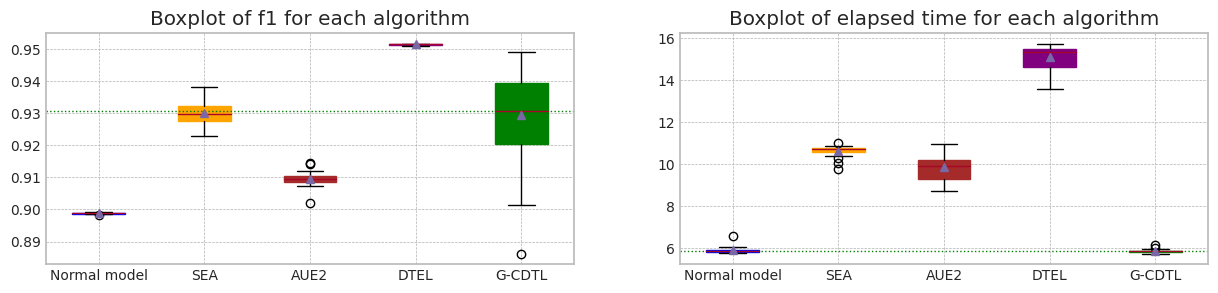

In [44]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ $P_t(y,X) \ne P_{t+w}(y,X) $ 이고 $P_t(y|X) \ne P_{t+w}(y|X) $
+ Real concept drift
+ 즉, P(y|X)와 P(X)의 변화가 연관되어 나타남.
+ 이때 대상 feature $z_0$에 대해서 MI 증가, ks-test 통계량 증가
+ 이에따라 $X_0$의 MI 감소

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [45]:
import matplotlib.pyplot as plt

cor = np.asarray([2.5, 1.2, 0.9 , 0.7, 1.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

seed_everything()

y1_array = []
cor_const = cor[0]
for ii in range(x1.shape[0]):
    cor[0] = cor[0] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    e1 = np.random.normal(0.0,  4*ii/40000)
    x1[ii,4] = x1[ii,4] + e1
    y1_array.append(np.sum(cor * x1[ii])+e)

In [46]:
m = np.mean(y1_array)
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
sum(y1)

5.568336092094251


19898

### 실험

MI Analysis MI Max 0.18765, Min 0.00339, Mean 0.06075, Std 0.07062
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.61it/s]


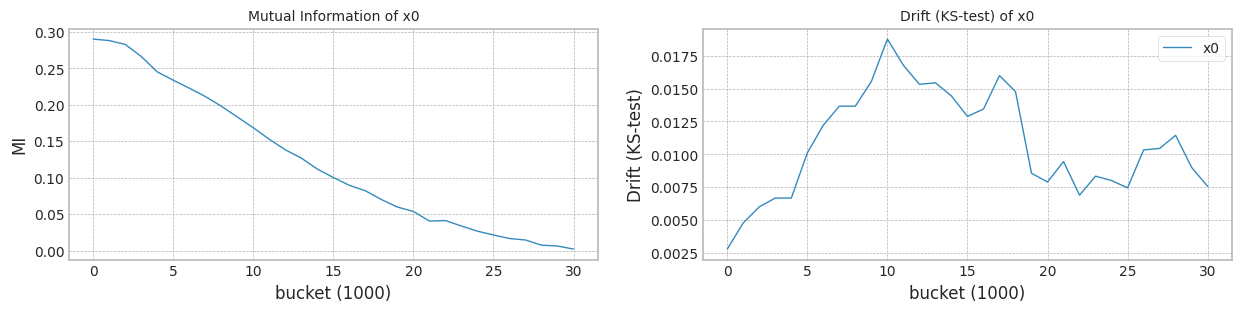

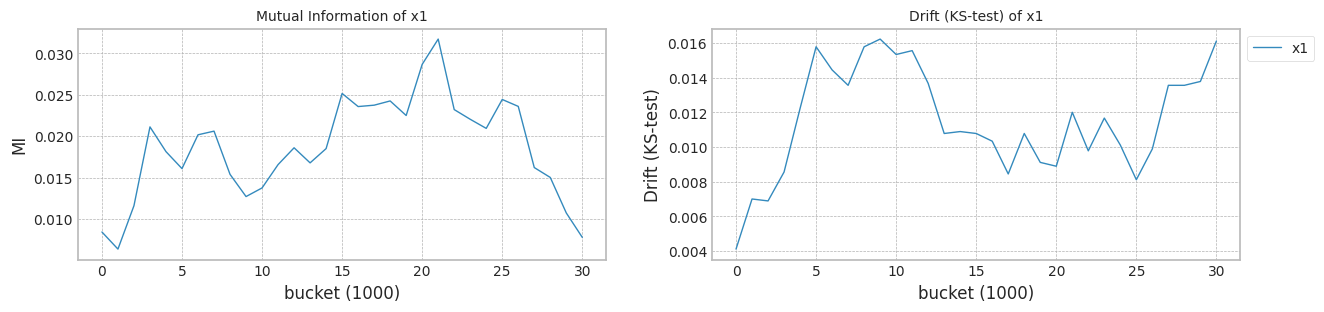

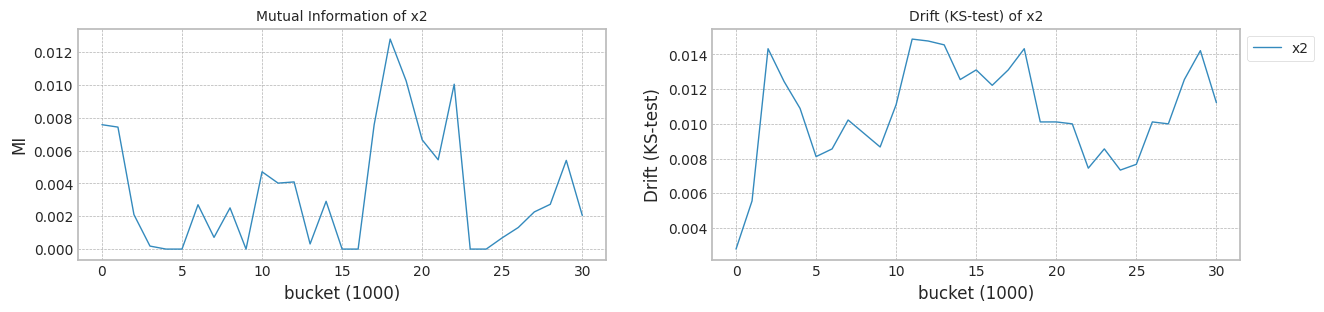

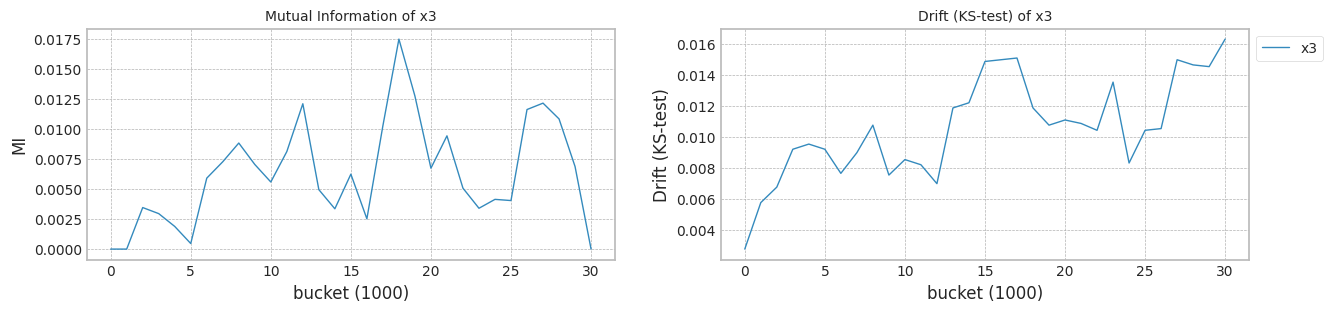

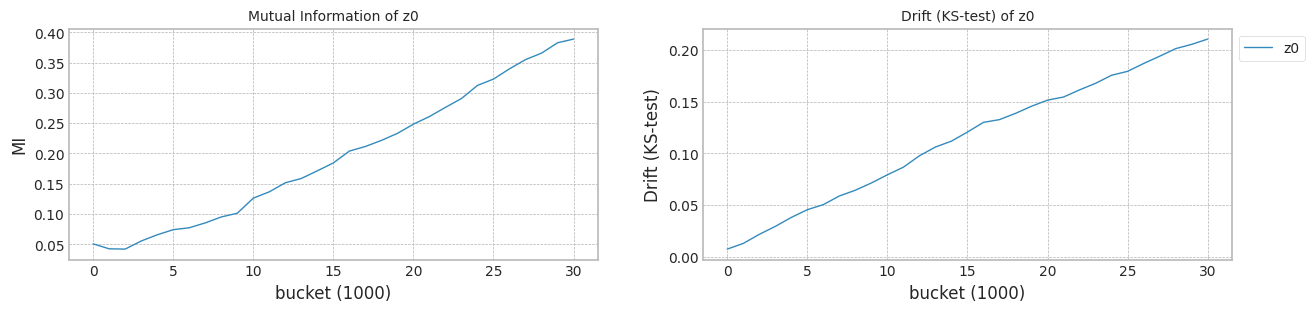

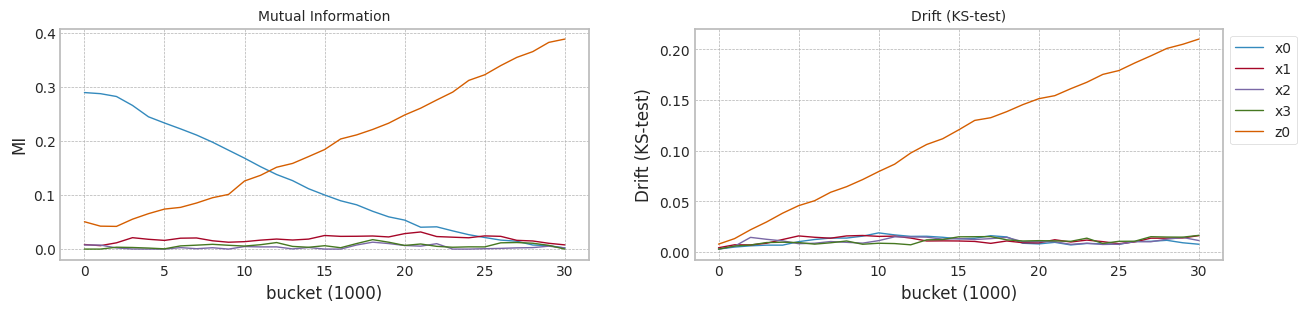

In [47]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)

In [48]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.348766   0
1      0.610533  0.420412  0.508390  0.580336  0.603602   0
2      0.556874  0.464734  0.669603  0.724770  0.452177   0
3      0.344341  0.646524  0.340976  0.528780  0.559737   0
4      0.503142  0.550860  0.598773  0.465698  0.452611   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.612303  39
39996  0.358451  0.483875  0.341855  0.574439  0.395651  39
39997  0.559469  0.343824  0.542547  0.575250  0.268402  39
39998  0.433692  0.530132  0.301231  0.282353  0.347175  39
39999  0.538629  0.637825  0.358726  0.768301  0.890274  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 642.91it/s]


Test f1 score: 0.9083657393558681
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8456464278667274
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.87it/s]


Test f1 score: 0.9091996411840926
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.118961
x1    0.014437
x2    0.047466
x3    0.077351
z0    0.138563
dtype: float64
Mean F1 for all data: 0.8641635775878077
Normal model median        : 0.8456464278667274
Drift tolerant model median: 0.8641635775878077
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 659.55it/s]


Test f1 score: 0.9086380392547573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8456271073724304
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.12it/s]


Test f1 score: 0.9085451270762458
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.560781
x1    0.081846
x2    0.135620
x3    0.039588
z0    0.133871
dtype: float64
Mean F1 for all data: 0.42398372574508975
Normal model median        : 0.8456367676195788
Drift tolerant model median: 0.6440736516664487
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.47it/s]


Test f1 score: 0.9085110623878812
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8453407869214905
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 250.35it/s]


Test f1 score: 0.9091271820448877
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.098910
x1    0.073104
x2    0.192269
x3    0.127133
z0    0.131491
dtype: float64
Mean F1 for all data: 0.8643103051436887
Normal model median        : 0.8456271073724304
Drift tolerant model median: 0.8641635775878077
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 664.59it/s]


Test f1 score: 0.9085475194261805
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8455095786596974
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 252.78it/s]


Test f1 score: 0.9079079079079079
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.190176
x1    0.017513
x2    0.015918
x3    0.061663
z0    0.128387
dtype: float64
Mean F1 for all data: 0.8534981526691958
Normal model median        : 0.8455683430160639
Drift tolerant model median: 0.8588308651285017
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 642.56it/s]


Test f1 score: 0.9081663176787317
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.845418158592803
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.51it/s]


Test f1 score: 0.9095824571943526
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.234036
x1    0.052262
x2    0.035143
x3    0.020584
z0    0.155366
dtype: float64
Mean F1 for all data: 0.8265945075288934
Normal model median        : 0.8455095786596974
Drift tolerant model median: 0.8534981526691958
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 620.22it/s]


Test f1 score: 0.9078947368421052
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.845189129134617
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 250.17it/s]


Test f1 score: 0.9097256857855361
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.086746
x1    0.029792
x2    0.214670
x3    0.021502
z0    0.335108
dtype: float64
Mean F1 for all data: 0.8151742578452592
Normal model median        : 0.8454638686262502
Drift tolerant model median: 0.8400463300990446
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 621.28it/s]


Test f1 score: 0.908239513798944
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.50it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8450025337408921
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.93it/s]


Test f1 score: 0.9070281124497992
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.169846
x1    0.031487
x2    0.031093
x3    0.331832
z0    0.135140
dtype: float64
Mean F1 for all data: 0.8636272049454392
Normal model median        : 0.845418158592803
Drift tolerant model median: 0.8534981526691958
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 641.87it/s]


Test f1 score: 0.9084205281514699
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8455747949957735
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.05it/s]


Test f1 score: 0.9075075075075074
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.058871
x1    0.013065
x2    0.029097
x3    0.093358
z0    0.172867
dtype: float64
Mean F1 for all data: 0.8632760389657035
Normal model median        : 0.8454638686262502
Drift tolerant model median: 0.8583870958174497
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 653.60it/s]


Test f1 score: 0.9086380392547573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.845652736704492
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.15it/s]


Test f1 score: 0.9091996411840926
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.097746
x1    0.042312
x2    0.248387
x3    0.087659
z0    0.118133
dtype: float64
Mean F1 for all data: 0.8703562579010293
Normal model median        : 0.8455095786596974
Drift tolerant model median: 0.8632760389657035
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 640.09it/s]


Test f1 score: 0.9086380392547573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8456271073724304
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 246.44it/s]


Test f1 score: 0.9100159616919394
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.143057
x1    0.064477
x2    0.126685
x3    0.039606
z0    0.161860
dtype: float64
Mean F1 for all data: 0.8527491932575576
Normal model median        : 0.8455421868277355
Drift tolerant model median: 0.8583870958174497
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 636.24it/s]


Test f1 score: 0.9086380392547573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8456367650965739
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.63it/s]


Test f1 score: 0.9082587064676617
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.209674
x1    0.031125
x2    0.126996
x3    0.191760
z0    0.129330
dtype: float64
Mean F1 for all data: 0.8585139849567427
Normal model median        : 0.8455747949957735
Drift tolerant model median: 0.8585139849567427
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 620.44it/s]


Test f1 score: 0.908276068120705
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.844939390675806
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.29it/s]


Test f1 score: 0.9089280382203644
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.735344
x1    0.025928
x2    0.076369
x3    0.065957
z0    0.118315
dtype: float64
Mean F1 for all data: 0.2347990055660852
Normal model median        : 0.8455421868277355
Drift tolerant model median: 0.8560060688129693
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 632.69it/s]


Test f1 score: 0.9081317806310341
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8446699268157165
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.42it/s]


Test f1 score: 0.9096163428001993
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.167287
x1    0.177086
x2    0.141029
x3    0.123735
z0    0.110444
dtype: float64
Mean F1 for all data: 0.8348991613460713
Normal model median        : 0.8455095786596974
Drift tolerant model median: 0.8534981526691958
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 637.31it/s]


Test f1 score: 0.9086380392547573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8456271073724304
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 250.32it/s]


Test f1 score: 0.9082183563287343
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.061290
x1    0.122613
x2    0.040373
x3    0.079713
z0    0.129849
dtype: float64
Mean F1 for all data: 0.8555591541673655
Normal model median        : 0.8455421868277355
Drift tolerant model median: 0.8545286534182807
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 635.16it/s]


Test f1 score: 0.9085475194261805
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8456818781004128
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.24it/s]


Test f1 score: 0.9103599561272309
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.075792
x1    0.150495
x2    0.053910
x3    0.091219
z0    0.153853
dtype: float64
Mean F1 for all data: 0.8668292406837003
Normal model median        : 0.8455747949957735
Drift tolerant model median: 0.8555591541673655
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 639.48it/s]


Test f1 score: 0.9086380392547573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8456186446067054
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.75it/s]


Test f1 score: 0.9086913086913087
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.190280
x1    0.059595
x2    0.090179
x3    0.103652
z0    0.131982
dtype: float64
Mean F1 for all data: 0.840824947044225
Normal model median        : 0.8455967198012395
Drift tolerant model median: 0.8545286534182807
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 636.12it/s]


Test f1 score: 0.9086380392547573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8468461424987409
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.30it/s]


Test f1 score: 0.9097804391217565
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.044989
x1    0.037387
x2    0.019376
x3    0.066061
z0    0.190043
dtype: float64
Mean F1 for all data: 0.8742574735706065
Normal model median        : 0.8456186446067054
Drift tolerant model median: 0.8555591541673655
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 626.17it/s]


Test f1 score: 0.9083117400837155
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8462569036442616
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.46it/s]


Test f1 score: 0.908490188225871
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.153939
x1    0.073842
x2    0.075366
x3    0.207305
z0    0.176670
dtype: float64
Mean F1 for all data: 0.8687199668163331
Normal model median        : 0.8456228759895679
Drift tolerant model median: 0.8570365695620541
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 593.87it/s]


Test f1 score: 0.9083117400837155
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8455852682564663
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.85it/s]


Test f1 score: 0.9093799682034975
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.231294
x1    0.084434
x2    0.052728
x3    0.039401
z0    0.149774
dtype: float64
Mean F1 for all data: 0.8271530282211957
Normal model median        : 0.8456186446067054
Drift tolerant model median: 0.8555591541673655
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 639.23it/s]


Test f1 score: 0.9083665338645418
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8460651273008747
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.70it/s]


Test f1 score: 0.9103062955203033
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.189401
x1    0.061534
x2    0.038538
x3    0.068638
z0    0.158143
dtype: float64
Mean F1 for all data: 0.8094526288857138
Normal model median        : 0.8456228759895679
Drift tolerant model median: 0.8545286534182807
######################### Trial 0 for Normal model ###########################
retrain_interval: 16
######################### Trial 0 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]


Early stop at  2028.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8613190843079069
SEA median: 0.8613190843079069
######################### Trial 0 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.43it/s]


Early stop at  2358.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8545530676889971
AUE median: 0.8545530676889971
######################### Trial 0 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.30it/s]


Early stop at  2441.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8757359015055052
DTEL median: 0.8757359015055052
######################### Trial 1 for Normal model ###########################
retrain_interval: 16
######################### Trial 1 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.42it/s]


Early stop at  977.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8615101910316005
SEA median: 0.8614146376697538
######################### Trial 1 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.43it/s]


Early stop at  2566.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.854771808957291
AUE median: 0.854662438323144
######################### Trial 1 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.33it/s]


Early stop at  2358.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8757309641687866
DTEL median: 0.8757334328371459
######################### Trial 2 for Normal model ###########################
retrain_interval: 16
######################### Trial 2 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.38it/s]


Early stop at  1075.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8608813252546922
SEA median: 0.8613190843079069
######################### Trial 2 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.01it/s]


Early stop at  1492.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8543832896326494
AUE median: 0.8545530676889971
######################### Trial 2 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Early stop at  1845.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8754129103816476
DTEL median: 0.8757309641687866
######################### Trial 3 for Normal model ###########################
retrain_interval: 16
######################### Trial 3 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.60it/s]


Early stop at  2296.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8601891702333214
SEA median: 0.8611002047812996
######################### Trial 3 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.88it/s]


Early stop at  1779.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8546800206826891
AUE median: 0.8546165441858431
######################### Trial 3 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


Early stop at  2255.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8751808570060315
DTEL median: 0.8755719372752171
######################### Trial 4 for Normal model ###########################
retrain_interval: 16
######################### Trial 4 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.18it/s]


Early stop at  1316.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8617846581924032
SEA median: 0.8613190843079069
######################### Trial 4 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


Early stop at  1862.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8550101189291557
AUE median: 0.8546800206826891
######################### Trial 4 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.31it/s]


Early stop at  2281.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8759366694272754
DTEL median: 0.8757309641687866
######################### Trial 5 for Normal model ###########################
retrain_interval: 16
######################### Trial 5 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


Early stop at  218.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8453684272964768
SEA median: 0.8611002047812996
######################### Trial 5 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.37it/s]


Early stop at  1079.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.854622119031308
AUE median: 0.8546510698569986
######################### Trial 5 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.26it/s]


Early stop at  2613.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8754389636504116
DTEL median: 0.8755849639095992
######################### Trial 6 for Normal model ###########################
retrain_interval: 16
######################### Trial 6 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.98it/s]


Early stop at  1715.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8617559026543482
SEA median: 0.8613190843079069
######################### Trial 6 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.23it/s]


Early stop at  1225.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8548937884104808
AUE median: 0.8546800206826891
######################### Trial 6 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.35it/s]


Early stop at  1967.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8753917426875523
DTEL median: 0.8754389636504116
######################### Trial 7 for Normal model ###########################
retrain_interval: 16
######################### Trial 7 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


Early stop at  876.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8616276088248621
SEA median: 0.8614146376697538
######################### Trial 7 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.01it/s]


Early stop at  1406.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8546626913608402
AUE median: 0.8546713560217647
######################### Trial 7 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.28it/s]


Early stop at  2458.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.875578307870001
DTEL median: 0.8755086357602063
######################### Trial 8 for Normal model ###########################
retrain_interval: 16
######################### Trial 8 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.18it/s]


Early stop at  1420.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8613367030229012
SEA median: 0.8613367030229012
######################### Trial 8 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


Early stop at  2371.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8547526101817323
AUE median: 0.8546800206826891
######################### Trial 8 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Early stop at  1135.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8758667400391217
DTEL median: 0.875578307870001
######################### Trial 9 for Normal model ###########################
retrain_interval: 16
######################### Trial 9 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.27it/s]


Early stop at  1125.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8613438208473706
SEA median: 0.8613402619351359
######################### Trial 9 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.65it/s]


Early stop at  2222.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8547341475344319
AUE median: 0.8547070841085604
######################### Trial 9 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


Early stop at  2173.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8749760191718653
DTEL median: 0.8755086357602063
######################### Trial 10 for Normal model ###########################
retrain_interval: 16
######################### Trial 10 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.26it/s]


Early stop at  2894.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.862629798676251
SEA median: 0.8613438208473706
######################### Trial 10 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8542439850280721
AUE median: 0.8546800206826891
######################### Trial 10 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Early stop at  1401.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8756483133018158
DTEL median: 0.875578307870001
######################### Trial 11 for Normal model ###########################
retrain_interval: 16
######################### Trial 11 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.25it/s]


Early stop at  1211.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8612589594694482
SEA median: 0.8613402619351359
######################### Trial 11 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8541537295322047
AUE median: 0.8546713560217647
######################### Trial 11 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Early stop at  1593.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8747037931761155
DTEL median: 0.8755086357602063
######################### Trial 12 for Normal model ###########################
retrain_interval: 16
######################### Trial 12 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.71it/s]


Early stop at  2112.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.861938371725476
SEA median: 0.8613438208473706
######################### Trial 12 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8540965691043275
AUE median: 0.8546626913608402
######################### Trial 12 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


Early stop at  895.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8749859650181401
DTEL median: 0.8754389636504116
######################### Trial 13 for Normal model ###########################
retrain_interval: 16
######################### Trial 13 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.22it/s]


Early stop at  1250.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8616565264471057
SEA median: 0.8614270059394855
######################### Trial 13 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  3.04it/s]


Early stop at  3749.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8540277054322803
AUE median: 0.8546424051960742
######################### Trial 13 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.74it/s]


Early stop at  651.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8759292223387015
DTEL median: 0.8755086357602063
######################### Trial 14 for Normal model ###########################
retrain_interval: 16
######################### Trial 14 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8613013469772637
SEA median: 0.8613438208473706
######################### Trial 14 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.26it/s]


Early stop at  1312.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8548092790528056
AUE median: 0.8546626913608402
######################### Trial 14 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.35it/s]


Early stop at  2241.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8755645484370943
DTEL median: 0.8755645484370943
######################### Trial 15 for Normal model ###########################
retrain_interval: 16
######################### Trial 15 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.17it/s]


Early stop at  1395.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8616322795378795
SEA median: 0.8614270059394855
######################### Trial 15 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.89it/s]


Early stop at  1697.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.854738252855779
AUE median: 0.8546713560217647
######################### Trial 15 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


Early stop at  2116.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8755272794083667
DTEL median: 0.8755459139227305
######################### Trial 16 for Normal model ###########################
retrain_interval: 16
######################### Trial 16 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.11it/s]


Early stop at  1488.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8623445033187856
SEA median: 0.8615101910316005
######################### Trial 16 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.01it/s]


Early stop at  1626.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8554477305091648
AUE median: 0.8546800206826891
######################### Trial 16 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Early stop at  2592.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.875862797209546
DTEL median: 0.8755645484370943
######################### Trial 17 for Normal model ###########################
retrain_interval: 16
######################### Trial 17 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.87it/s]


Early stop at  1920.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8617811525774413
SEA median: 0.8615688999282314
######################### Trial 17 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.27it/s]


Early stop at  1070.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.855020431576456
AUE median: 0.8547070841085604
######################### Trial 17 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.33it/s]


Early stop at  2254.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8755410655766804
DTEL median: 0.8755528070068874
######################### Trial 18 for Normal model ###########################
retrain_interval: 16
######################### Trial 18 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.26it/s]


Early stop at  3121.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8616073935079035
SEA median: 0.8616073935079035
######################### Trial 18 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.66it/s]


Early stop at  2156.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8547991102621318
AUE median: 0.8547341475344319
######################### Trial 18 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


Early stop at  2354.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8758668463424615
DTEL median: 0.8755645484370943
######################### Trial 19 for Normal model ###########################
retrain_interval: 16
######################### Trial 19 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.44it/s]


Early stop at  990.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8607680861913708
SEA median: 0.8615587922697521
######################### Trial 19 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.49it/s]


Early stop at  2484.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.854981963400544
AUE median: 0.8547362001951054
######################### Trial 19 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.65it/s]


Early stop at  1106.0
Mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8755064727575725
DTEL median: 0.8755528070068874


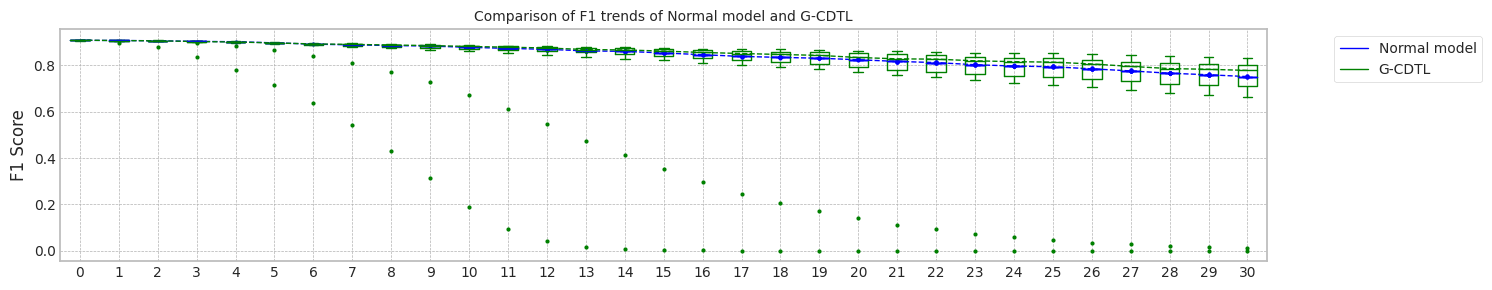

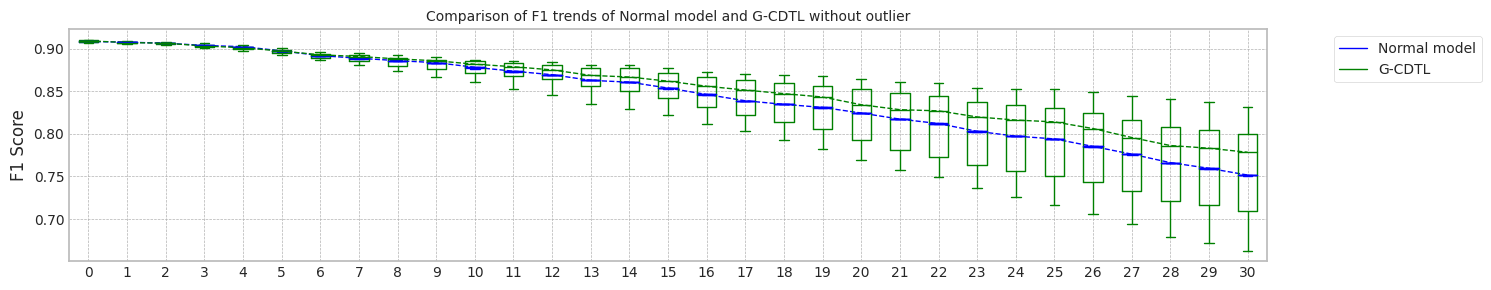

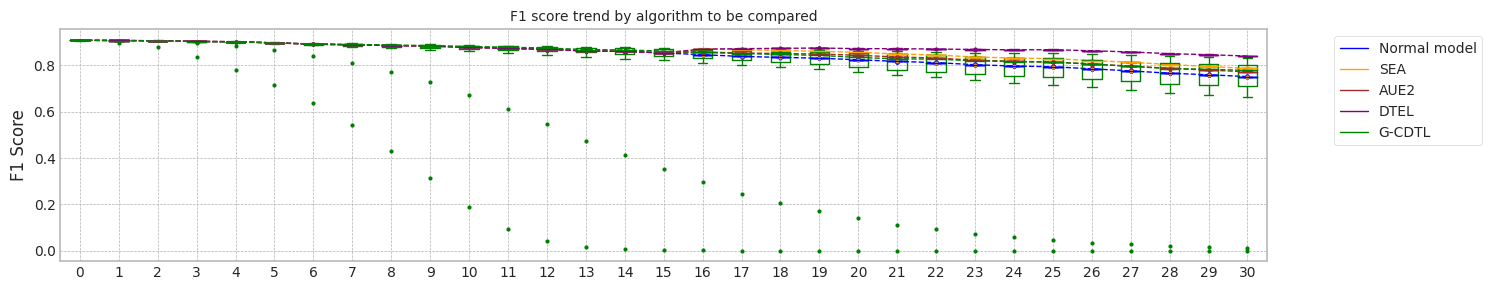

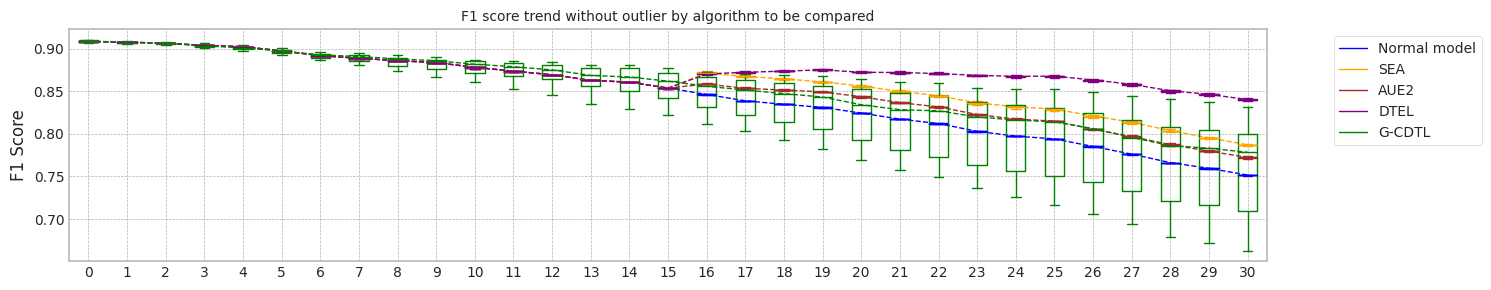

max_mean_trial= 16


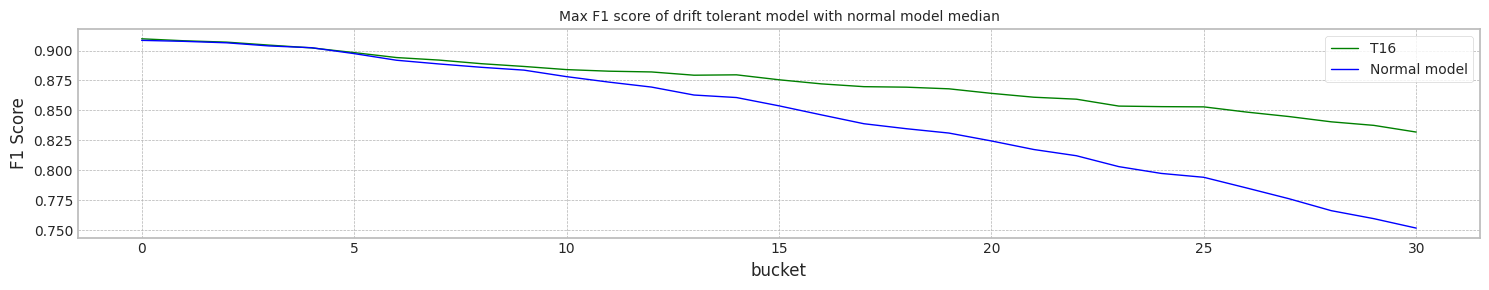

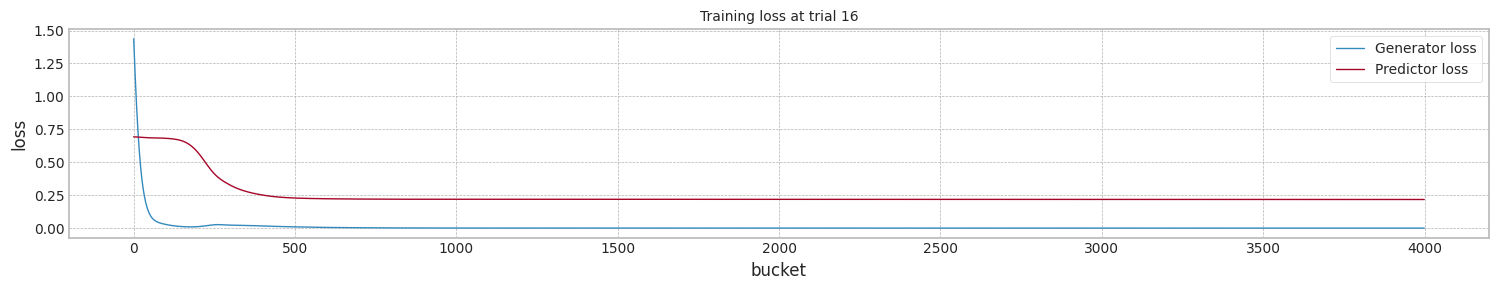

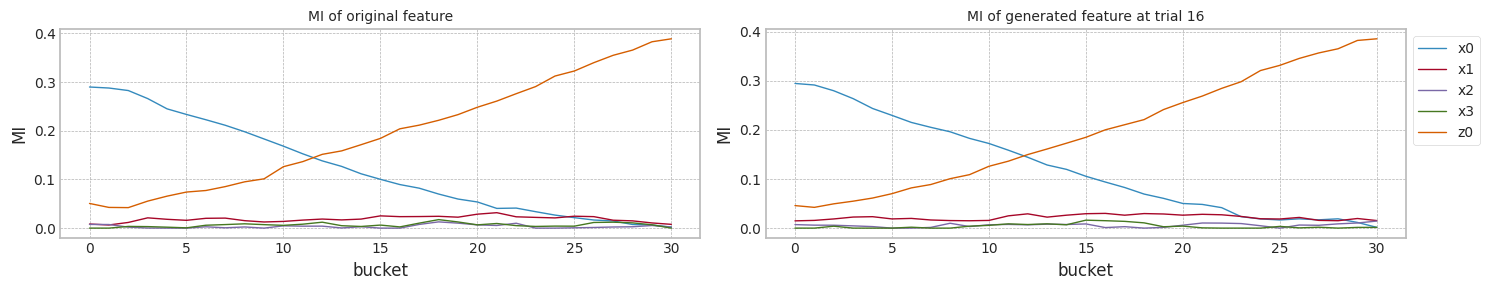

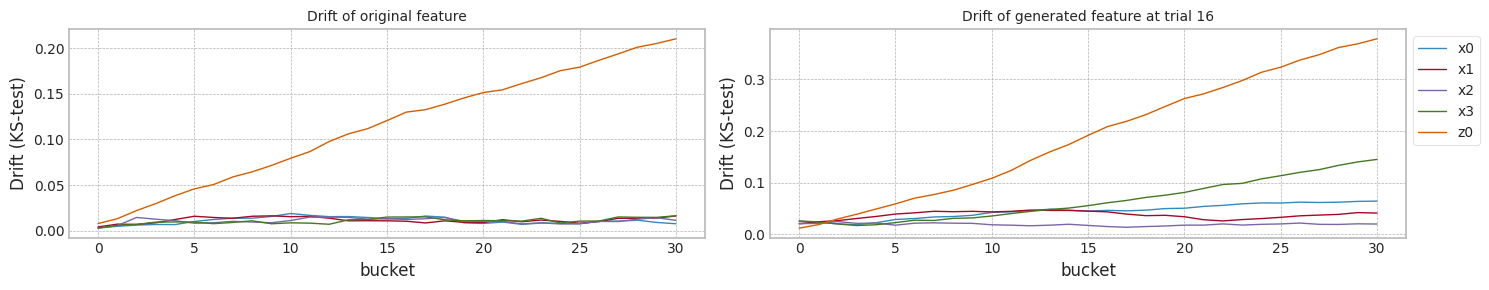

@ Normal model


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.908366    0.907622  0.845646  0.751682      5.762185
1      1.0    0.908638    0.907895  0.845627  0.751681      5.779938
2      2.0    0.908511    0.907422  0.845341  0.751319      5.905607
3      3.0    0.908548    0.907804  0.845510  0.751512      5.954694
4      4.0    0.908166    0.907513  0.845418  0.750813      5.823639
5      5.0    0.907895    0.907241  0.845189  0.750364      5.740753
6      6.0    0.908240    0.907496  0.845003  0.750532      5.680829
7      7.0    0.908421    0.907677  0.845575  0.751541      5.794470
8      8.0    0.908638    0.907895  0.845653  0.751681      5.837155
9      9.0    0.908638    0.907895  0.845627  0.751681      5.827274
10    10.0    0.908638    0.907895  0.845637  0.751597      5.878254
11    11.0    0.908276    0.907533  0.844939  0.750616      5.834384
12    12.0    0.908132    0.907153  0.844670  0.750169      5.954419
13    13.0    0.908638    0.907895  0.845627  0.751681      5.834787
14    14.0    0.908548    0.907804  0.845682  0.751765      5.922181
15    15.0    0.908638    0.907895  0.845619  0.751681      5.877074
16    16.0    0.908638    0.907895  0.846846  0.753936      5.844831
17    17.0    0.908312    0.907568  0.846257  0.753203      5.830843
18    18.0    0.908312    0.907568  0.845585  0.751878      5.748240
19    19.0    0.908367    0.907496  0.846065  0.751912      5.746727
20  median    0.908466    0.907649  0.845623  0.751681      5.832614
21     std    0.000215    0.000232  0.000467  0.000878      0.073387

@ SEA


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.908366    0.907622  0.861319  0.787325      8.257159
1      1.0    0.908638    0.907895  0.861510  0.786760      7.067919
2      2.0    0.908511    0.907422  0.860881  0.786753      7.133952
3      3.0    0.908548    0.907804  0.860189  0.784372      8.656168
4      4.0    0.908166    0.907513  0.861785  0.787249      7.459339
5      5.0    0.907895    0.907241  0.845368  0.750819      6.213184
6      6.0    0.908240    0.907496  0.861756  0.787291      7.835920
7      7.0    0.908421    0.907677  0.861628  0.787214      6.829955
8      8.0    0.908638    0.907895  0.861337  0.786647      7.468179
9      9.0    0.908638    0.907895  0.861344  0.786341      7.307978
10    10.0    0.908638    0.907895  0.862630  0.788370      9.556299
11    11.0    0.908276    0.907533  0.861259  0.787033      7.341698
12    12.0    0.908132    0.907153  0.861938  0.789626      8.390413
13    13.0    0.908638    0.907895  0.861657  0.787578      7.399597
14    14.0    0.908548    0.907804  0.861301  0.787192     10.708524
15    15.0    0.908638    0.907895  0.861632  0.787173      7.474680
16    16.0    0.908638    0.907895  0.862345  0.788817      7.584504
17    17.0    0.908312    0.907568  0.861781  0.788075      8.062573
18    18.0    0.908312    0.907568  0.861607  0.787124      9.568058
19    19.0    0.908367    0.907496  0.860768  0.786185      7.033715
20  median    0.908466    0.907649  0.861559  0.787182      7.471429
21     std    0.000215    0.000232  0.003647  0.008208      1.074990

@ AUE2


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.908366    0.907622  0.854553  0.771491      9.101740
1      1.0    0.908638    0.907895  0.854772  0.772199      9.069331
2      2.0    0.908511    0.907422  0.854383  0.773246      7.771604
3      3.0    0.908548    0.907804  0.854680  0.772418      8.033414
4      4.0    0.908166    0.907513  0.855010  0.772892      8.171422
5      5.0    0.907895    0.907241  0.854622  0.772588      7.146194
6      6.0    0.908240    0.907496  0.854894  0.773380      7.365093
7      7.0    0.908421    0.907677  0.854663  0.772149      7.777900
8      8.0    0.908638    0.907895  0.854753  0.772418      8.792071
9      9.0    0.908638    0.907895  0.854734  0.772199      8.531033
10    10.0    0.908638    0.907895  0.854244  0.771610     10.661344
11    11.0    0.908276    0.907533  0.854154  0.772418     10.610419
12    12.0    0.908132    0.907153  0.854097  0.773310     10.657832
13    13.0    0.908638    0.907895  0.854028  0.770666     10.259111
14    14.0    0.908548    0.907804  0.854809  0.772403      7.320213
15    15.0    0.908638    0.907895  0.854738  0.772418      8.028874
16    16.0    0.908638    0.907895  0.855448  0.774116      7.767005
17    17.0    0.908312    0.907568  0.855020  0.773351      7.309903
18    18.0    0.908312    0.907568  0.854799  0.772234      8.511385
19    19.0    0.908367    0.907496  0.854982  0.773266      8.926748
20  median    0.908466    0.907649  0.854736  0.772418      8.341403
21     std    0.000215    0.000232  0.000351  0.000782      1.163759

@ DTEL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.908366    0.907622  0.875736  0.842003     13.505784
1      1.0    0.908638    0.907895  0.875731  0.842003     13.355850
2      2.0    0.908511    0.907422  0.875413  0.841799     12.749641
3      3.0    0.908548    0.907804  0.875181  0.838084     13.155203
4      4.0    0.908166    0.907513  0.875937  0.840334     13.487461
5      5.0    0.907895    0.907241  0.875439  0.840231     13.771348
6      6.0    0.908240    0.907496  0.875392  0.839667     13.259217
7      7.0    0.908421    0.907677  0.875578  0.840116     13.624365
8      8.0    0.908638    0.907895  0.875867  0.841314     12.184403
9      9.0    0.908638    0.907895  0.874976  0.839578     13.436917
10    10.0    0.908638    0.907895  0.875648  0.840879     12.243247
11    11.0    0.908276    0.907533  0.874704  0.838984     12.445720
12    12.0    0.908132    0.907153  0.874986  0.839122     11.529455
13    13.0    0.908638    0.907895  0.875929  0.841685     11.343133
14    14.0    0.908548    0.907804  0.875565  0.838873     13.244544
15    15.0    0.908638    0.907895  0.875527  0.840165     13.407669
16    16.0    0.908638    0.907895  0.875863  0.840854     13.819857
17    17.0    0.908312    0.907568  0.875541  0.838974     13.373427
18    18.0    0.908312    0.907568  0.875867  0.840956     13.394210
19    19.0    0.908367    0.907496  0.875506  0.840485     11.754320
20  median    0.908466    0.907649  0.875553  0.840283     13.307533
21     std    0.000215    0.000232  0.000341  0.001145      0.764525

@ G-CDTL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.909200    0.908146  0.864164  0.791453      5.906284
1      1.0    0.908545    0.906839  0.423984  0.011187      5.850372
2      2.0    0.909127    0.907219  0.864310  0.797405      5.823794
3      3.0    0.907908    0.906661  0.853498  0.800653      5.756058
4      4.0    0.909582    0.907720  0.826595  0.711690      5.835389
5      5.0    0.909726    0.906939  0.815174  0.702558      5.791286
6      6.0    0.907028    0.905664  0.863627  0.821952      5.961209
7      7.0    0.907508    0.906172  0.863276  0.795936      5.862270
8      8.0    0.909200    0.908129  0.870356  0.812320      5.766916
9      9.0    0.910016    0.908309  0.852749  0.765429      5.785122
10    10.0    0.908259    0.907239  0.858514  0.792935      5.759923
11    11.0    0.908928    0.898339  0.234799  0.000000      5.771584
12    12.0    0.909616    0.907946  0.834899  0.707489      5.949173
13    13.0    0.908218    0.907014  0.855559  0.752929      5.893619
14    14.0    0.910360    0.908764  0.866829  0.800372      5.842048
15    15.0    0.908691    0.907140  0.840825  0.757094      5.995829
16    16.0    0.909780    0.908127  0.874257  0.831887      5.795985
17    17.0    0.908490    0.907285  0.868720  0.806497      5.838065
18    18.0    0.909380    0.907786  0.827153  0.710927      5.946847
19    19.0    0.910306    0.908107  0.809453  0.663007      5.863243
20  median    0.909163    0.907262  0.854529  0.778441      5.840056
21     std    0.000910    0.002173  0.164405  0.239213      0.072517

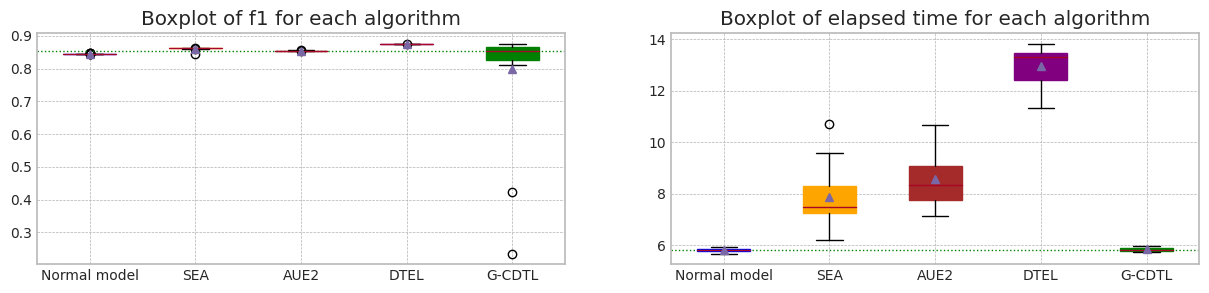

In [49]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

+ $P_t(y|X) = P_{t+w}(y|X)$ and $P_t(X) \ne P_{t+w}(X)$
+ Virtual Drift
+ 즉, Concept (본 Dataset에서 MI의 변화)의 변화는 없고, P(X)만 변함.

### Dataset 준비

In [50]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.60it/s]


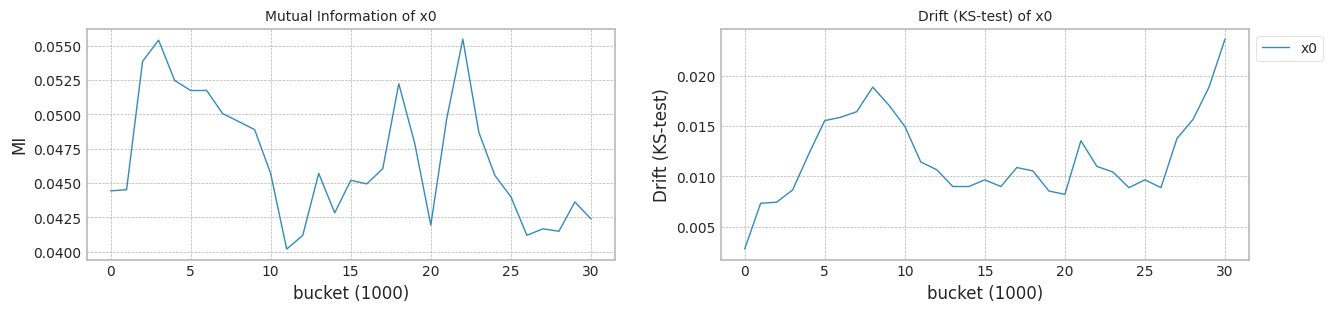

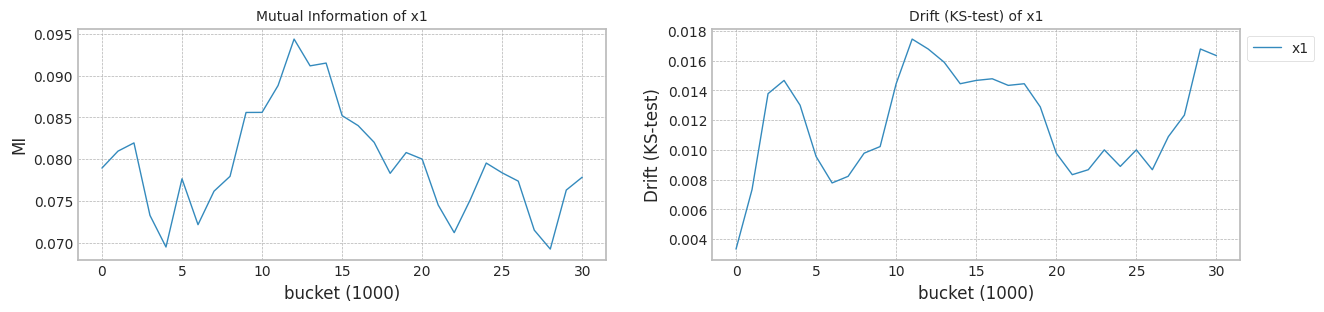

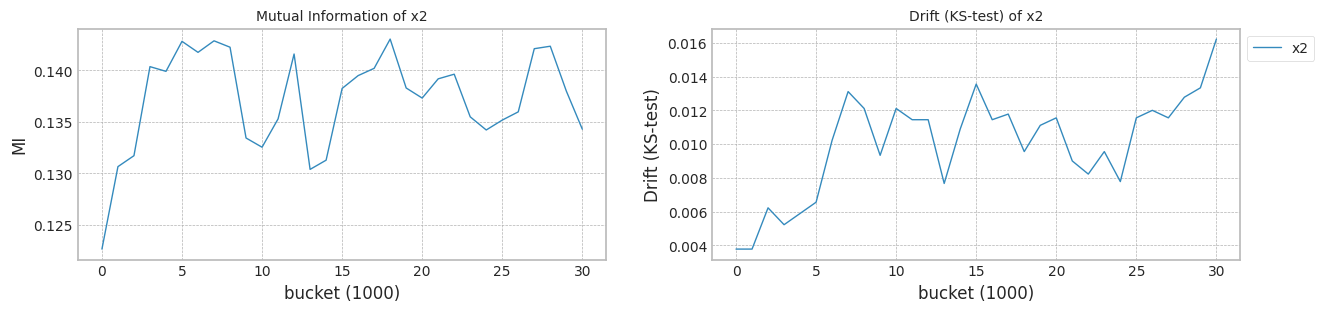

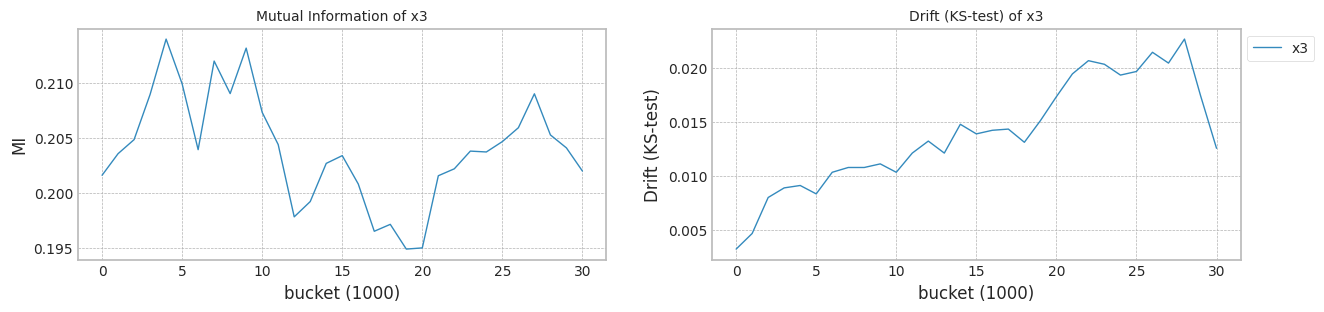

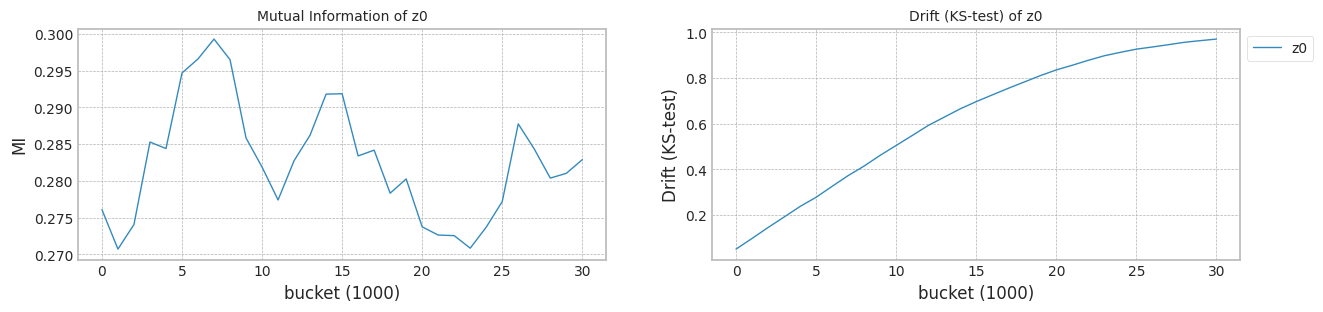

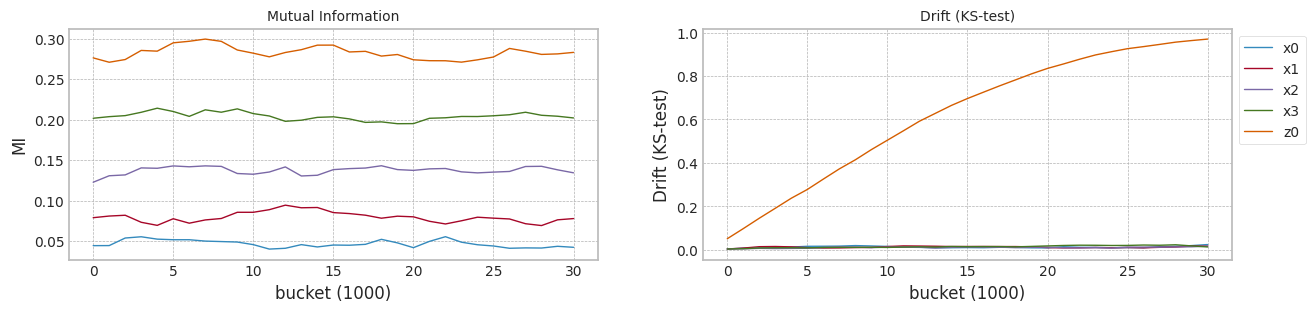

In [51]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [52]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.477486   0
1      0.447230  0.556479  0.629077  0.735705  0.578715   0
2      0.489501  0.704159  0.760582  0.582973  0.354045   0
3      0.581446  0.301839  0.443337  0.515173  0.360338   0
4      0.571642  0.639275  0.524701  0.583380  0.597569   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.989291  39
39996  0.426322  0.302644  0.484909  0.587518  1.004704  39
39997  0.374186  0.587769  0.624447  0.598315  1.321791  39
39998  0.470439  0.265430  0.218971  0.645349  1.148847  39
39999  0.654583  0.419378  0.800216  0.614031  1.319193  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 621.31it/s]


Test f1 score: 0.9121856027753685
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7694158696819199
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.20it/s]


Test f1 score: 0.9206490331184709
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.041742
x1    0.153262
x2    0.593240
x3    0.074774
z0    0.538989
dtype: float64
Mean F1 for all data: 0.7169494580617239
Normal model median        : 0.7694158696819199
Drift tolerant model median: 0.7169494580617239
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 636.95it/s]


Test f1 score: 0.9113209595137306
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7706523824654755
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 246.72it/s]


Test f1 score: 0.9225515038008152
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.480498
x1    0.178932
x2    0.179308
x3    0.230674
z0    0.422824
dtype: float64
Mean F1 for all data: 0.9115424803826504
Normal model median        : 0.7700341260736977
Drift tolerant model median: 0.8142459692221872
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 645.16it/s]


Test f1 score: 0.9125499945951788
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.76878780457723
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.69it/s]


Test f1 score: 0.921467121929728
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.163978
x1    0.192918
x2    0.250602
x3    0.309272
z0    0.363108
dtype: float64
Mean F1 for all data: 0.900115594431291
Normal model median        : 0.7694158696819199
Drift tolerant model median: 0.900115594431291
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.50it/s]


Test f1 score: 0.9117136659436008
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7704631632803813
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.73it/s]


Test f1 score: 0.922211188348229
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


mean of drift:
x0    0.062211
x1    0.607703
x2    0.052760
x3    0.069882
z0    0.403280
dtype: float64
Mean F1 for all data: 0.6564773980623566
Normal model median        : 0.7699395164811507
Drift tolerant model median: 0.8085325262465075
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 644.22it/s]


Test f1 score: 0.9106678230702515
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7651282538395099
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 245.87it/s]


Test f1 score: 0.9215491559086395
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.056921
x1    0.120183
x2    0.088996
x3    0.139613
z0    0.421473
dtype: float64
Mean F1 for all data: 0.9168986401533207
Normal model median        : 0.7694158696819199
Drift tolerant model median: 0.900115594431291
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.50it/s]


Test f1 score: 0.9116753472222222
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.45it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7686716994487134
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 253.17it/s]


Test f1 score: 0.9225530045040098
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.147778
x1    0.151437
x2    0.155642
x3    0.228065
z0    0.412914
dtype: float64
Mean F1 for all data: 0.88066578946114
Normal model median        : 0.7691018371295749
Drift tolerant model median: 0.8903906919462155
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 646.06it/s]


Test f1 score: 0.9121021866204807
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.767951437608148
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.51it/s]


Test f1 score: 0.9203520352035204
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.084384
x1    0.050921
x2    0.571315
x3    0.159839
z0    0.571441
dtype: float64
Mean F1 for all data: 0.8836754605017896
Normal model median        : 0.76878780457723
Drift tolerant model median: 0.8836754605017896
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 658.61it/s]


Test f1 score: 0.911968777103209
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7695908535099439
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.99it/s]


Test f1 score: 0.9216681376875552
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.133889
x1    0.177667
x2    0.170771
x3    0.221172
z0    0.217581
dtype: float64
Mean F1 for all data: 0.918685046568159
Normal model median        : 0.7691018371295749
Drift tolerant model median: 0.8918955274665403
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 653.74it/s]


Test f1 score: 0.9115956177459594
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7704416385654702
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.33it/s]


Test f1 score: 0.9218441273326016
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.047821
x1    0.032161
x2    0.049319
x3    0.544258
z0    0.590143
dtype: float64
Mean F1 for all data: 0.9049576956624266
Normal model median        : 0.7694158696819199
Drift tolerant model median: 0.900115594431291
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 668.58it/s]


Test f1 score: 0.9120295042846297
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7707693151138754
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.75it/s]


Test f1 score: 0.922010779892201
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.604659
x1    0.050247
x2    0.088118
x3    0.075613
z0    0.527889
dtype: float64
Mean F1 for all data: 0.9170970204514833
Normal model median        : 0.7695033615959319
Drift tolerant model median: 0.9025366450468588
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 649.64it/s]


Test f1 score: 0.9117551286225986
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7694860544114435
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 250.22it/s]


Test f1 score: 0.9216010585511081
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.204713
x1    0.254398
x2    0.166075
x3    0.237996
z0    0.316588
dtype: float64
Mean F1 for all data: 0.9253683746933509
Normal model median        : 0.7694860544114435
Drift tolerant model median: 0.9049576956624266
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.97it/s]


Test f1 score: 0.9109856708640903
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7673924060290571
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.80it/s]


Test f1 score: 0.9220950704225351
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.592172
x1    0.106699
x2    0.086742
x3    0.171384
z0    0.543652
dtype: float64
Mean F1 for all data: 0.9077325802674853
Normal model median        : 0.7694509620466816
Drift tolerant model median: 0.9063451379649559
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 615.93it/s]


Test f1 score: 0.6685405725275537
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.6665410430947298
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.68it/s]


Test f1 score: 0.9227534307215582
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


mean of drift:
x0    0.126527
x1    0.391165
x2    0.099437
x3    0.182882
z0    0.527853
dtype: float64
Mean F1 for all data: 0.794661322356215
Normal model median        : 0.7694158696819199
Drift tolerant model median: 0.9049576956624266
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 639.94it/s]


Test f1 score: 0.9120295042846297
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7701331589898588
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.17it/s]


Test f1 score: 0.9222136648696228
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.27it/s]


mean of drift:
x0    0.152878
x1    0.366724
x2    0.201140
x3    0.262556
z0    0.329685
dtype: float64
Mean F1 for all data: 0.8827626804482738
Normal model median        : 0.7694509620466816
Drift tolerant model median: 0.9025366450468588
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 657.30it/s]


Test f1 score: 0.9104720564297342
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7654475854545305
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.98it/s]


Test f1 score: 0.9217698333885027
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.623989
x1    0.049903
x2    0.132057
x3    0.087072
z0    0.554789
dtype: float64
Mean F1 for all data: 0.9171573755710994
Normal model median        : 0.7694158696819199
Drift tolerant model median: 0.9049576956624266
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 652.85it/s]


Test f1 score: 0.9116561753852832
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.770251674395288
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.49it/s]


Test f1 score: 0.9212442091330245
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.125849
x1    0.339401
x2    0.194871
x3    0.254946
z0    0.320771
dtype: float64
Mean F1 for all data: 0.8858617290003589
Normal model median        : 0.7694509620466816
Drift tolerant model median: 0.9025366450468588
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 632.55it/s]


Test f1 score: 0.9118508077632007
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.769525101327539
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.54it/s]


Test f1 score: 0.9222638185421712
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.166900
x1    0.091685
x2    0.181814
x3    0.273763
z0    0.344222
dtype: float64
Mean F1 for all data: 0.9197601325935676
Normal model median        : 0.7694860544114435
Drift tolerant model median: 0.9049576956624266
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 632.36it/s]


Test f1 score: 0.9118699186991871
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.76953048458936
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.18it/s]


Test f1 score: 0.92099173553719
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.110688
x1    0.194505
x2    0.174039
x3    0.205993
z0    0.302889
dtype: float64
Mean F1 for all data: 0.9205902002191638
Normal model median        : 0.7695055778694913
Drift tolerant model median: 0.9063451379649559
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 635.01it/s]


Test f1 score: 0.9116753472222222
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7702988306535232
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.00it/s]


Test f1 score: 0.9204845814977973
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.168631
x1    0.140290
x2    0.186548
x3    0.318176
z0    0.365283
dtype: float64
Mean F1 for all data: 0.9215901270264424
Normal model median        : 0.769525101327539
Drift tolerant model median: 0.9077325802674853
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 605.31it/s]


Test f1 score: 0.9116147923218739
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7649211096502738
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.37it/s]


Test f1 score: 0.9214277820753674
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


mean of drift:
x0    0.151828
x1    0.143004
x2    0.203416
x3    0.279563
z0    0.356857
dtype: float64
Mean F1 for all data: 0.9229856375684294
Normal model median        : 0.7695055778694913
Drift tolerant model median: 0.9096375303250679
######################### Trial 0 for Normal model ###########################
retrain_interval: 16
######################### Trial 0 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.12it/s]


Early stop at  3471.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8146523960893838
SEA median: 0.8146523960893838
######################### Trial 0 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.79it/s]


Early stop at  1936.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7767545665123073
AUE median: 0.7767545665123073
######################### Trial 0 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Early stop at  1888.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.857754386364658
DTEL median: 0.857754386364658
######################### Trial 1 for Normal model ###########################
retrain_interval: 16
######################### Trial 1 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.90it/s]


Early stop at  1728.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8106043531796667
SEA median: 0.8126283746345253
######################### Trial 1 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.28it/s]


Early stop at  1261.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7784048703715412
AUE median: 0.7775797184419242
######################### Trial 1 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.35it/s]


Early stop at  1942.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8589948833666031
DTEL median: 0.8583746348656305
######################### Trial 2 for Normal model ###########################
retrain_interval: 16
######################### Trial 2 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


Early stop at  1697.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8147210501694535
SEA median: 0.8146523960893838
######################### Trial 2 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.26it/s]


Early stop at  1254.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7761903866741903
AUE median: 0.7767545665123073
######################### Trial 2 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.63it/s]


Early stop at  1119.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8564100993345651
DTEL median: 0.857754386364658
######################### Trial 3 for Normal model ###########################
retrain_interval: 16
######################### Trial 3 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.98it/s]


Early stop at  1667.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8147849036631818
SEA median: 0.8146867231294186
######################### Trial 3 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.26it/s]


Early stop at  1274.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7785175644009352
AUE median: 0.7775797184419242
######################### Trial 3 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


Early stop at  1791.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8574045546011716
DTEL median: 0.8575794704829147
######################### Trial 4 for Normal model ###########################
retrain_interval: 16
######################### Trial 4 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.67it/s]


Early stop at  1947.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8087144771164071
SEA median: 0.8146523960893838
######################### Trial 4 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.13it/s]


Early stop at  1265.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.772032595908557
AUE median: 0.7767545665123073
######################### Trial 4 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


Early stop at  1780.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8547368017319973
DTEL median: 0.8574045546011716
######################### Trial 5 for Normal model ###########################
retrain_interval: 16
######################### Trial 5 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.11it/s]


Early stop at  3550.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8135972977853237
SEA median: 0.8141248469373538
######################### Trial 5 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.83it/s]


Early stop at  1822.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7761431428568164
AUE median: 0.7764724765932488
######################### Trial 5 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.66it/s]


Early stop at  1094.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8573732303832088
DTEL median: 0.8573888924921902
######################### Trial 6 for Normal model ###########################
retrain_interval: 16
######################### Trial 6 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.98it/s]


Early stop at  1643.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.81398848290485
SEA median: 0.81398848290485
######################### Trial 6 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.07it/s]


Early stop at  1462.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7754823524484655
AUE median: 0.7761903866741903
######################### Trial 6 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Early stop at  1319.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.856539992892843
DTEL median: 0.8573732303832088
######################### Trial 7 for Normal model ###########################
retrain_interval: 16
######################### Trial 7 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.14it/s]


Early stop at  1431.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8108351809563485
SEA median: 0.8137928903450868
######################### Trial 7 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.93it/s]


Early stop at  1782.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7767598438626528
AUE median: 0.7764724765932488
######################### Trial 7 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Early stop at  1943.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8583109735244531
DTEL median: 0.8573888924921902
######################### Trial 8 for Normal model ###########################
retrain_interval: 16
######################### Trial 8 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.96it/s]


Early stop at  1650.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8123530611554811
SEA median: 0.8135972977853237
######################### Trial 8 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.92it/s]


Early stop at  1623.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7779778678528555
AUE median: 0.7767545665123073
######################### Trial 8 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


Early stop at  1997.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8579255159374695
DTEL median: 0.8574045546011716
######################### Trial 9 for Normal model ###########################
retrain_interval: 16
######################### Trial 9 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.77it/s]


Early stop at  1841.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8142174357898412
SEA median: 0.8137928903450868
######################### Trial 9 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.97it/s]


Early stop at  1452.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7786412585723264
AUE median: 0.77675720518748
######################### Trial 9 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.29it/s]


Early stop at  2512.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8582049924977836
DTEL median: 0.8575794704829147
######################### Trial 10 for Normal model ###########################
retrain_interval: 16
######################### Trial 10 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


Early stop at  34.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7692897097544095
SEA median: 0.8135972977853237
######################### Trial 10 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Early stop at  nan
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7762159106987477
AUE median: 0.7767545665123073
######################### Trial 10 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Early stop at  1760.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8584232124903622
DTEL median: 0.857754386364658
######################### Trial 11 for Normal model ###########################
retrain_interval: 16
######################### Trial 11 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


Early stop at  3809.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8089456831350028
SEA median: 0.8129751794704024
######################### Trial 11 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Early stop at  nan
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7730186098112094
AUE median: 0.7764852386055275
######################### Trial 11 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.68it/s]


Early stop at  949.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8569138442511564
DTEL median: 0.8575794704829147
######################### Trial 12 for Normal model ###########################
retrain_interval: 16
######################### Trial 12 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.29it/s]


Early stop at  3161.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7676902332704311
SEA median: 0.8123530611554811
######################### Trial 12 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Early stop at  nan
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7438472646248101
AUE median: 0.7762159106987477
######################### Trial 12 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Early stop at  1701.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7677833808973821
DTEL median: 0.8574045546011716
######################### Trial 13 for Normal model ###########################
retrain_interval: 16
######################### Trial 13 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.64it/s]


Early stop at  2383.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.813448134698428
SEA median: 0.8129005979269546
######################### Trial 13 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.28it/s]


Early stop at  1079.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7772576987774361
AUE median: 0.7764852386055275
######################### Trial 13 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Early stop at  1639.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8582283709771986
DTEL median: 0.8575794704829147
######################### Trial 14 for Normal model ###########################
retrain_interval: 16
######################### Trial 14 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.25it/s]


Early stop at  3071.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8089082996823825
SEA median: 0.8123530611554811
######################### Trial 14 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.09it/s]


Early stop at  1242.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.771857664049033
AUE median: 0.7762159106987477
######################### Trial 14 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


Early stop at  1872.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8550066706637532
DTEL median: 0.8574045546011716
######################### Trial 15 for Normal model ###########################
retrain_interval: 16
######################### Trial 15 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.99it/s]


Early stop at  1704.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8103662236140324
SEA median: 0.8115941210559148
######################### Trial 15 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]


Early stop at  1991.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7775068971663937
AUE median: 0.7764852386055275
######################### Trial 15 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


Early stop at  1768.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8587021399898533
DTEL median: 0.8575794704829147
######################### Trial 16 for Normal model ###########################
retrain_interval: 16
######################### Trial 16 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.76it/s]


Early stop at  1791.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8108860078723411
SEA median: 0.8108860078723411
######################### Trial 16 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.20it/s]


Early stop at  1368.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7767559276335659
AUE median: 0.7767545665123073
######################### Trial 16 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Early stop at  1426.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8581224535268878
DTEL median: 0.857754386364658
######################### Trial 17 for Normal model ###########################
retrain_interval: 16
######################### Trial 17 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.96it/s]


Early stop at  1806.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8112552123417781
SEA median: 0.8110706101070596
######################### Trial 17 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.14it/s]


Early stop at  1383.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7764876853860753
AUE median: 0.7766211259491913
######################### Trial 17 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


Early stop at  2203.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8585332336113413
DTEL median: 0.8578399511510637
######################### Trial 18 for Normal model ###########################
retrain_interval: 16
######################### Trial 18 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.10it/s]


Early stop at  1541.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8102815858879082
SEA median: 0.8108860078723411
######################### Trial 18 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.93it/s]


Early stop at  1481.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7774085911703954
AUE median: 0.7767545665123073
######################### Trial 18 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


Early stop at  2903.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8586994361778971
DTEL median: 0.8579255159374695
######################### Trial 19 for Normal model ###########################
retrain_interval: 16
######################### Trial 19 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.69it/s]


Early stop at  2226.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8068562490715451
SEA median: 0.8108605944143448
######################### Trial 19 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.08it/s]


Early stop at  1408.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7712274903156959
AUE median: 0.7766211259491913
######################### Trial 19 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


Early stop at  1709.0
Mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.855435151515056
DTEL median: 0.8578399511510637


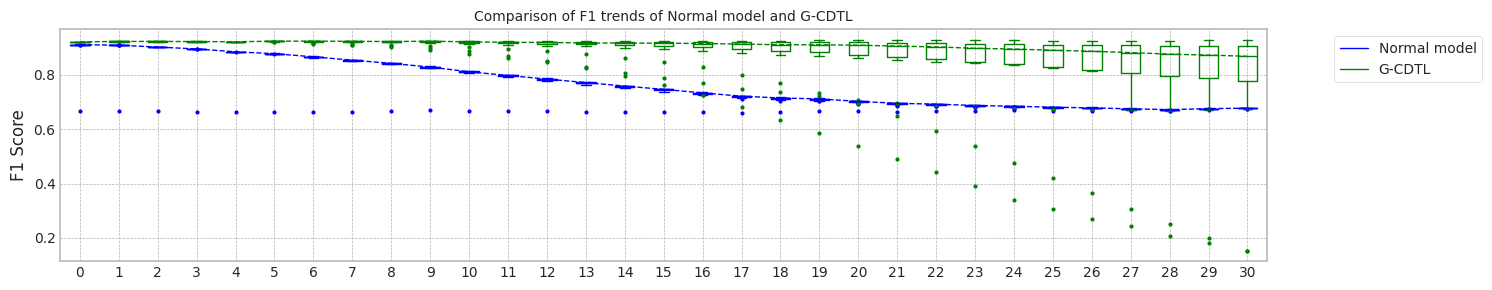

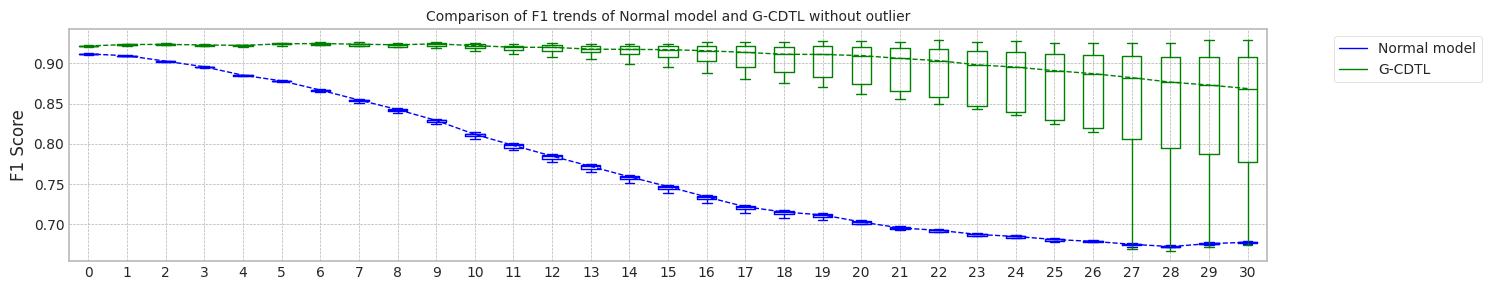

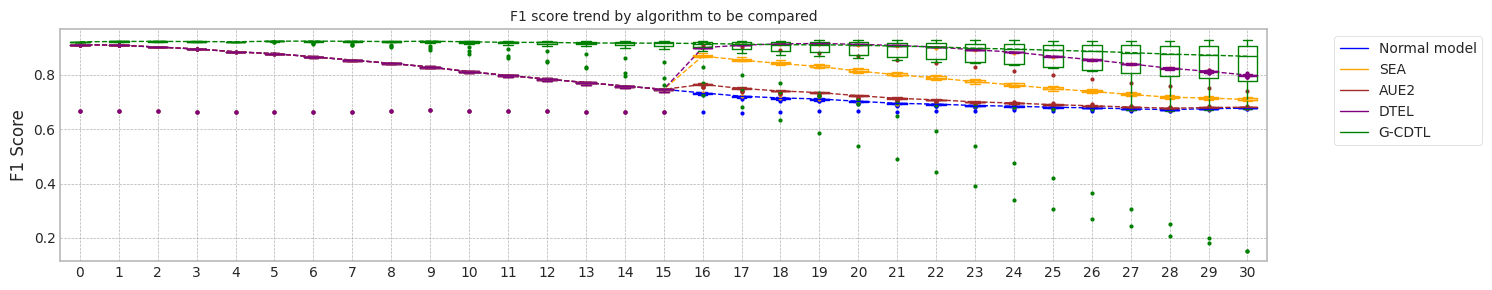

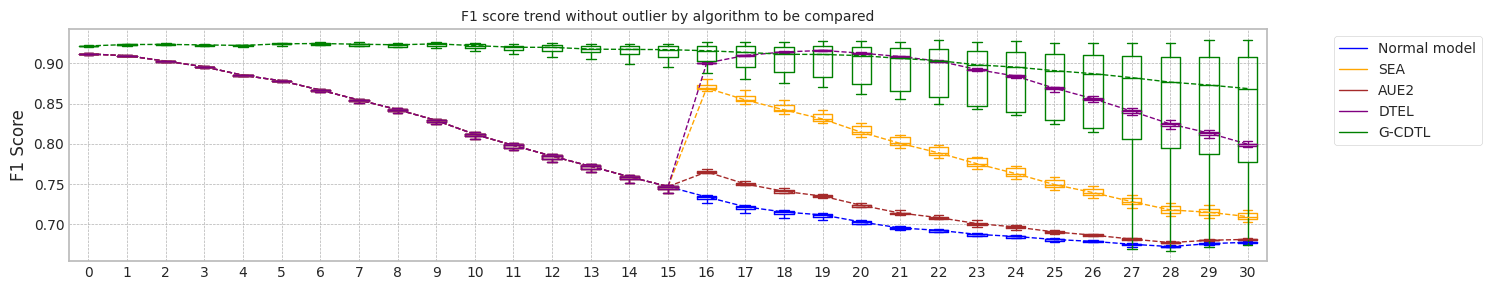

max_mean_trial= 10


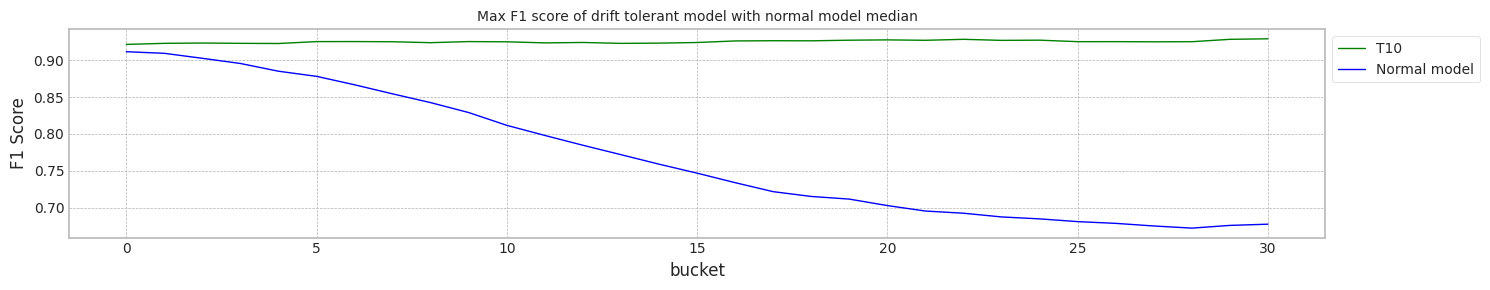

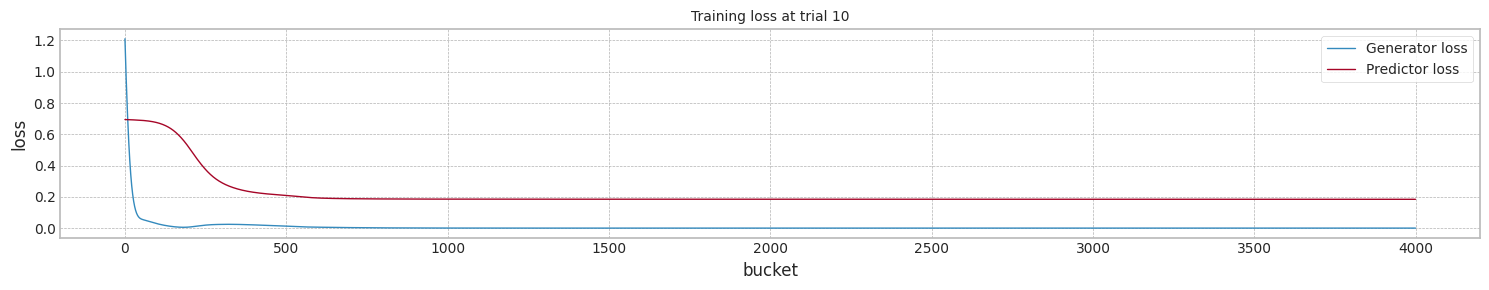

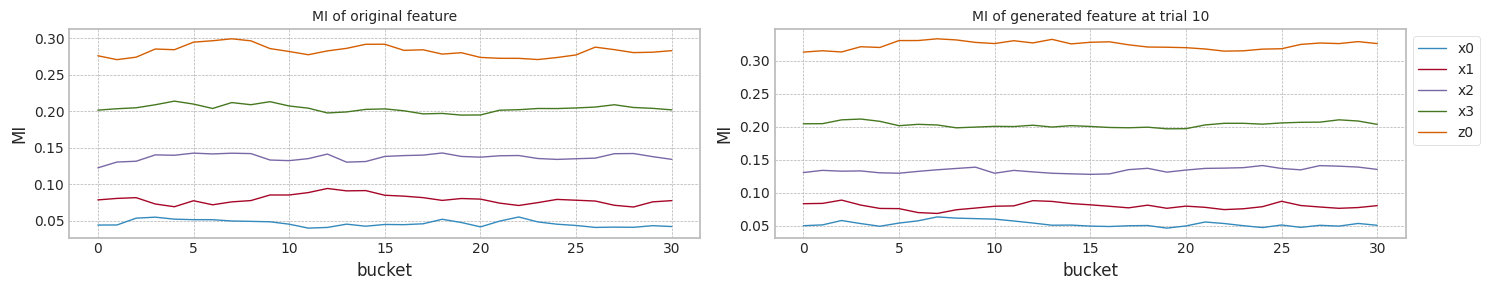

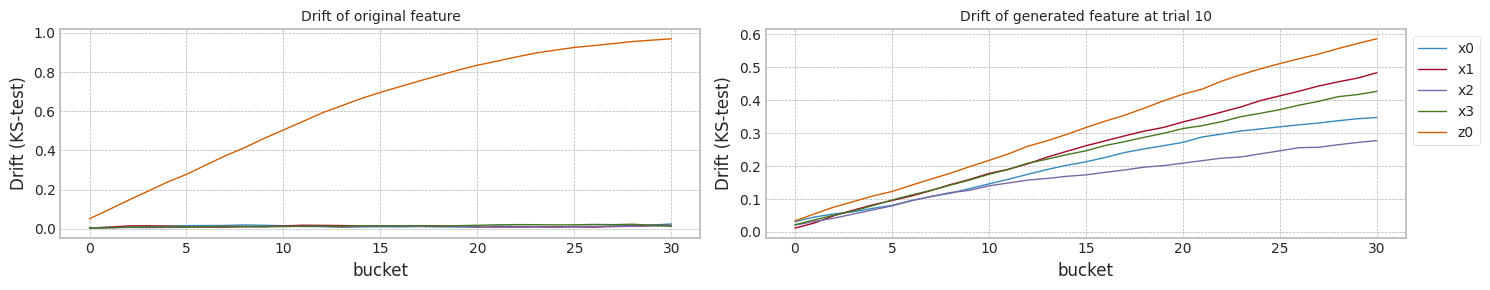

@ Normal model


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.912186    0.910003  0.769416  0.677622      5.752225
1      1.0    0.911321    0.909324  0.770652  0.677672      5.807793
2      2.0    0.912550    0.909343  0.768788  0.677723      5.847786
3      3.0    0.911714    0.909480  0.770463  0.678979      5.939474
4      4.0    0.910668    0.908722  0.765128  0.676221      5.842838
5      5.0    0.911675    0.909577  0.768672  0.676871      5.711846
6      6.0    0.912102    0.909459  0.767951  0.677221      5.668533
7      7.0    0.911969    0.909790  0.769591  0.677723      5.666984
8      8.0    0.911596    0.909363  0.770442  0.678325      5.724682
9      9.0    0.912030    0.909577  0.770769  0.678828      5.852972
10    10.0    0.911755    0.909655  0.769486  0.676871      5.892895
11    11.0    0.910986    0.908819  0.767392  0.678526      5.824068
12    12.0    0.668541    0.666963  0.666541  0.674228      6.185191
13    13.0    0.912030    0.909577  0.770133  0.677773      5.820685
14    14.0    0.910472    0.908838  0.765448  0.675771      5.763477
15    15.0    0.911656    0.909655  0.770252  0.677271      5.862804
16    16.0    0.911851    0.909557  0.769525  0.677522      5.929221
17    17.0    0.911870    0.909518  0.769530  0.677572      5.825998
18    18.0    0.911675    0.909557  0.770299  0.677472      5.855958
19    19.0    0.911615    0.909499  0.764921  0.675323      5.782277
20  median    0.911695    0.909509  0.769506  0.677547      5.825033
21     std    0.054368    0.054220  0.022959  0.001167      0.113716

@ SEA


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.912186    0.910003  0.814652  0.714386      9.972792
1      1.0    0.911321    0.909324  0.810604  0.706654      7.962313
2      2.0    0.912550    0.909343  0.814721  0.714063      8.129900
3      3.0    0.911714    0.909480  0.814785  0.717478      7.810131
4      4.0    0.910668    0.908722  0.808714  0.709118      8.475488
5      5.0    0.911675    0.909577  0.813597  0.709337      9.997311
6      6.0    0.912102    0.909459  0.813988  0.712551      7.804536
7      7.0    0.911969    0.909790  0.810835  0.708514      7.507755
8      8.0    0.911596    0.909363  0.812353  0.711996      7.849080
9      9.0    0.912030    0.909577  0.814217  0.715291      8.247360
10    10.0    0.911755    0.909655  0.769290  0.676871      5.783376
11    11.0    0.910986    0.908819  0.808946  0.709677     10.454482
12    12.0    0.668541    0.666963  0.767690  0.804764      9.450602
13    13.0    0.912030    0.909577  0.813448  0.713328      8.548854
14    14.0    0.910472    0.908838  0.808908  0.706273      9.556499
15    15.0    0.911656    0.909655  0.810366  0.706545      7.793854
16    16.0    0.911851    0.909557  0.810886  0.707692      8.258949
17    17.0    0.911870    0.909518  0.811255  0.710163      7.860244
18    18.0    0.911675    0.909557  0.810282  0.706436      7.585860
19    19.0    0.911615    0.909499  0.806856  0.703018      8.423678
20  median    0.911695    0.909509  0.810861  0.709507      8.188630
21     std    0.054368    0.054220  0.013479  0.023079      1.075564

@ AUE2


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.912186    0.910003  0.776755  0.681051      8.192509
1      1.0    0.911321    0.909324  0.778405  0.681710      7.259207
2      2.0    0.912550    0.909343  0.776190  0.681558      7.306763
3      3.0    0.911714    0.909480  0.778518  0.685077      7.298551
4      4.0    0.910668    0.908722  0.772033  0.679433      7.523658
5      5.0    0.911675    0.909577  0.776143  0.680696      8.126734
6      6.0    0.912102    0.909459  0.775482  0.681051      7.642913
7      7.0    0.911969    0.909790  0.776760  0.681203      7.917581
8      8.0    0.911596    0.909363  0.777978  0.682269      7.939810
9      9.0    0.912030    0.909577  0.778641  0.683491      7.834861
10    10.0    0.911755    0.909655  0.776216  0.680241     10.809804
11    11.0    0.910986    0.908819  0.773019  0.681405     11.149409
12    12.0    0.668541    0.666963  0.743847  0.740669     10.850400
13    13.0    0.912030    0.909577  0.777258  0.681405      7.264456
14    14.0    0.910472    0.908838  0.771858  0.678325      7.596338
15    15.0    0.911656    0.909655  0.777507  0.681051      8.232409
16    16.0    0.911851    0.909557  0.776756  0.681051      7.400733
17    17.0    0.911870    0.909518  0.776488  0.681152      7.507651
18    18.0    0.911675    0.909557  0.777409  0.681152      7.918080
19    19.0    0.911615    0.909499  0.771227  0.677372      7.625295
20  median    0.911695    0.909509  0.776621  0.681152      7.738887
21     std    0.054368    0.054220  0.007539  0.013419      1.231917

@ DTEL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.912186    0.910003  0.857754  0.799335     12.765839
1      1.0    0.911321    0.909324  0.858995  0.800315     13.221399
2      2.0    0.912550    0.909343  0.856410  0.796270     11.824117
3      3.0    0.911714    0.909480  0.857405  0.797590     12.599242
4      4.0    0.910668    0.908722  0.854737  0.793436     12.521132
5      5.0    0.911675    0.909577  0.857373  0.797451     11.685832
6      6.0    0.912102    0.909459  0.856540  0.798776     12.308850
7      7.0    0.911969    0.909790  0.858311  0.800877     12.925033
8      8.0    0.911596    0.909363  0.857926  0.798217     13.057034
9      9.0    0.912030    0.909577  0.858205  0.799230     13.571147
10    10.0    0.911755    0.909655  0.858423  0.799895     12.490894
11    11.0    0.910986    0.908819  0.856914  0.802319     11.571340
12    12.0    0.668541    0.666963  0.767783  0.799685     12.469798
13    13.0    0.912030    0.909577  0.858228  0.800105     12.726907
14    14.0    0.910472    0.908838  0.855007  0.792508     12.638138
15    15.0    0.911656    0.909655  0.858702  0.800105     13.034578
16    16.0    0.911851    0.909557  0.858122  0.800175     12.320734
17    17.0    0.911870    0.909518  0.858533  0.805612     13.386477
18    18.0    0.911675    0.909557  0.858699  0.803096     14.406025
19    19.0    0.911615    0.909499  0.855435  0.792577     12.685743
20  median    0.911695    0.909509  0.857840  0.799510     12.661940
21     std    0.054368    0.054220  0.020091  0.003313      0.657537

@ G-CDTL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.920649    0.922201  0.716949  0.152853      6.067827
1      1.0    0.922552    0.924489  0.911542  0.871923      5.965378
2      2.0    0.921467    0.923162  0.900116  0.853383      5.849413
3      3.0    0.922211    0.924254  0.656477  0.152946      6.357723
4      4.0    0.921549    0.923401  0.916899  0.899858      5.856130
5      5.0    0.922553    0.923857  0.880666  0.799231      5.767540
6      6.0    0.920352    0.922260  0.883675  0.777995      5.773129
7      7.0    0.921668    0.923435  0.918685  0.909382      5.923666
8      8.0    0.921844    0.923858  0.904958  0.863104      5.784944
9      9.0    0.922011    0.923213  0.917097  0.909886      5.850436
10    10.0    0.921601    0.923043  0.925368  0.929218      5.758015
11    11.0    0.922095    0.924182  0.907733  0.865455      5.811481
12    12.0    0.922753    0.923813  0.794661  0.674725      5.987139
13    13.0    0.922214    0.924232  0.882763  0.775524      5.903954
14    14.0    0.921770    0.923537  0.917157  0.891010      5.910727
15    15.0    0.921244    0.922838  0.885862  0.776249      5.869926
16    16.0    0.922264    0.924199  0.919760  0.907714      5.812354
17    17.0    0.920992    0.922753  0.920590  0.906480      5.760287
18    18.0    0.920485    0.922328  0.921590  0.912842      5.761015
19    19.0    0.921428    0.922616  0.922986  0.922256      5.987980
20  median    0.921719    0.923418  0.909638  0.868689      5.853283
21     std    0.000686    0.000722  0.072966  0.226837      0.142221

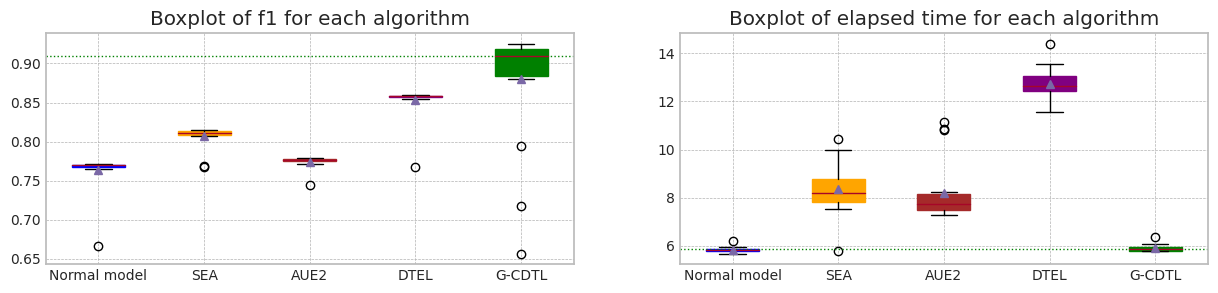

In [53]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

+ $P_t(y,X) \ne P_{t+w}(y,X) $ 이고 $P_t(y|X) \ne P_{t+w}(y|X) $
+ 전체적으로는 Real concept drift
+ 즉, P(y|X)와 P(X)의 변화가 연관되어 나타남.
+ $x_0$ : No drift
+ $x_1$ : $P_t(y|X) = P_{t+w}(y|X)$ 이면서 $P_t(X) \ne P_{t+w}(X)$ 인 Virtual Drift
+ $x_2$ : $P_t(y|X) \ne P_{t+w}(y|X)$ 이면서 $P_t(X) \ne P_{t+w}(X)$ 인 Real Concept Drift, MI 감소, Drift 증가
+ $x_3$ : $P_t(y|X) \ne P_{t+w}(y|X)$ 이면서 $P_t(X) \ne P_{t+w}(X)$ 인 Real Concept Drift, MI 증가, Drift 증가
+ $z_0$ : $P_t(y|X) \ne P_{t+w}(y|X)$ 이면서 $P_t(X) = P_{t+w}(X)$ 인 Actual Drift, MI 감소, Drift 고정


### Dataset 준비

In [54]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.51it/s]


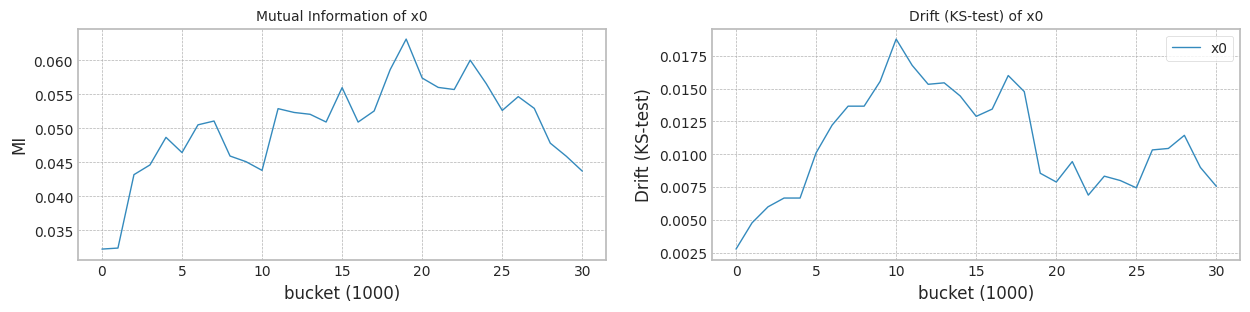

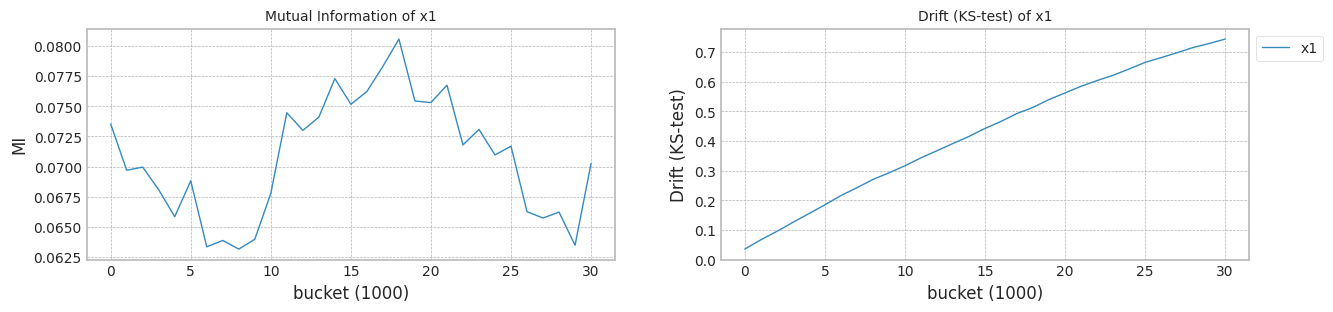

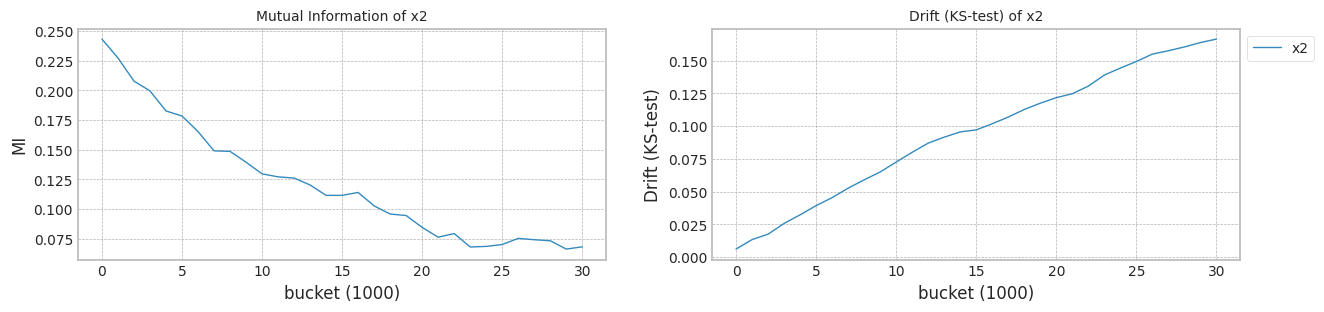

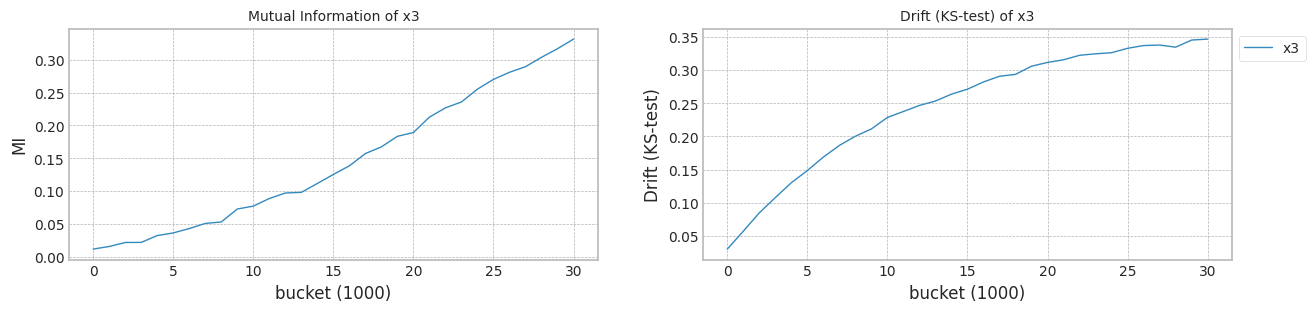

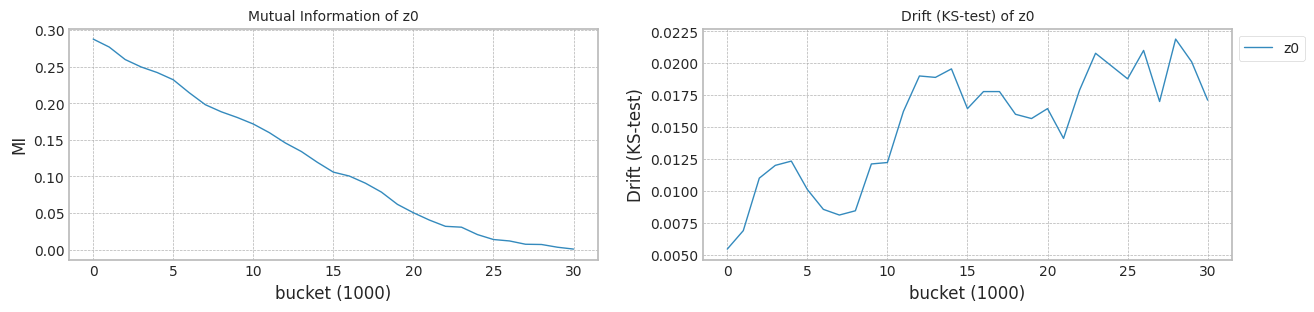

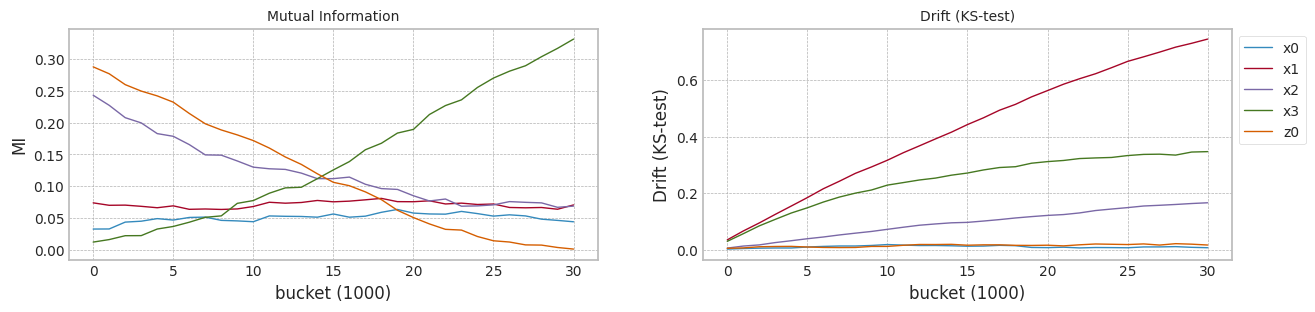

In [55]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

In [56]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]


trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 601.06it/s]


Test f1 score: 0.9403359721954044
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8740688364869764
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 246.53it/s]


Test f1 score: 0.9411650861234758
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


mean of drift:
x0    0.043215
x1    0.419498
x2    0.096839
x3    0.231168
z0    0.106645
dtype: float64
Mean F1 for all data: 0.8757632976821079
Normal model median        : 0.8740688364869764
Drift tolerant model median: 0.8757632976821079
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 635.72it/s]


Test f1 score: 0.9397334363531002
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8630279203582482
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.36it/s]


Test f1 score: 0.9402537038830251
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.08it/s]


mean of drift:
x0    0.166957
x1    0.428312
x2    0.249846
x3    0.339824
z0    0.166470
dtype: float64
Mean F1 for all data: 0.8663166921245745
Normal model median        : 0.8685483784226122
Drift tolerant model median: 0.8710399949033412
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 611.11it/s]


Test f1 score: 0.9404062770771157
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.11it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8743677460948698
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 250.11it/s]


Test f1 score: 0.9405604576747794
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.064093
x1    0.390738
x2    0.110269
x3    0.324946
z0    0.109265
dtype: float64
Mean F1 for all data: 0.8700512020076051
Normal model median        : 0.8740688364869764
Drift tolerant model median: 0.8700512020076051
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 630.04it/s]


Test f1 score: 0.9397590361445783
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8734784588008035
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.77it/s]


Test f1 score: 0.9425087108013938
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.038484
x1    0.416258
x2    0.166287
x3    0.300007
z0    0.162111
dtype: float64
Mean F1 for all data: 0.8810751345287521
Normal model median        : 0.87377364764389
Drift tolerant model median: 0.8729072498448565
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 630.02it/s]


Test f1 score: 0.9398242055442867
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8628459451148504
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.13it/s]


Test f1 score: 0.9402552204176334
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.217158
x1    0.440706
x2    0.238111
x3    0.193864
z0    0.109014
dtype: float64
Mean F1 for all data: 0.8606173642774116
Normal model median        : 0.8734784588008035
Drift tolerant model median: 0.8700512020076051
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 627.24it/s]


Test f1 score: 0.9402913089611267
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8621148871663009
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.22it/s]


Test f1 score: 0.9411536972512582
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.015896
x1    0.405645
x2    0.369290
x3    0.385484
z0    0.266265
dtype: float64
Mean F1 for all data: 0.7913999353065936
Normal model median        : 0.8682531895795258
Drift tolerant model median: 0.8681839470660898
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 637.86it/s]


Test f1 score: 0.9406673718626792
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.45it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8744410294827278
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 251.20it/s]


Test f1 score: 0.9413696513087995
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.069749
x1    0.417900
x2    0.082677
x3    0.312699
z0    0.145889
dtype: float64
Mean F1 for all data: 0.8721667651082503
Normal model median        : 0.8734784588008035
Drift tolerant model median: 0.8700512020076051
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.26it/s]


Test f1 score: 0.9399845619451949
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8741614728517169
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:15<00:00, 250.47it/s]


Test f1 score: 0.942073759413014
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.035308
x1    0.417401
x2    0.034613
x3    0.299505
z0    0.181875
dtype: float64
Mean F1 for all data: 0.8923487002058543
Normal model median        : 0.87377364764389
Drift tolerant model median: 0.8711089835579278
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 651.80it/s]


Test f1 score: 0.9404612563929364
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8736823670222812
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.74it/s]


Test f1 score: 0.9406869859700048
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.195262
x1    0.419839
x2    0.253875
x3    0.337771
z0    0.144889
dtype: float64
Mean F1 for all data: 0.8641442732505913
Normal model median        : 0.8736823670222812
Drift tolerant model median: 0.8700512020076051
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 624.46it/s]


Test f1 score: 0.9393353941267388
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8710272498439066
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 246.94it/s]


Test f1 score: 0.7279151943462897
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.024674
x1    0.426717
x2    0.090871
x3    0.246140
z0    0.027946
dtype: float64
Mean F1 for all data: 0.6746771622573732
Normal model median        : 0.8735804129115423
Drift tolerant model median: 0.8681839470660898
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 628.94it/s]


Test f1 score: 0.9402236791361358
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8703896258131328
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.22it/s]


Test f1 score: 0.9402289928197166
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.055022
x1    0.424832
x2    0.142692
x3    0.296326
z0    0.197097
dtype: float64
Mean F1 for all data: 0.872688590382524
Normal model median        : 0.8734784588008035
Drift tolerant model median: 0.8700512020076051
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 636.58it/s]


Test f1 score: 0.9401659911214051
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8727390795134309
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.06it/s]


Test f1 score: 0.940811779521457
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.360014
x1    0.426720
x2    0.090731
x3    0.238545
z0    0.081244
dtype: float64
Mean F1 for all data: 0.844145165420965
Normal model median        : 0.8731087691571172
Drift tolerant model median: 0.8681839470660898
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 651.06it/s]


Test f1 score: 0.9410406848129269
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8722515810536773
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.20it/s]


Test f1 score: 0.940424295263005
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.086072
x1    0.367932
x2    0.065423
x3    0.388283
z0    0.107226
dtype: float64
Mean F1 for all data: 0.7896103817352828
Normal model median        : 0.8727390795134309
Drift tolerant model median: 0.8663166921245745
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.81it/s]


Test f1 score: 0.9402797877472263
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8720060801417402
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 248.10it/s]


Test f1 score: 0.9405509908168197
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.078982
x1    0.414932
x2    0.192566
x3    0.201344
z0    0.193749
dtype: float64
Mean F1 for all data: 0.8092315343857088
Normal model median        : 0.8724953302835541
Drift tolerant model median: 0.865230482687583
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 642.77it/s]


Test f1 score: 0.9401099430996238
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8733311369894807
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.63it/s]


Test f1 score: 0.941165067364544
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.45it/s]


mean of drift:
x0    0.024125
x1    0.447620
x2    0.230462
x3    0.230513
z0    0.091903
dtype: float64
Mean F1 for all data: 0.868342399948582
Normal model median        : 0.8727390795134309
Drift tolerant model median: 0.8663166921245745
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 646.24it/s]


Test f1 score: 0.9398242055442867
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8630069523397041
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 249.57it/s]


Test f1 score: 0.9404140065776747
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.045545
x1    0.411885
x2    0.203935
x3    0.218516
z0    0.371832
dtype: float64
Mean F1 for all data: 0.7988172877220665
Normal model median        : 0.8724953302835541
Drift tolerant model median: 0.865230482687583
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 636.43it/s]


Test f1 score: 0.939835828102366
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8630312233179018
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.66it/s]


Test f1 score: 0.9399108354332235
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.024269
x1    0.412821
x2    0.099832
x3    0.340125
z0    0.231810
dtype: float64
Mean F1 for all data: 0.8366458613847705
Normal model median        : 0.8722515810536773
Drift tolerant model median: 0.8641442732505913
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 619.68it/s]


Test f1 score: 0.9404635952678657
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8686962633192565
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.63it/s]


Test f1 score: 0.9413129652905347
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.17it/s]


mean of drift:
x0    0.012050
x1    0.423996
x2    0.184609
x3    0.288971
z0    0.092892
dtype: float64
Mean F1 for all data: 0.8690976438717765
Normal model median        : 0.8721288305977087
Drift tolerant model median: 0.865230482687583
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 641.19it/s]


Test f1 score: 0.9395869523258058
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.07it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8684280601082662
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 247.17it/s]


Test f1 score: 0.9401858304297329
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.097258
x1    0.390573
x2    0.157663
x3    0.189319
z0    0.209473
dtype: float64
Mean F1 for all data: 0.8701381962756537
Normal model median        : 0.8720060801417402
Drift tolerant model median: 0.8663166921245745
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.50it/s]


Test f1 score: 0.9402797877472263
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8722324279639772
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 246.35it/s]


Test f1 score: 0.9391996891996891
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.092896
x1    0.369735
x2    0.042111
x3    0.247204
z0    0.096000
dtype: float64
Mean F1 for all data: 0.8489277680122351
Normal model median        : 0.8721192540528586
Drift tolerant model median: 0.865230482687583
######################### Trial 0 for Normal model ###########################
retrain_interval: 16
######################### Trial 0 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.39it/s]


Early stop at  2708.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8849439342453453
SEA median: 0.8849439342453453
######################### Trial 0 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.30it/s]


Early stop at  2910.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8749075060184532
AUE median: 0.8749075060184532
######################### Trial 0 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


Early stop at  1615.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8939118763328415
DTEL median: 0.8939118763328415
######################### Trial 1 for Normal model ###########################
retrain_interval: 16
######################### Trial 1 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.19it/s]


Early stop at  1352.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8793855000178631
SEA median: 0.8821647171316043
######################### Trial 1 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.39it/s]


Early stop at  2830.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8643121703596821
AUE median: 0.8696098381890677
######################### Trial 1 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


Early stop at  2170.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8929891028241665
DTEL median: 0.893450489578504
######################### Trial 2 for Normal model ###########################
retrain_interval: 16
######################### Trial 2 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.47it/s]


Early stop at  2637.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8860467164168518
SEA median: 0.8849439342453453
######################### Trial 2 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.83it/s]


Early stop at  1857.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8762973640791278
AUE median: 0.8749075060184532
######################### Trial 2 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


Early stop at  2110.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8929053882088751
DTEL median: 0.8929891028241665
######################### Trial 3 for Normal model ###########################
retrain_interval: 16
######################### Trial 3 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.34it/s]


Early stop at  1224.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8851612198250666
SEA median: 0.885052577035206
######################### Trial 3 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


Early stop at  1799.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8754504989137845
AUE median: 0.8751790024661188
######################### Trial 3 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.27it/s]


Early stop at  2621.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8932005323931621
DTEL median: 0.8930948176086644
######################### Trial 4 for Normal model ###########################
retrain_interval: 16
######################### Trial 4 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.31it/s]


Early stop at  1299.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8788606470763233
SEA median: 0.8849439342453453
######################### Trial 4 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.79it/s]


Early stop at  1890.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8643764792028457
AUE median: 0.8749075060184532
######################### Trial 4 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Early stop at  978.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8927976153435275
DTEL median: 0.8929891028241665
######################### Trial 5 for Normal model ###########################
retrain_interval: 16
######################### Trial 5 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.77it/s]


Early stop at  1950.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8792629674278268
SEA median: 0.8821647171316043
######################### Trial 5 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.23it/s]


Early stop at  1124.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8640396517218635
AUE median: 0.8696419926106495
######################### Trial 5 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Early stop at  1224.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8917246195694906
DTEL median: 0.8929472455165208
######################### Trial 6 for Normal model ###########################
retrain_interval: 16
######################### Trial 6 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.27it/s]


Early stop at  1218.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8863963900207288
SEA median: 0.8849439342453453
######################### Trial 6 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.32it/s]


Early stop at  1182.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8768498251449239
AUE median: 0.8749075060184532
######################### Trial 6 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


Early stop at  3220.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8918563388038233
DTEL median: 0.8929053882088751
######################### Trial 7 for Normal model ###########################
retrain_interval: 16
######################### Trial 7 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.95it/s]


Early stop at  1567.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8851139527881364
SEA median: 0.8850289435167409
######################### Trial 7 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.36it/s]


Early stop at  1144.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8755628224852782
AUE median: 0.8751790024661188
######################### Trial 7 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Early stop at  1645.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8936381621602479
DTEL median: 0.8929472455165208
######################### Trial 8 for Normal model ###########################
retrain_interval: 16
######################### Trial 8 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.03it/s]


Early stop at  1676.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8849238873555482
SEA median: 0.8849439342453453
######################### Trial 8 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.35it/s]


Early stop at  2843.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8748087132109471
AUE median: 0.8749075060184532
######################### Trial 8 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


Early stop at  1943.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8926923031737861
DTEL median: 0.8929053882088751
######################### Trial 9 for Normal model ###########################
retrain_interval: 16
######################### Trial 9 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.97it/s]


Early stop at  1737.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8834562641422586
SEA median: 0.8849339108004468
######################### Trial 9 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.59it/s]


Early stop at  2252.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8732082850646476
AUE median: 0.8748581096147001
######################### Trial 9 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


Early stop at  2150.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8933332778814669
DTEL median: 0.8929472455165208
######################### Trial 10 for Normal model ###########################
retrain_interval: 16
######################### Trial 10 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8833926574938412
SEA median: 0.8849238873555482
######################### Trial 10 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8717633501450847
AUE median: 0.8748087132109471
######################### Trial 10 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Early stop at  1403.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8936625539692407
DTEL median: 0.8929891028241665
######################### Trial 11 for Normal model ###########################
retrain_interval: 16
######################### Trial 11 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.39it/s]


Early stop at  1127.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8845636346728445
SEA median: 0.8847437610141964
######################### Trial 11 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8738978431588239
AUE median: 0.8743532781848855
######################### Trial 11 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.18it/s]


Early stop at  3078.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8928838328922433
DTEL median: 0.8929472455165208
######################### Trial 12 for Normal model ###########################
retrain_interval: 16
######################### Trial 12 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.60it/s]


Early stop at  2457.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8838861495665621
SEA median: 0.8845636346728445
######################### Trial 12 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.876030334339587
AUE median: 0.8748087132109471
######################### Trial 12 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.29it/s]


Early stop at  2608.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8926654045902609
DTEL median: 0.8929053882088751
######################### Trial 13 for Normal model ###########################
retrain_interval: 16
######################### Trial 13 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.88it/s]


Early stop at  1856.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.884206119134542
SEA median: 0.8843848769036933
######################### Trial 13 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Early stop at  nan
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8737262647677925
AUE median: 0.8743532781848855
######################### Trial 13 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Early stop at  1664.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8938958918583804
DTEL median: 0.8929472455165208
######################### Trial 14 for Normal model ###########################
retrain_interval: 16
######################### Trial 14 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.31it/s]


Early stop at  3025.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8849476040430863
SEA median: 0.8845636346728445
######################### Trial 14 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.91it/s]


Early stop at  1737.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8748798579916953
AUE median: 0.8748087132109471
######################### Trial 14 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.20it/s]


Early stop at  2834.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8938684551511831
DTEL median: 0.8929891028241665
######################### Trial 15 for Normal model ###########################
retrain_interval: 16
######################### Trial 15 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.90it/s]


Early stop at  1700.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8797955536162506
SEA median: 0.8843848769036933
######################### Trial 15 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]


Early stop at  1912.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8645241017773673
AUE median: 0.8743532781848855
######################### Trial 15 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Early stop at  1290.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8928661510677498
DTEL median: 0.8929472455165208
######################### Trial 16 for Normal model ###########################
retrain_interval: 16
######################### Trial 16 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.32it/s]


Early stop at  1193.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8790585930286112
SEA median: 0.884206119134542
######################### Trial 16 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.49it/s]


Early stop at  2464.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8644140975152123
AUE median: 0.8738978431588239
######################### Trial 16 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.47it/s]


Early stop at  1565.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8925605862826143
DTEL median: 0.8929053882088751
######################### Trial 17 for Normal model ###########################
retrain_interval: 16
######################### Trial 17 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Early stop at  1880.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8844768242510674
SEA median: 0.8843414716928046
######################### Trial 17 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.01it/s]


Early stop at  1601.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8702670192484308
AUE median: 0.8738120539633082
######################### Trial 17 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


Early stop at  1861.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8938628355153825
DTEL median: 0.8929472455165208
######################### Trial 18 for Normal model ###########################
retrain_interval: 16
######################### Trial 18 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.96it/s]


Early stop at  1457.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8821460952649187
SEA median: 0.884206119134542
######################### Trial 18 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.95it/s]


Early stop at  1728.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8705435722933863
AUE median: 0.8737262647677925
######################### Trial 18 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Early stop at  2949.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8922321188889103
DTEL median: 0.8929053882088751
######################### Trial 19 for Normal model ###########################
retrain_interval: 16
######################### Trial 19 for SEA ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


Early stop at  2192.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8841460395191124
SEA median: 0.8841760793268272
######################### Trial 19 for AUE ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.96it/s]


Early stop at  1662.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8750291211335828
AUE median: 0.8738120539633082
######################### Trial 19 for DTEL ###########################
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:14<00:00,  2.19it/s]


Early stop at  3014.0
Mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8924404631215777
DTEL median: 0.8928946105505592


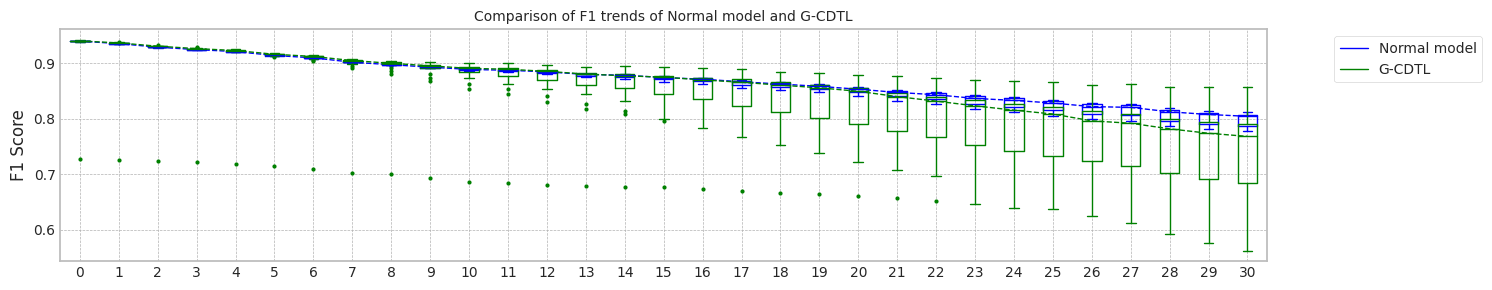

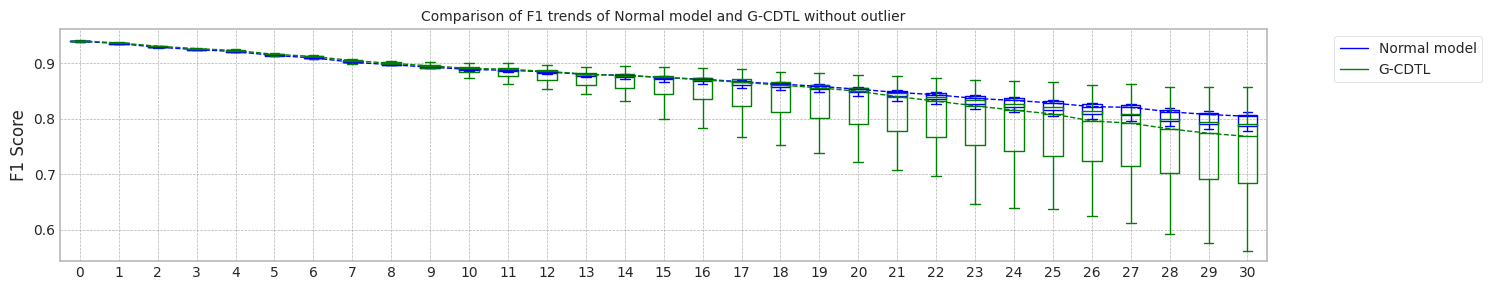

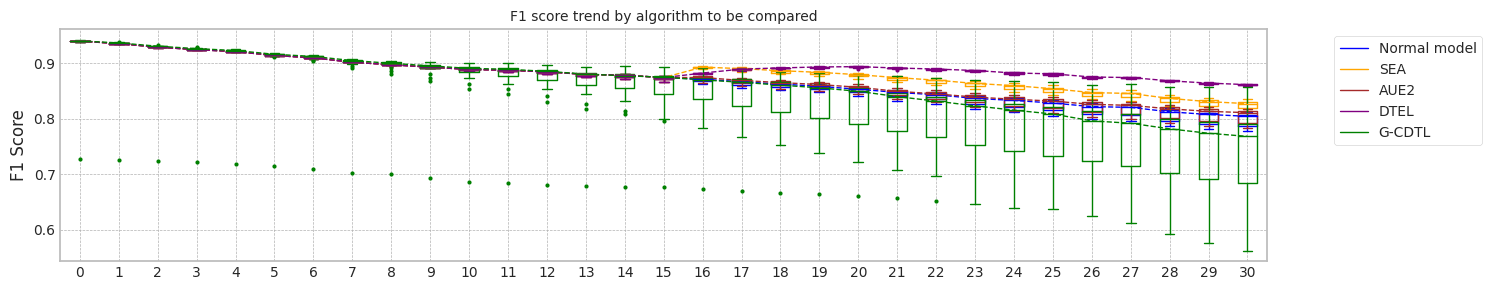

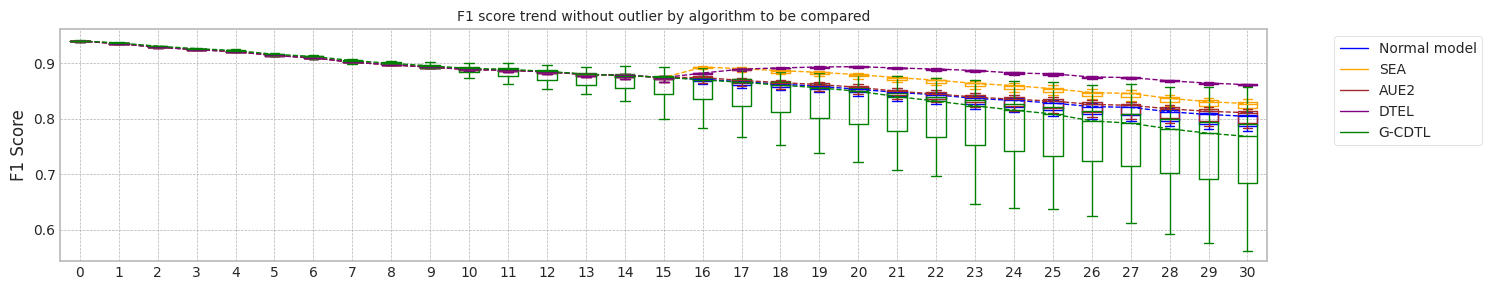

max_mean_trial= 7


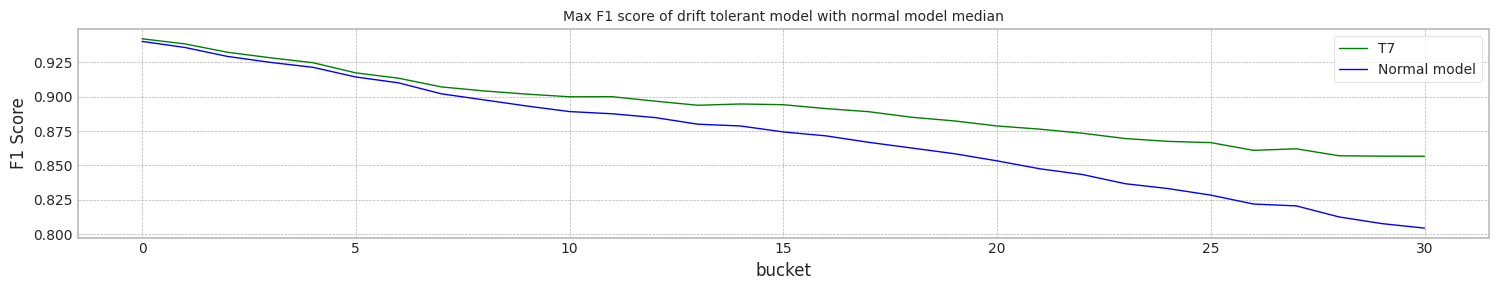

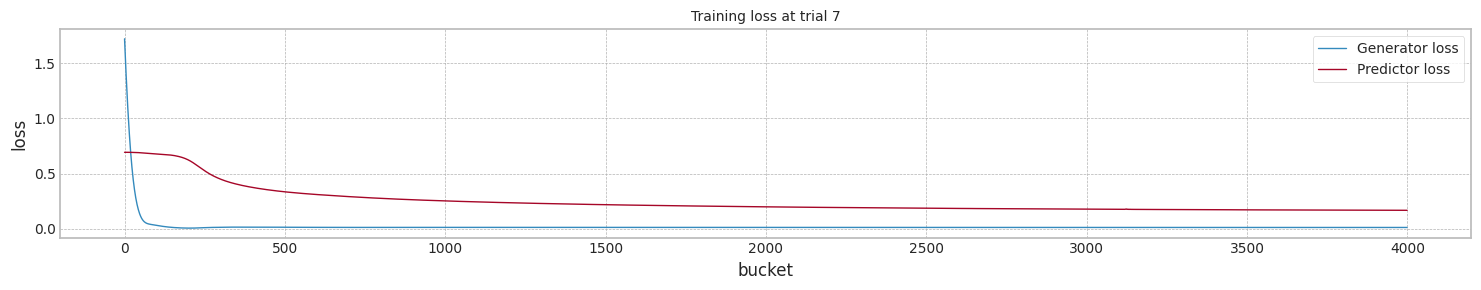

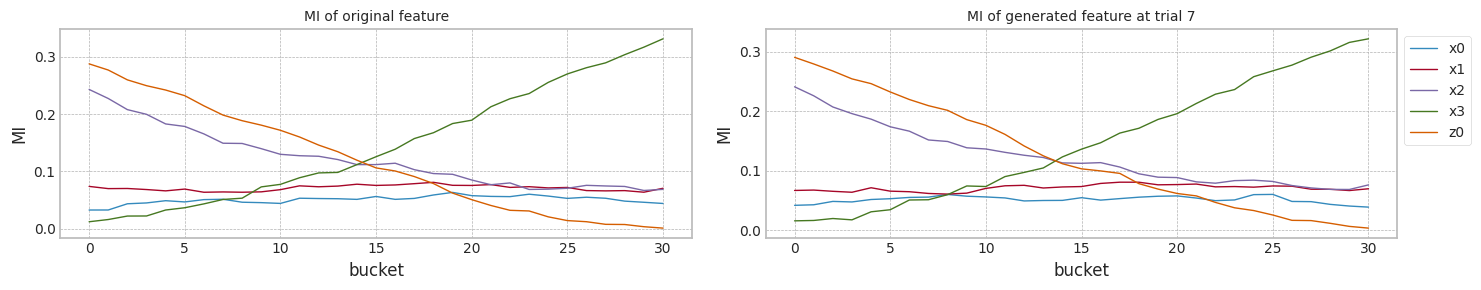

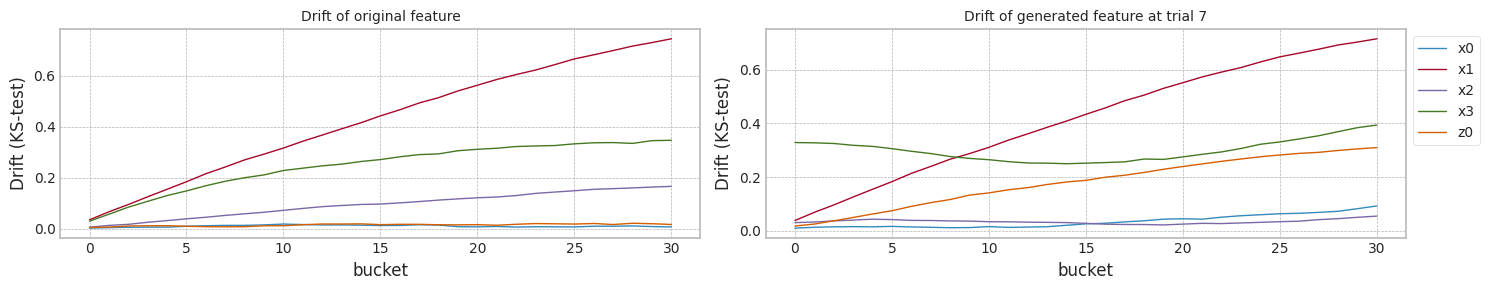

@ Normal model


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.940336    0.936047  0.874069  0.808469      6.124717
1      1.0    0.939733    0.935055  0.863028  0.779305      5.910728
2      2.0    0.940406    0.936039  0.874368  0.811646      6.108460
3      3.0    0.939759    0.935490  0.873478  0.807452      5.946182
4      4.0    0.939824    0.934965  0.862846  0.778818      5.853108
5      5.0    0.940291    0.935450  0.862115  0.777732      5.871035
6      6.0    0.940667    0.936653  0.874441  0.810138      5.736159
7      7.0    0.939985    0.935891  0.874161  0.810841      5.902495
8      8.0    0.940461    0.936072  0.873682  0.809036      5.937201
9      9.0    0.939335    0.935148  0.871027  0.799957      5.888774
10    10.0    0.940224    0.935683  0.870390  0.797853      5.741481
11    11.0    0.940166    0.935891  0.872739  0.806960      5.749708
12    12.0    0.941041    0.937127  0.872252  0.805253      5.829798
13    13.0    0.940280    0.936096  0.872006  0.803984      5.874768
14    14.0    0.940110    0.935658  0.873331  0.807045      5.795864
15    15.0    0.939824    0.935055  0.863007  0.778899      5.952357
16    16.0    0.939836    0.935055  0.863031  0.779305      5.860076
17    17.0    0.940464    0.936395  0.868696  0.789350      5.740896
18    18.0    0.939587    0.935493  0.868428  0.792996      6.165759
19    19.0    0.940280    0.936059  0.872232  0.804970      5.853825
20  median    0.940195    0.935787  0.872119  0.804477      5.872901
21     std    0.000401    0.000577  0.004564  0.012700      0.124162

@ SEA


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.940336    0.936047  0.884944  0.829306      9.201793
1      1.0    0.939733    0.935055  0.879386  0.816598      7.449080
2      2.0    0.940406    0.936039  0.886047  0.835460      8.979897
3      3.0    0.939759    0.935490  0.885161  0.832525      7.179152
4      4.0    0.939824    0.934965  0.878861  0.813747      7.241696
5      5.0    0.940291    0.935450  0.879263  0.818727      8.263925
6      6.0    0.940667    0.936653  0.886396  0.835289      7.310935
7      7.0    0.939985    0.935891  0.885114  0.830206      7.895073
8      8.0    0.940461    0.936072  0.884924  0.829902      7.742397
9      9.0    0.939335    0.935148  0.883456  0.826169      7.850374
10    10.0    0.940224    0.935683  0.883393  0.825594     10.644758
11    11.0    0.940166    0.935891  0.884564  0.828156      7.107007
12    12.0    0.941041    0.937127  0.883886  0.829196      8.656966
13    13.0    0.940280    0.936096  0.884206  0.826111      8.034650
14    14.0    0.940110    0.935658  0.884948  0.830371      9.419917
15    15.0    0.939824    0.935055  0.879796  0.817617      7.986405
16    16.0    0.939836    0.935055  0.879059  0.814895      7.223418
17    17.0    0.940464    0.936395  0.884477  0.826581      8.192729
18    18.0    0.939587    0.935493  0.882146  0.820298      7.875699
19    19.0    0.940280    0.936059  0.884146  0.828433      8.620082
20  median    0.940195    0.935787  0.884176  0.827369      7.940739
21     std    0.000401    0.000577  0.002509  0.006566      0.902307

@ AUE2


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.940336    0.936047  0.874908  0.813015      9.432311
1      1.0    0.939733    0.935055  0.864312  0.785252      9.200330
2      2.0    0.940406    0.936039  0.876297  0.817193      8.143288
3      3.0    0.939759    0.935490  0.875450  0.815568      8.084526
4      4.0    0.939824    0.934965  0.864376  0.785208      8.227631
5      5.0    0.940291    0.935450  0.864040  0.783767      7.374806
6      6.0    0.940667    0.936653  0.876850  0.818309      7.224867
7      7.0    0.939985    0.935891  0.875563  0.814632      7.168599
8      8.0    0.940461    0.936072  0.874809  0.814767      9.292934
9      9.0    0.939335    0.935148  0.873208  0.807427      8.675583
10    10.0    0.940224    0.935683  0.871763  0.802236     10.840194
11    11.0    0.940166    0.935891  0.873898  0.811597     10.758225
12    12.0    0.941041    0.937127  0.876030  0.816810     10.689395
13    13.0    0.940280    0.936096  0.873726  0.810562     10.673106
14    14.0    0.940110    0.935658  0.874880  0.813109      7.971861
15    15.0    0.939824    0.935055  0.864524  0.785443      8.247551
16    16.0    0.939836    0.935055  0.864414  0.785450      8.939017
17    17.0    0.940464    0.936395  0.870267  0.795428      7.784534
18    18.0    0.939587    0.935493  0.870544  0.798823      7.904876
19    19.0    0.940280    0.936059  0.875029  0.814487      7.883175
20  median    0.940195    0.935787  0.873812  0.811080      8.237591
21     std    0.000401    0.000577  0.004716  0.012966      1.212039

@ DTEL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.940336    0.936047  0.893912  0.861898     12.558368
1      1.0    0.939733    0.935055  0.892989  0.862718     13.168100
2      2.0    0.940406    0.936039  0.892905  0.862763     13.103071
3      3.0    0.939759    0.935490  0.893201  0.861307     13.710960
4      4.0    0.939824    0.934965  0.892798  0.862913     12.201165
5      5.0    0.940291    0.935450  0.891725  0.860277     11.967984
6      6.0    0.940667    0.936653  0.891856  0.858688     14.416458
7      7.0    0.939985    0.935891  0.893638  0.862523     12.404178
8      8.0    0.940461    0.936072  0.892692  0.860366     12.829299
9      9.0    0.939335    0.935148  0.893333  0.860947     13.030559
10    10.0    0.940224    0.935683  0.893663  0.861922     12.181684
11    11.0    0.940166    0.935891  0.892884  0.860639     14.258382
12    12.0    0.941041    0.937127  0.892665  0.860524     13.599563
13    13.0    0.940280    0.936096  0.893896  0.863447     12.416862
14    14.0    0.940110    0.935658  0.893868  0.862650     14.114182
15    15.0    0.939824    0.935055  0.892866  0.862578     12.220415
16    16.0    0.939836    0.935055  0.892561  0.861464     12.572236
17    17.0    0.940464    0.936395  0.893863  0.861958     12.997127
18    18.0    0.939587    0.935493  0.892232  0.861349     13.978786
19    19.0    0.940280    0.936059  0.892440  0.861221     14.204396
20  median    0.940195    0.935787  0.892895  0.861681     13.013843
21     std    0.000401    0.000577  0.000667  0.001159      0.796058

@ G-CDTL


Trial  Testset F1  Initial F1   Mean F1   Last F1  Elapsed time
0      0.0    0.941165    0.937785  0.875763  0.803399      6.034251
1      1.0    0.940254    0.936505  0.866317  0.770876      6.145963
2      2.0    0.940560    0.937130  0.870051  0.786686      6.023029
3      3.0    0.942509    0.939314  0.881075  0.820656      5.879078
4      4.0    0.940255    0.937052  0.860617  0.765611      5.837854
5      5.0    0.941154    0.936942  0.791400  0.629740      5.897976
6      6.0    0.941370    0.937875  0.872167  0.786928      5.855330
7      7.0    0.942074    0.938384  0.892349  0.856714      5.852512
8      8.0    0.940687    0.937136  0.864144  0.756297      5.778423
9      9.0    0.727915    0.726475  0.674677  0.617405      5.878266
10    10.0    0.940229    0.936854  0.872689  0.795984      5.949841
11    11.0    0.940812    0.937033  0.844145  0.692379      5.921309
12    12.0    0.940424    0.936984  0.789610  0.561999      5.977840
13    13.0    0.940551    0.936858  0.809232  0.634447      5.746414
14    14.0    0.941165    0.938327  0.868342  0.774935      5.739694
15    15.0    0.940414    0.936640  0.798817  0.656690      5.770025
16    16.0    0.939911    0.935819  0.836646  0.703602      5.856397
17    17.0    0.941313    0.937706  0.869098  0.792274      6.045389
18    18.0    0.940186    0.937058  0.870138  0.790456      5.937209
19    19.0    0.939200    0.935694  0.848928  0.730341      5.760751
20  median    0.940556    0.937043  0.865230  0.768243      5.878672
21     std    0.047597    0.047131  0.050156  0.079608      0.111408

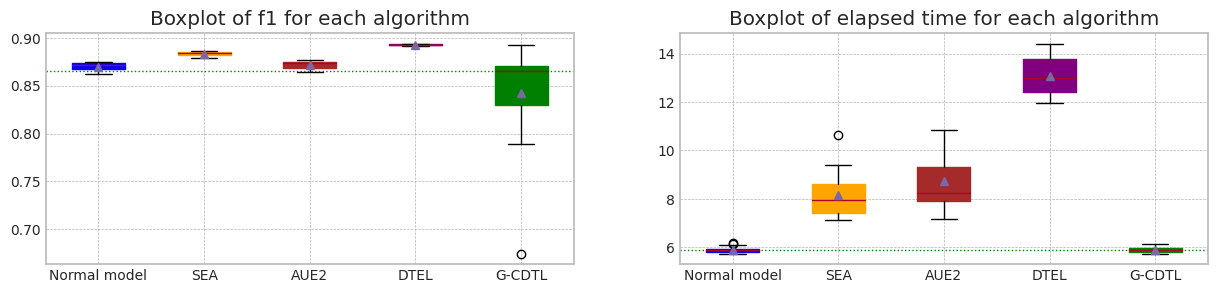

In [57]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b'])+1)

## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [ ]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

##### Data 정제

In [ ]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

In [ ]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

##### Dataset 만들기

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:

X[2010].shape

In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

In [ ]:
seed_everything(12)

X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

In [ ]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

#### 실험

In [ ]:
# 1/10 로 사이즈 줄이기...
seed_everything()

X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
s = np.sort(np.random.choice(X2.shape[0],int(X2.shape[0]/10),replace= False))
#print(s.shape)
X3 = pd.DataFrame(X2[s],columns=COLUMNS)
Y3 = Y2[s]



##### weight 초기화

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    #seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    discriminator = Discriminator(b_dim).to(device)
    discriminator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Generator(b_dim).to(device)
    adapter.apply(weights_init_normal)

    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)

    mine_loss = customLoss(mine).to(device)
    optimizer_M = torch.optim.Adam(mine_loss.parameters(), lr=0.001)
    #kld_loss = nn.KLDivLoss(reduction='batchmean')
    default_value = torch.tensor([0.5],dtype=torch.float32).to(device)
    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = discriminator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()
        '''
        if lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------

            xs_test = adapter(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
            #x_sample = Variable(torch.clone(xs_test), requires_grad = True)

            m_loss, lmd = mine_loss(xs_test,
                                    y_test, #generator(xs_test).reshape(-1,1),
                                    default_value)

            m_losses.append(-m_loss.cpu().data.numpy())
            f_losses.append(lmd.cpu().data.numpy())

            m_loss = m_loss.sum() * 0.01
            #m_loss.mean().backward()

            #lambda_f = lmd #.detach()
        else:
            m_loss = torch.tensor(0.0)
        '''

        lambda1 = 0.7

        if lambda_f >= 0.0:
            #loss =  lambda1*g_loss + (1-lambda1)*a_loss + torch.std(torch.tensor((g_loss,a_loss)))   #(1.0-lambda_f) * g_loss + lambda_f * a_loss + m_loss.mean()*0.01
            loss =  g_loss + a_loss + torch.std(torch.tensor((g_loss,a_loss)))
        else:
            loss = g_loss

        loss.backward()

        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1 = test_model(discriminator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Generator loss':a_losses,'Predictor loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,discriminator,adapter,df_loss

#### do

In [ ]:
seed_everything()

#s = np.sort(np.random.choice(len(COLUMNS),2,replace= False))
top_columns = list(mi_scores[0:5].index)
top_columns
print('columns:',top_columns)
#print(s.shape)
X4 = X3[top_columns]

train_size = 10000*2
test_size = 2000*2

X1,Y1 = check_mi_drift(X4, Y3, train_size, test_size)

bucket_size = 500*2
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

In [ ]:
seed_everything()

#s = np.sort(np.random.choice(len(COLUMNS),2,replace= False))
top_columns = list(mi_scores[0:5].index)
top_columns
print('columns:',top_columns)
#print(s.shape)
X4 = X3[top_columns]

train_size = 10000*2
test_size = 2000*2

X1,Y1 = check_mi_drift(X4, Y3, train_size, test_size)

bucket_size = 500*2
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

### #2 날짜 단위로 bucket 만들기

#### data 정제

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
#df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    #df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values


In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = list(COLUMNS))#[top_columns+['issue_d']]

In [ ]:
X2

In [ ]:
from datetime import date
from datetime import datetime

def date_bucket_num(d,start_day='20100101'):
    date1 = datetime.strptime(start_day, '%Y%m%d')
    date2 = datetime.strptime(str(d)+'01', '%Y%m%d')
    delta = date2 - date1
    return int(delta.days/30)

In [ ]:
X2['b'] = [date_bucket_num(d) for d in X2['issue_d']]

In [ ]:
b_cnt = X2.groupby(['b'])['b'].count()

In [ ]:
# 1/10 로 사이즈 줄이기...
seed_everything()
s = np.sort(np.random.choice(X2.shape[0],int(X2.shape[0]/10),replace= False))
#print(s.shape)
X3 = X2.iloc[s,:]
Y3 = Y2[s]

In [ ]:
b_cnt2 = X3.groupby(['b'])['b'].count()

In [ ]:
fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
ax[0].bar(b_cnt.index,b_cnt.values)
ax[0].set_ylabel('count')
ax[0].set_xlabel('month (from 201001)')
ax[0].set_title(f'Histogram per month for full dataset',fontdict={'fontsize':10})

ax[1].bar(b_cnt2.index,b_cnt2.values)
ax[1].set_ylabel('count')
ax[1].set_xlabel('month (from 201001)')
ax[1].set_title(f'Histogram per month for reduced(1/10) dataset',fontdict={'fontsize':10})

plt.show()

In [ ]:
X3.drop(columns=['issue_d'],inplace=True)

In [ ]:
X3

#### Drift tolerant 학습

In [ ]:
from more_itertools import locate
def find_indices(list_to_check, item_to_find):
    indices = locate(list_to_check, lambda x: x == item_to_find)
    return list(indices)

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    columns = X.columns
    is_Has_bucket = False
    # 'b' 즉, bucket count 가 있으며, 'b'를 제외 시킨다.
    if 'b' in columns:
        print('Dataset has buckets!')
        columns = columns[0:-1]
        buckets = list(X['b'])
        X = X[columns]
        is_Has_bucket = True

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    if is_Has_bucket:
        b_min = min(buckets[-X_live.shape[0]:])
        b_max = max(buckets[-X_live.shape[0]:])
        print(f'bucket range in live set {b_min}~{b_max}')
        for i in range(b_min,b_max+1):
            s = find_indices(buckets,i)
            if len(s) > 0:
                xl = X.iloc[s]
                yl = Y[s]
                X_live_set.append(xl)
                Y_live_set.append(yl)
    else:
        for i in range(int(X_live.shape[0]/test_size)):
            xl = X_live[i*test_size:i*test_size+train_size]
            yl = Y_live[i*test_size:i*test_size+train_size]

            if len(xl) ==  train_size:
                X_live_set.append(xl)
                Y_live_set.append(yl)
            else:
                #print(xl.shape)
                truncate_count = xl.shape[0] #truncate_count + len(xl)
                break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    for c_name in df_mis.columns:
        fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
        df_mis[c_name].plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
        ax[0].set_title(f'Mutual Information of {c_name}',fontdict={'fontsize':10})

        df_drf[c_name].plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
        ax[1].set_title(f'Drift (KS-test) of {c_name}',fontdict={'fontsize':10})
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    df_mis.plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
    ax[0].set_title(f'Mutual Information',fontdict={'fontsize':10})

    df_drf.plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
    ax[1].set_title(f'Drift (KS-test)',fontdict={'fontsize':10})
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    if is_Has_bucket:
        X['b'] = buckets
    return X,Y

In [ ]:
top_columns = list(mi_scores[0:5].index)
top_columns

train_size = X3[X3['b'] < 46].shape[0] # 2010년 1월에서 39개월 (약 3년6개월간의 data)
print('train_size',train_size)
test_size = 4000

X1,Y1 = check_mi_drift(X3[top_columns+['b']], Y3, train_size, test_size)

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

In [ ]:
top_columns = list(mi_scores[0:10].index)
top_columns

train_size = X3[X3['b'] < 46].shape[0] # 2010년 1월에서 39개월 (약 3년6개월간의 data)
print('train_size',train_size)
test_size = 4000

X1,Y1 = check_mi_drift(X3[top_columns+['b']], Y3, train_size, test_size)

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400,trial_count=20)

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 400,trial_count=20)